```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *

# 讀檔

In [2]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def gen_total_mag(df: pd.DataFrame):
    df['mag_x'] = moving_average(df['mag_x'], 11)
    df['mag_y'] = moving_average(df['mag_y'], 11)
    df['mag_z'] = moving_average(df['mag_z'], 11)
    df['mag_h'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2))
    df['mag_v'] = df['mag_z']
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    
    return df


def calculate_angle(df):
    df['acc_x'] = moving_average(df['acc_x'], 11)
    df['acc_y'] = moving_average(df['acc_y'], 11)
    df['acc_z'] = moving_average(df['acc_z'], 11)

    df['lin_acc_x'] = moving_average(df['lin_acc_x'], 11)
    df['lin_acc_y'] = moving_average(df['lin_acc_y'], 11)
    df['lin_acc_z'] = moving_average(df['lin_acc_z'], 11)
    
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    df['angle'] = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return df


def get_rotation_matrix(angle):
    pitch = 0
    roll = angle / 180 * np.pi
    yaw = 0
    p_m = [[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]]
    y_m = [[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]]
    r_m = [[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]
    
    p_m, y_m, r_m = np.array(p_m), np.array(y_m), np.array(r_m)
    rotation_matrix = p_m @ y_m @ r_m
    
    return rotation_matrix


def calculate_transform(row, column_name):
    R = get_rotation_matrix(row['angle'] - 45)
    new_row = R @ row[column_name]
    
    return new_row


def gen_45_mag(df):
    df[['mag_x', 'mag_y', 'mag_z']] = df.apply(lambda x: calculate_transform(x, ['mag_x', 'mag_y', 'mag_z']), axis=1, result_type='expand')
    df['mag_h'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2))
    df['mag_v'] = df['mag_z']
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    return df


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'angle', 'mag_x', 'mag_y', 'mag_z', 'mag_h', 'mag_v', 'mag_t', 'system_time']]


def load_original_data(path, rotate=False):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    total_df = gen_total_mag(total_df)
    total_df = calculate_angle(total_df)
    
    if rotate:
        total_df = gen_45_mag(total_df)
    total_df = select_data(total_df)
    return total_df

In [3]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    if is_train_data:
        segs = split_segments_overlap(df, seq_len, shift)
    else:
        segs = split_segments(df, seq_len)
    
    return segs

In [4]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

#         print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    prefix = 'train' if is_train_data else 'valid'
    pair_data = []
    folder_paths = glob.glob(f'*{os.path.normpath(root_folder)}/*')

    if file_index is not None:
        folder_paths = folder_paths[file_index[0]:file_index[1]]

    for i, folder_path in enumerate(folder_paths):
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(f'{prefix} {i + 1: >3}: {folder_path}')
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path, rotate=False)
        target_df = load_original_data(target_path, rotate=True)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)

        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
    return pair_data

In [5]:
datapoint_per_second = 20
duration = 2
seq_len = 25
shift = 15  # the shfit of the data
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [6]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [7]:
train_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[0, 8], is_train_data=True)
valid_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[8, 10], is_train_data=False)

train_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[0, 8], is_train_data=True)
valid_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[8, 10], is_train_data=False)

train_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[0, 8], is_train_data=True)
valid_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[8, 10], is_train_data=False)

train   1: front_pocket/202302071628
train   2: front_pocket/202302071652
train   3: front_pocket/202302071523
train   4: front_pocket/202302071531
train   5: front_pocket/202302071715
train   6: front_pocket/202302071641
train   7: front_pocket/202302071541
train   8: front_pocket/202302071619
valid   1: front_pocket/202302071704
valid   2: front_pocket/202302071724
train   1: pocket/202302132108
train   2: pocket/202302131750
train   3: pocket/202302131601
train   4: pocket/202302071606
train   5: pocket/202302132053
train   6: pocket/202302122132
train   7: pocket/202302132116
train   8: pocket/202302131643
valid   1: pocket/202301101952
valid   2: pocket/202302132101
train   1: swing/202302142339
train   2: swing/202302132131
train   3: swing/202302142117
train   4: swing/202302132124
train   5: swing/202302121947
train   6: swing/202302121857
train   7: swing/202302142128
train   8: swing/202302121920
valid   1: swing/202302121909
valid   2: swing/202302142331


In [8]:
print(len(train_front_pocket_pair_data), len(train_pocket_pair_data), len(train_swing_pair_data))

3070 3003 2900


In [9]:
train_front_pocket_pair_data[0][0][0], train_front_pocket_pair_data[0][2][0]

(array([-3.50329294e-01,  1.51894025e-01,  2.26504005e-01, -2.18800381e-01,
        -2.56263137e-01, -2.19771296e-01,  8.89969956e+01,  1.90718285e+01,
        -1.88885755e+01,  3.45052268e+01,  2.68423718e+01,  3.45052268e+01,
         4.37163997e+01,  1.67575811e+09]),
 array([-1.29992731e-01, -1.10354979e-01,  1.42364870e-01, -5.08982837e-02,
        -8.86559859e-02,  1.07779831e-01,  5.22143092e+01, -3.91503539e+01,
        -5.46344827e+00, -2.09456325e+01,  3.95297290e+01, -2.09456325e+01,
         4.47361040e+01,  1.67575811e+09]))

# 建立dataloader

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [11]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [12]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [13]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
#     print(source_total_mag.shape, target_total_mag.shape, pred_total_mag.shape)
#     print(source_total_mag[0])
#     print(target_total_mag[0])
#     print(pred_total_mag[0])
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [14]:
train_data = train_front_pocket_pair_data + train_pocket_pair_data + train_swing_pair_data
valid_data = valid_front_pocket_pair_data + valid_pocket_pair_data + valid_swing_pair_data

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=512)

In [15]:
batch = next(iter(train_loader))

In [16]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.nn = nn.Sequential(
            nn.Linear(6, 16),
            nn.SELU(),
            nn.Linear(16, 16),
            nn.SELU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16, hidden_size=32, num_layers=2, batch_first=True, bidirectional=True)
        
        self.last = nn.Sequential(
            nn.Linear(64 * self.seq_len, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
        )
        
    def forward(self, x):  # input: (bs, seq_len, 6)
        h = self.nn(x)

        hz, _ = self.rnn(h)
        
        hz = hz.reshape(len(x), -1)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.num_of_classes))
        
        return out, hz
    
    def predict_label(self, x):
        predict_probability, _ = self(x)
        predict_probability = predict_probability.reshape((-1, self.num_of_classes))
        _, predict_class = torch.max(predict_probability, 1)
        pred_one_hot = F.one_hot(predict_class, num_classes=self.num_of_classes).to(device).float()
        pred_one_hot = pred_one_hot.reshape(-1, self.num_of_classes)
        
        return predict_class, pred_one_hot

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 32),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(2, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 32),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(32, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=32, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(32, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 6),
            nn.LeakyReLU(),
        )
        
        self.task_controller = nn.Sequential(
            nn.Linear(38, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(), 
            nn.Linear(16, 32 * 2),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=32, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 2),
        )
        
    def forward(self, source_imu, source_mag, source_class, st_angle):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
#         h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        z_gap = torch.mean(z, dim=1)  # (bs, 64)
        task_latent = torch.concat([z_gap, source_class], dim=-1)  # (bs, 64) + (bs, 4) -> (bs, 68)
        task_latent = task_latent[:, None, :].repeat(1, self.seq_len, 1)  # (bs, 68) -> (bs, seq_len, 68)
        task_latent = torch.concat([task_latent, st_angle], dim=-1)  # (bs, seq_len, 68) + (bs, seq_len, 1) -> (bs, seq_len, 69)
        
        task_latent = self.task_controller(task_latent)
#         task_matrix = task_latent.reshape((len(source_imu), self.seq_len, 3, 3))

#         z_gap = torch.mean(z, dim=1)
#         task_latent = torch.concat([z_gap, source_class], dim=-1)
#         task_latent = self.task_controller(task_latent)
#         task_matrix = task_latent.reshape((len(source_mag), 3, 3))
        
        ### step 4
#         pred_latent = self.decoder(h_mag, z)
#         pred_mag = self.mag_last(pred_latent)
#         pred_latent = self.mag_last(pred_latent)

        h_mag = h_mag.reshape(len(source_imu) * self.seq_len, 1, -1)  # (bs * seq_len, 1, 3)
        task_matrix = task_latent.reshape(len(source_imu) * self.seq_len, 32, 2)  # (bs * seq_len, 3, 3)
        
        pred_mag = torch.matmul(h_mag, task_matrix)  # (bs * seq_len, 1, 3) * (bs * seq_len, 3, 3) -> (bs * seq_len, 1, 3)
        pred_mag = pred_mag.reshape(len(source_imu), self.seq_len, -1)
        
        return z_imu, pred_mag
        

# Train Classifier

In [20]:
classifier = Classifier(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.0005)
lr_scheduler_C = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_C, T_max=50, eta_min=0.0000001)

In [21]:
from torchinfo import summary
summary(classifier, input_size=[(1, 25, 6)])

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 4]                    --
├─Sequential: 1-1                        [1, 25, 16]               --
│    └─Linear: 2-1                       [1, 25, 16]               112
│    └─SELU: 2-2                         [1, 25, 16]               --
│    └─Linear: 2-3                       [1, 25, 16]               272
│    └─SELU: 2-4                         [1, 25, 16]               --
├─RNN: 1-2                               [1, 25, 64]               9,472
├─Sequential: 1-3                        [1, 4]                    --
│    └─Linear: 2-5                       [1, 16]                   25,616
│    └─Tanh: 2-6                         [1, 16]                   --
│    └─Linear: 2-7                       [1, 4]                    68
Total params: 35,540
Trainable params: 35,540
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.00
Forward/backward pass size (

In [22]:
def train_C(model, dataloader, optimizer):
    model.train()

    losses = []
    accuracies = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        sequences = torch.concat([source_data[:, :, :6], target_data[::3, :, :6]])
        labels = torch.concat([source_label, target_label[::3]])
        
        sequences = sequences.to(device)
        one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

        #############
        # generator #
        #############
        predict_probability, _ = model(sequences)
        
        loss = ce_loss(predict_probability, one_hot)
        
        # backward
        loss.backward()
        optimizer.step()
        
        _, predict_classes = torch.max(predict_probability, 1)
        predict_classes = predict_classes.cpu().detach().numpy()
        _, labels = torch.max(one_hot, 1)
        labels = labels.cpu().detach().numpy()
        
        losses.append(loss.item())
        accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [23]:
def evalute_C(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            
            sequences = torch.concat([source_data[:, :, :6], target_data[:, :, :6]])
            labels = torch.concat([source_label, target_label])
            
            sequences = sequences.to(device)
            one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

            #############
            # generator #
            #############
            predict_probability, _ = model(sequences[:, :, :9])
            
            loss = ce_loss(predict_probability, one_hot)

            _, predict_classes = torch.max(predict_probability, 1)
            predict_classes = predict_classes.cpu().detach().numpy()
            _, labels = torch.max(one_hot, 1)
            labels = labels.cpu().detach().numpy()
            
            losses.append(loss.item())
            accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [24]:
for epoch in range(200):
    train_loss, train_acc = train_C(classifier, train_loader, optimizer_C)
    lr_scheduler_C.step()
    valid_loss, valid_acc = evalute_C(classifier, valid_loader)

    if (1 + epoch) % 10 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep}: train loss: {train_loss:2.3f}, acc: {train_acc:2.3f}   valid loss: {valid_loss:2.3f}, acc: {valid_acc:2.3f}')

00010: train loss: 0.397, acc: 0.901   valid loss: 0.444, acc: 0.905
00020: train loss: 0.185, acc: 0.963   valid loss: 0.198, acc: 0.964
00030: train loss: 0.107, acc: 0.986   valid loss: 0.111, acc: 0.988
00040: train loss: 0.087, acc: 0.991   valid loss: 0.086, acc: 0.994
00050: train loss: 0.083, acc: 0.992   valid loss: 0.086, acc: 0.993
00060: train loss: 0.084, acc: 0.991   valid loss: 0.083, acc: 0.993
00070: train loss: 0.073, acc: 0.992   valid loss: 0.066, acc: 0.996
00080: train loss: 0.063, acc: 0.990   valid loss: 0.050, acc: 0.996
00090: train loss: 0.035, acc: 0.996   valid loss: 0.034, acc: 0.996
00100: train loss: 0.025, acc: 0.997   valid loss: 0.023, acc: 0.997
00110: train loss: 0.017, acc: 0.998   valid loss: 0.016, acc: 0.998
00120: train loss: 0.011, acc: 0.999   valid loss: 0.013, acc: 0.998
00130: train loss: 0.008, acc: 1.000   valid loss: 0.011, acc: 0.998
00140: train loss: 0.008, acc: 1.000   valid loss: 0.010, acc: 0.999
00150: train loss: 0.008, acc: 1.0

In [25]:
classifier.predict_label(batch[0][:, :, :6].to(device))

(tensor([3, 1, 1, 1, 3, 3, 2, 2, 1, 2, 3, 1, 2, 2, 3, 2, 2, 3, 1, 2, 3, 1, 1, 1,
         3, 2, 2, 1, 3, 2, 1, 3, 3, 1, 2, 3, 1, 2, 2, 2, 1, 3, 1, 1, 2, 2, 1, 1,
         3, 2, 2, 3, 3, 1, 1, 2, 1, 1, 3, 3, 2, 1, 1, 2, 1, 3, 2, 2, 1, 3, 2, 3,
         2, 1, 1, 2, 1, 3, 2, 2, 3, 1, 1, 1, 1, 3, 2, 2, 2, 2, 3, 1, 3, 2, 3, 3,
         3, 2, 3, 1, 1, 3, 1, 1, 3, 2, 2, 2, 3, 3, 2, 2, 1, 1, 3, 3, 1, 2, 1, 3,
         1, 2, 2, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1, 1, 3,
         1, 3, 1, 2, 3, 1, 3, 1, 1, 3, 1, 3, 2, 1, 3, 3, 2, 3, 3, 1, 2, 1, 3, 1,
         3, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 2, 2, 3, 1, 2, 2, 1,
         3, 1, 2, 1, 3, 3, 1, 2, 1, 3, 2, 2, 1, 3, 1, 2, 1, 3, 3, 3, 2, 1, 3, 3,
         2, 2, 3, 3, 3, 2, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2,
         3, 3, 2, 1, 2, 2, 1, 2, 1, 3, 3, 3, 1, 3, 2, 2, 3, 1, 1, 2, 3, 1, 3, 1,
         1, 3, 2, 2, 1, 1, 2, 3, 1, 1, 3, 1, 3, 2, 1, 1, 3, 2, 2, 3, 2, 1, 2, 2,
         1, 3, 1, 1, 2, 1, 2

In [26]:
batch[1]

tensor([3, 1, 1, 1, 3, 3, 2, 2, 1, 2, 3, 1, 2, 2, 3, 2, 2, 3, 1, 2, 3, 1, 1, 1,
        3, 2, 2, 1, 3, 2, 1, 3, 3, 1, 2, 3, 1, 2, 2, 2, 1, 3, 1, 1, 2, 2, 1, 1,
        3, 2, 2, 3, 3, 1, 1, 2, 1, 1, 3, 3, 2, 1, 1, 2, 1, 3, 2, 2, 1, 3, 2, 3,
        2, 1, 1, 2, 1, 3, 2, 2, 3, 1, 1, 1, 1, 3, 2, 2, 2, 2, 3, 1, 3, 2, 3, 3,
        3, 2, 3, 1, 1, 3, 1, 1, 3, 2, 2, 2, 3, 3, 2, 2, 1, 1, 3, 3, 1, 2, 1, 3,
        1, 2, 2, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1, 1, 3,
        1, 3, 1, 2, 3, 1, 3, 1, 1, 3, 1, 3, 2, 1, 3, 3, 2, 3, 3, 1, 2, 1, 3, 1,
        3, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 2, 2, 3, 1, 2, 2, 1,
        3, 1, 2, 1, 3, 3, 1, 2, 1, 3, 2, 2, 1, 3, 1, 2, 1, 3, 3, 3, 2, 1, 3, 3,
        2, 2, 3, 3, 3, 2, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 2, 1, 2, 2, 1, 2, 1, 3, 3, 3, 1, 3, 2, 2, 3, 1, 1, 2, 3, 1, 3, 1,
        1, 3, 2, 2, 1, 1, 2, 3, 1, 1, 3, 1, 3, 2, 1, 1, 3, 2, 2, 3, 2, 1, 2, 2,
        1, 3, 1, 1, 2, 1, 2, 3, 1, 1, 1,

# Full Train

In [27]:
model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [28]:
output = model(torch.empty(16, 25, 6).to(device), torch.empty(16, 25, 2).to(device), torch.empty(16, 4).to(device), torch.empty(16, 25, 2).to(device))
output[0].shape, output[1].shape

(torch.Size([16, 25, 6]), torch.Size([16, 25, 2]))

In [29]:
from torchinfo import summary
summary(model, input_size=[(1, 25, 6), (1, 25, 2), (1, 4), (1, 25, 2)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 25, 6]                142,354
├─Sequential: 1-1                             [1, 25, 32]               --
│    └─Linear: 2-1                            [1, 25, 8]                56
│    └─LeakyReLU: 2-2                         [1, 25, 8]                --
│    └─Linear: 2-3                            [1, 25, 32]               288
│    └─LeakyReLU: 2-4                         [1, 25, 32]               --
├─PositionalEncoding: 1-2                     [1, 25, 32]               --
│    └─Dropout: 2-5                           [1, 25, 32]               --
├─Sequential: 1-3                             [1, 25, 32]               --
│    └─Linear: 2-6                            [1, 25, 8]                24
│    └─LeakyReLU: 2-7                         [1, 25, 8]                --
│    └─Linear: 2-8                            [1, 25, 32]               288
│    └─LeakyR

In [56]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 2)
    targ_mag = result[1].reshape(-1, 2)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['h', 'v'], ['tab:blue', 'tab:orange']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [31]:
def train(dataloader, draw=False):
    model.train()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :6]
        source_mag = source_data[:, :, 10:12]
        source_total_mag = source_data[:, :, 12]
        source_angle = source_data[:, :, 6]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :6]
        target_mag = target_data[:, :, 10:12]
        target_total_mag = target_data[:, :, 12]
        target_angle = source_data[:, :, 6]
        
        st_angle = torch.concat((source_angle[:, :, None], target_angle[:, :, None]), dim=-1)

        # generate mag
        source_pred_class, source_pred_one_hot = classifier.predict_label(source_imu)
        z_imu, predict_mag = model(source_imu, source_mag, source_pred_one_hot, st_angle)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [32]:
def evalute(dataloader, draw=False):
    model.eval()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 10:12]
            source_total_mag = source_data[:, :, 12]
            source_angle = source_data[:, :, 6]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :6]
            target_mag = target_data[:, :, 10:12]
            target_total_mag = target_data[:, :, 12]
            target_angle = source_data[:, :, 6]
            
            st_angle = torch.concat((source_angle[:, :, None], target_angle[:, :, None]), dim=-1)

            # generate mag
            source_pred_class, source_pred_one_hot = classifier.predict_label(source_imu)
            z_imu, predict_mag = model(source_imu, source_mag, source_pred_one_hot, st_angle)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [33]:
for param in classifier.parameters():
    param.requires_grad = False

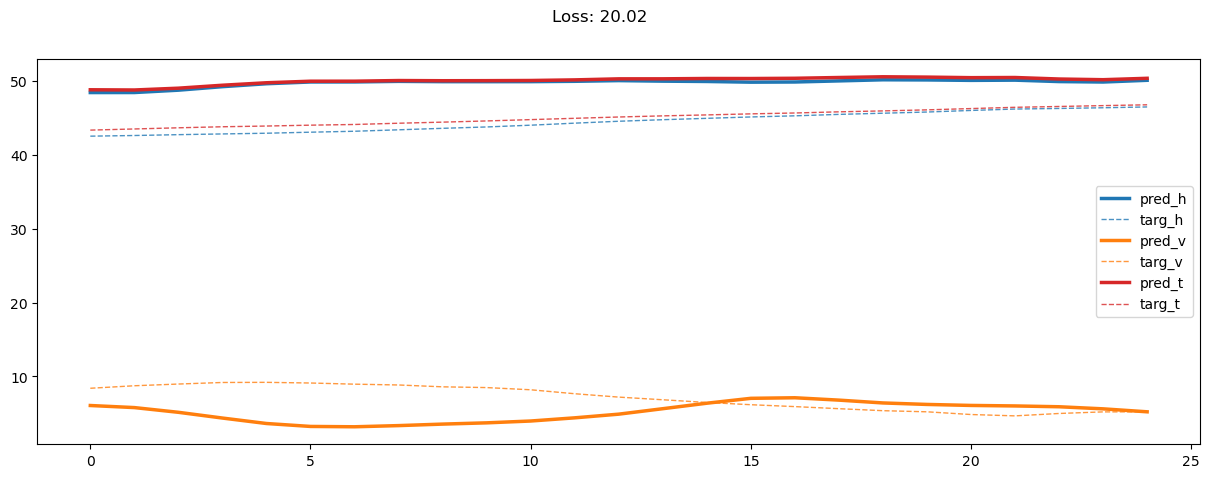

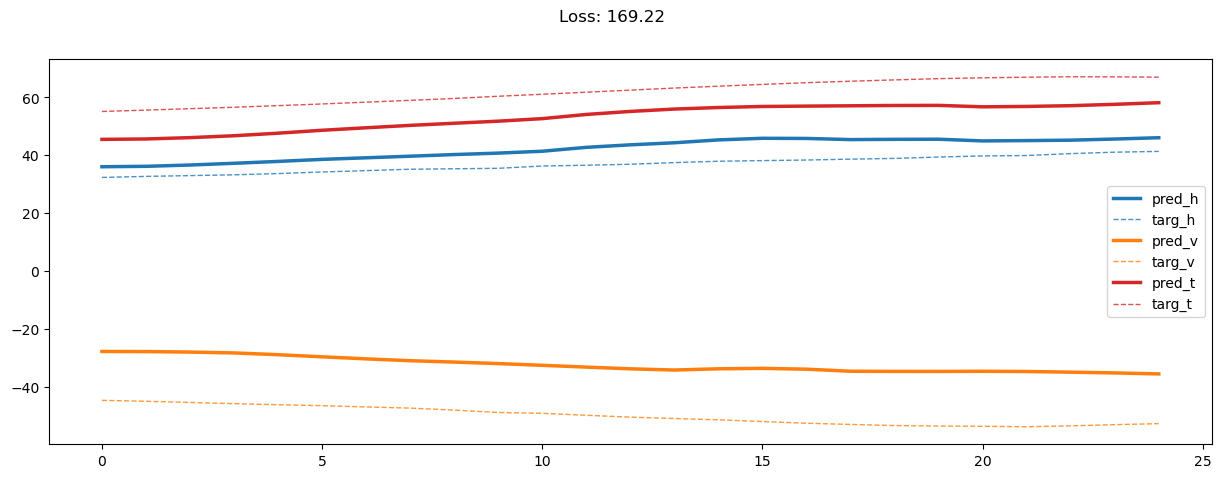

00020: train loss:  400.397, imu loss:  0.137, mag loss:  131.753, div loss:  263.948, slim:  4.161, tlim:  4.692
       valid loss:  314.865, imu loss:  0.104, mag loss:  174.196, div loss:  135.862, slim:  3.897, tlim:  4.972
00040: train loss:  401.288, imu loss:  0.137, mag loss:  132.272, div loss:  264.318, slim:  4.143, tlim:  4.700
       valid loss:  321.581, imu loss:  0.104, mag loss:  178.848, div loss:  137.926, slim:  3.845, tlim:  4.991
00060: train loss:  404.649, imu loss:  0.137, mag loss:  133.643, div loss:  266.265, slim:  4.184, tlim:  4.744
       valid loss:  323.063, imu loss:  0.104, mag loss:  180.048, div loss:  138.266, slim:  3.721, tlim:  4.954
00080: train loss:  394.946, imu loss:  0.137, mag loss:  130.345, div loss:  259.849, slim:  4.186, tlim:  4.757
       valid loss:  319.088, imu loss:  0.104, mag loss:  176.944, div loss:  137.386, slim:  3.765, tlim:  4.950
00100: train loss:  399.989, imu loss:  0.137, mag loss:  132.285, div loss:  263.000, s

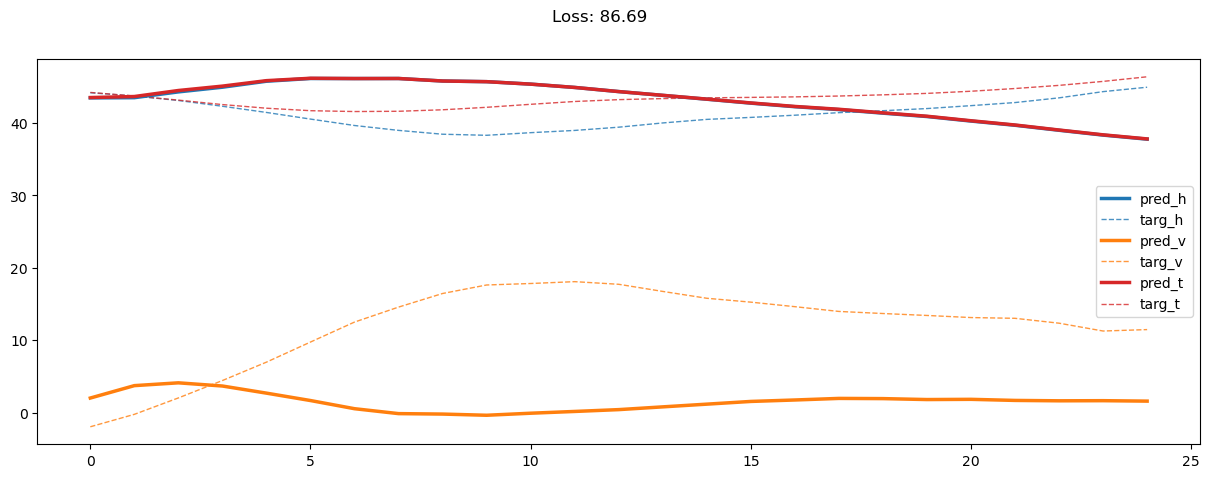

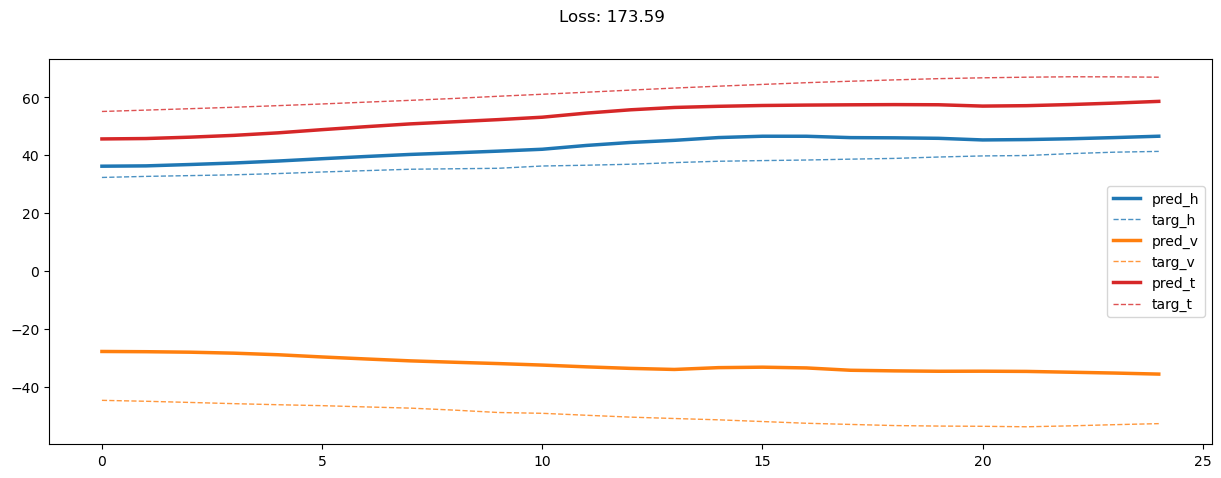

00200: train loss:  401.741, imu loss:  0.138, mag loss:  131.804, div loss:  265.226, slim:  4.159, tlim:  4.711
       valid loss:  323.770, imu loss:  0.104, mag loss:  180.784, div loss:  138.206, slim:  3.797, tlim:  4.969
00220: train loss:  395.776, imu loss:  0.137, mag loss:  130.744, div loss:  260.353, slim:  4.117, tlim:  4.684
       valid loss:  321.797, imu loss:  0.104, mag loss:  178.204, div loss:  138.812, slim:  3.853, tlim:  4.952
00240: train loss:  397.737, imu loss:  0.138, mag loss:  130.596, div loss:  262.469, slim:  4.099, tlim:  4.679
       valid loss:  317.697, imu loss:  0.104, mag loss:  176.007, div loss:  136.815, slim:  4.059, tlim:  5.009
00260: train loss:  399.472, imu loss:  0.136, mag loss:  131.374, div loss:  263.386, slim:  4.139, tlim:  4.721
       valid loss:  320.553, imu loss:  0.104, mag loss:  177.237, div loss:  138.540, slim:  3.803, tlim:  4.961
00280: train loss:  403.469, imu loss:  0.136, mag loss:  132.692, div loss:  266.138, s

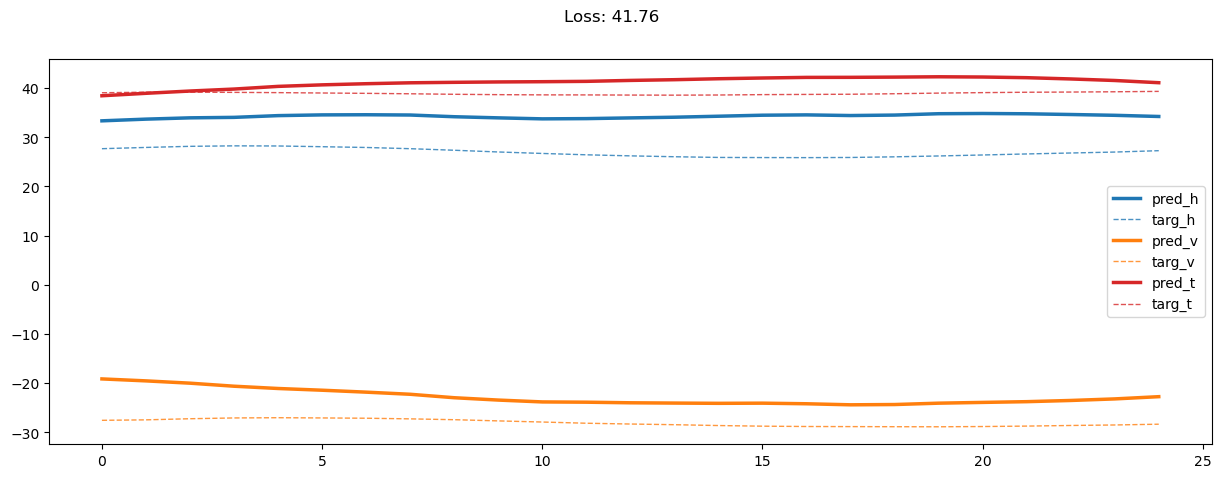

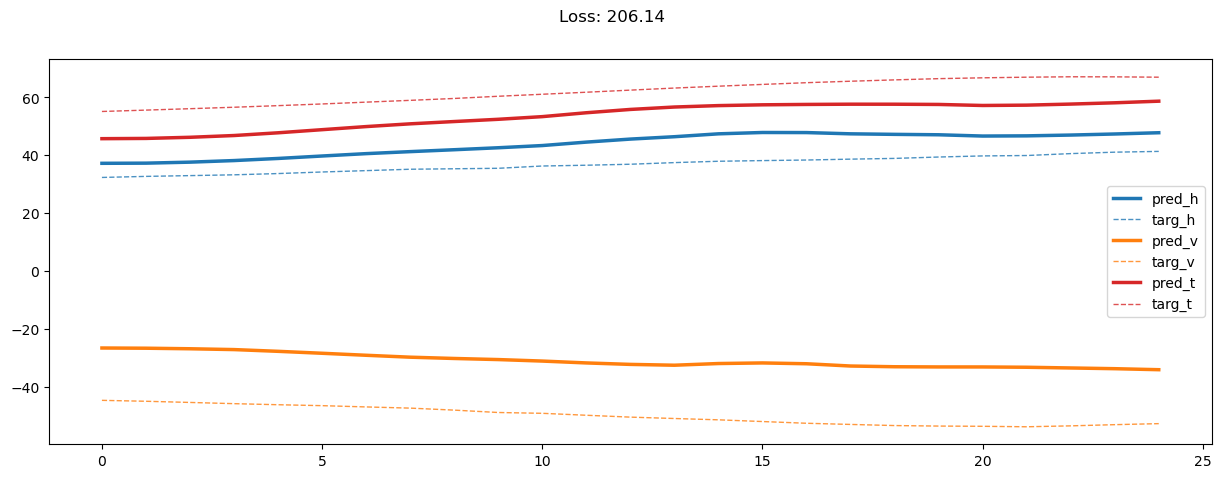

00400: train loss:  394.462, imu loss:  0.136, mag loss:  130.486, div loss:  259.226, slim:  4.203, tlim:  4.750
       valid loss:  324.469, imu loss:  0.104, mag loss:  179.720, div loss:  140.025, slim:  3.737, tlim:  4.915
00420: train loss:  390.371, imu loss:  0.138, mag loss:  130.268, div loss:  255.467, slim:  4.064, tlim:  4.642
       valid loss:  325.799, imu loss:  0.104, mag loss:  180.678, div loss:  140.368, slim:  3.787, tlim:  4.936
00440: train loss:  393.361, imu loss:  0.136, mag loss:  130.726, div loss:  257.923, slim:  4.174, tlim:  4.710
       valid loss:  324.668, imu loss:  0.104, mag loss:  179.981, div loss:  139.946, slim:  3.762, tlim:  4.930
00460: train loss:  395.853, imu loss:  0.137, mag loss:  130.057, div loss:  261.130, slim:  4.113, tlim:  4.668
       valid loss:  323.166, imu loss:  0.104, mag loss:  178.286, div loss:  140.062, slim:  3.895, tlim:  4.986
00480: train loss:  393.386, imu loss:  0.137, mag loss:  129.475, div loss:  259.288, s

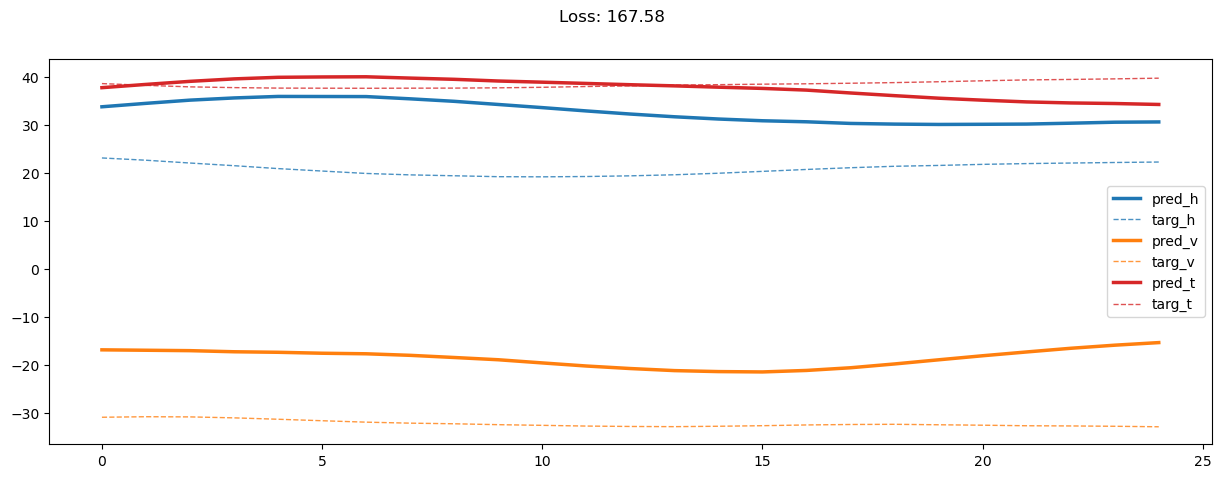

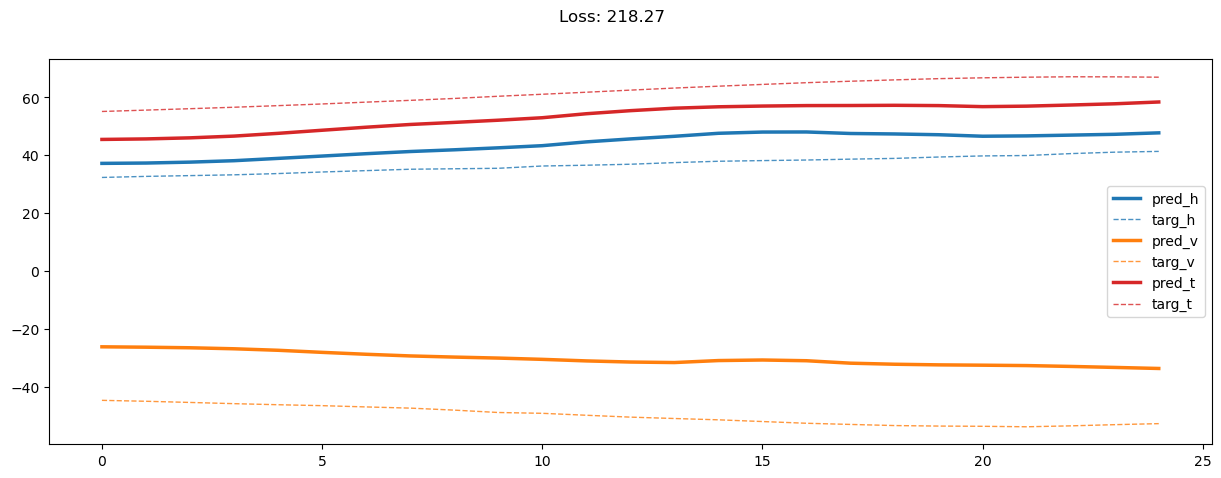

00600: train loss:  388.907, imu loss:  0.137, mag loss:  128.068, div loss:  256.134, slim:  4.168, tlim:  4.701
       valid loss:  327.332, imu loss:  0.103, mag loss:  179.608, div loss:  142.917, slim:  3.890, tlim:  4.974
00620: train loss:  391.208, imu loss:  0.136, mag loss:  128.891, div loss:  257.661, slim:  4.094, tlim:  4.662
       valid loss:  329.875, imu loss:  0.104, mag loss:  181.928, div loss:  143.181, slim:  3.842, tlim:  4.935
00640: train loss:  393.632, imu loss:  0.137, mag loss:  128.259, div loss:  260.705, slim:  4.119, tlim:  4.668
       valid loss:  326.261, imu loss:  0.104, mag loss:  178.199, div loss:  143.323, slim:  3.744, tlim:  4.934
00660: train loss:  389.735, imu loss:  0.136, mag loss:  128.384, div loss:  256.741, slim:  4.029, tlim:  4.623
       valid loss:  326.718, imu loss:  0.104, mag loss:  180.249, div loss:  141.710, slim:  3.847, tlim:  4.926
00680: train loss:  393.558, imu loss:  0.137, mag loss:  129.760, div loss:  259.089, s

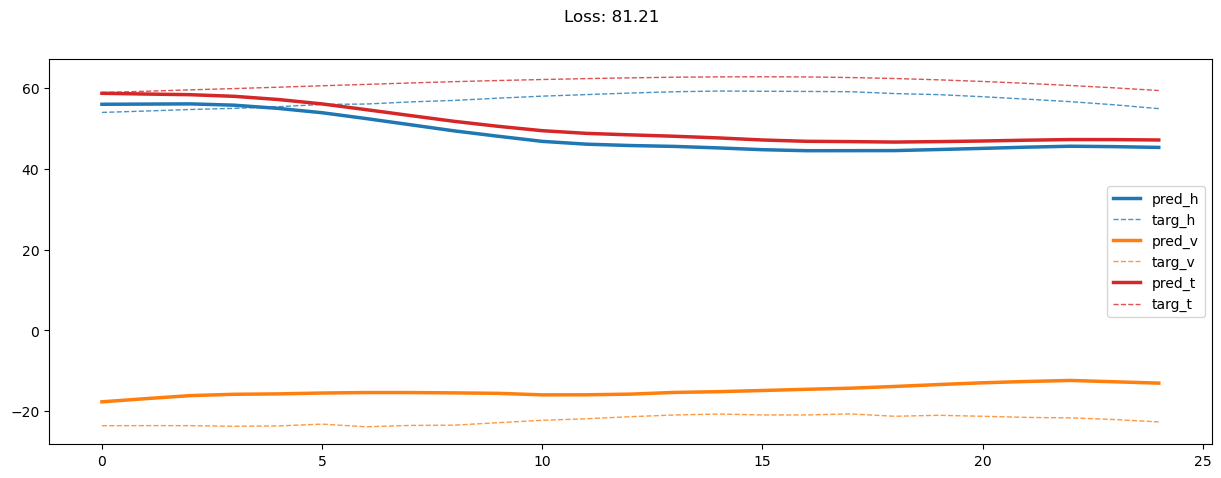

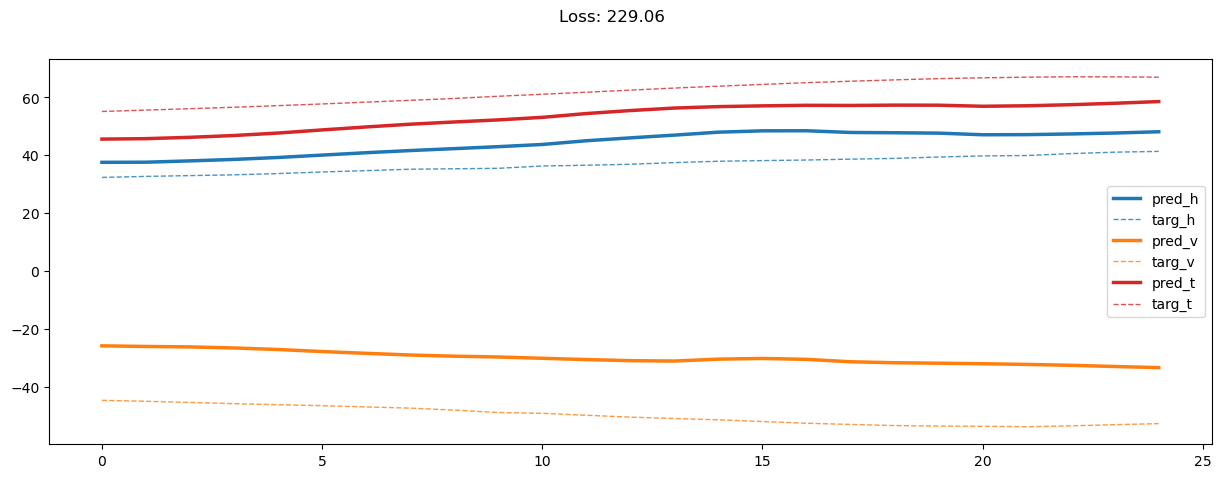

00800: train loss:  388.178, imu loss:  0.137, mag loss:  129.241, div loss:  254.322, slim:  4.053, tlim:  4.620
       valid loss:  325.908, imu loss:  0.103, mag loss:  177.835, div loss:  143.320, slim:  3.784, tlim:  4.938
00820: train loss:  388.882, imu loss:  0.137, mag loss:  127.956, div loss:  256.226, slim:  4.143, tlim:  4.702
       valid loss:  330.202, imu loss:  0.103, mag loss:  181.028, div loss:  144.441, slim:  3.783, tlim:  4.911
00840: train loss:  392.232, imu loss:  0.137, mag loss:  128.971, div loss:  258.593, slim:  4.103, tlim:  4.675
       valid loss:  324.488, imu loss:  0.103, mag loss:  176.742, div loss:  142.959, slim:  3.914, tlim:  4.940
00860: train loss:  389.335, imu loss:  0.137, mag loss:  128.100, div loss:  256.667, slim:  3.957, tlim:  4.590
       valid loss:  329.697, imu loss:  0.103, mag loss:  180.242, div loss:  144.656, slim:  3.890, tlim:  4.964
00880: train loss:  385.510, imu loss:  0.136, mag loss:  127.659, div loss:  253.111, s

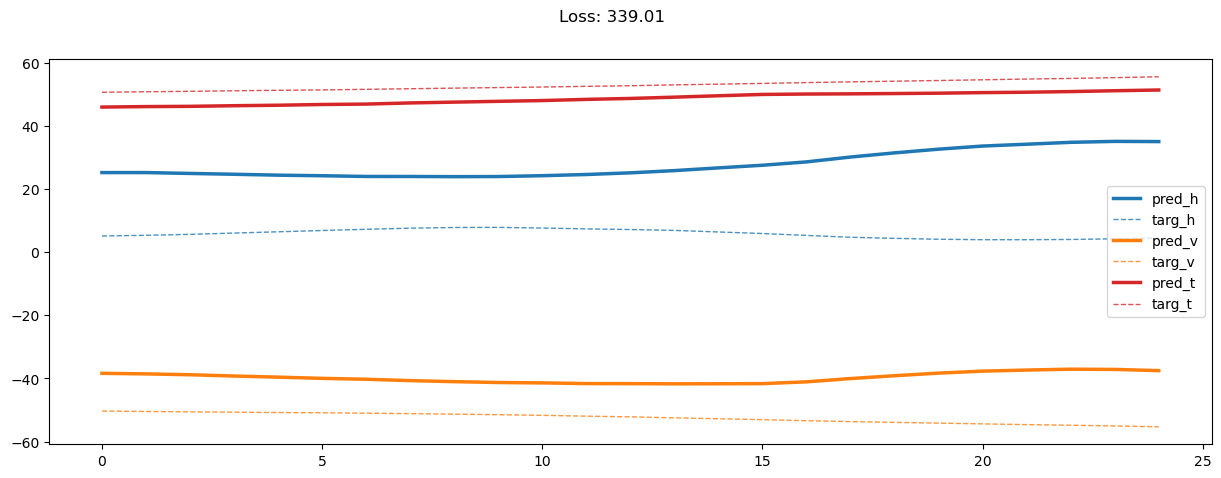

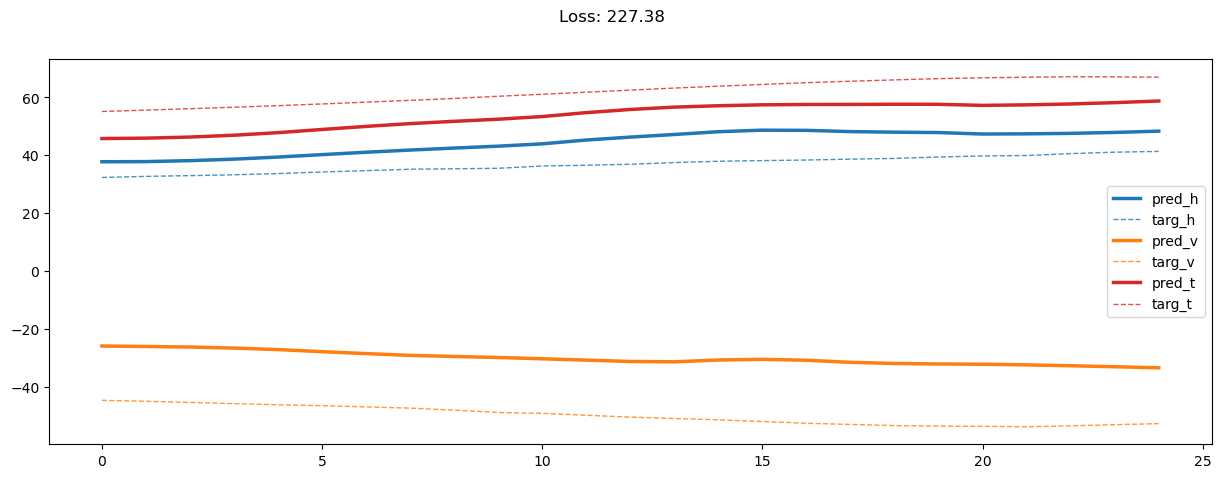

01000: train loss:  388.437, imu loss:  0.137, mag loss:  127.002, div loss:  256.719, slim:  4.178, tlim:  4.712
       valid loss:  332.449, imu loss:  0.103, mag loss:  181.750, div loss:  145.994, slim:  3.692, tlim:  4.905
01020: train loss:  388.631, imu loss:  0.137, mag loss:  128.035, div loss:  255.917, slim:  4.122, tlim:  4.682
       valid loss:  328.705, imu loss:  0.103, mag loss:  179.827, div loss:  144.170, slim:  3.763, tlim:  4.884
01040: train loss:  381.527, imu loss:  0.136, mag loss:  126.069, div loss:  250.857, slim:  4.031, tlim:  4.610
       valid loss:  330.844, imu loss:  0.103, mag loss:  181.709, div loss:  144.409, slim:  3.787, tlim:  4.900
01060: train loss:  387.402, imu loss:  0.136, mag loss:  127.436, div loss:  255.372, slim:  4.025, tlim:  4.601
       valid loss:  328.783, imu loss:  0.103, mag loss:  179.612, div loss:  144.396, slim:  3.788, tlim:  4.967
01080: train loss:  382.966, imu loss:  0.136, mag loss:  126.340, div loss:  251.975, s

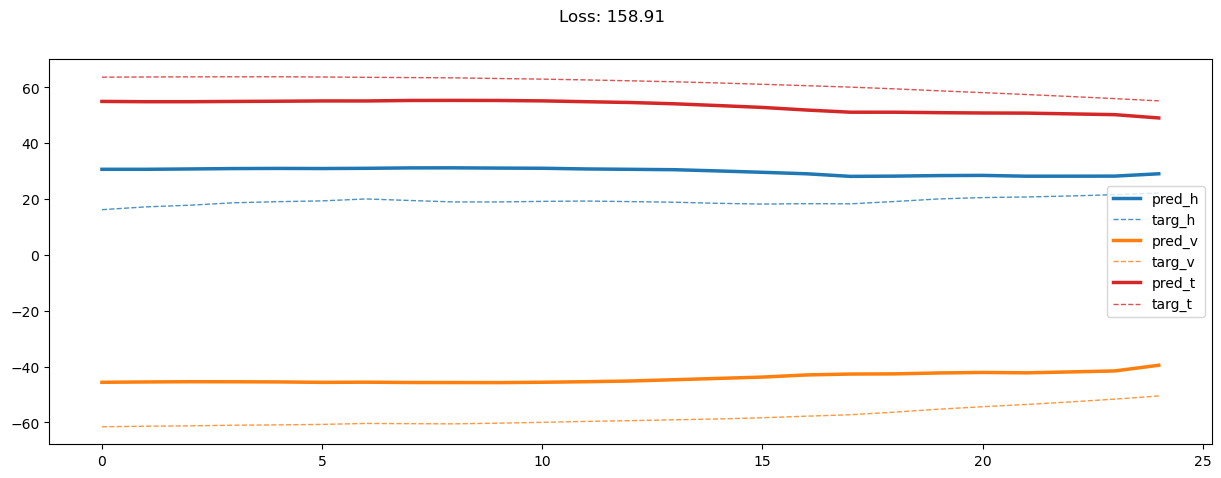

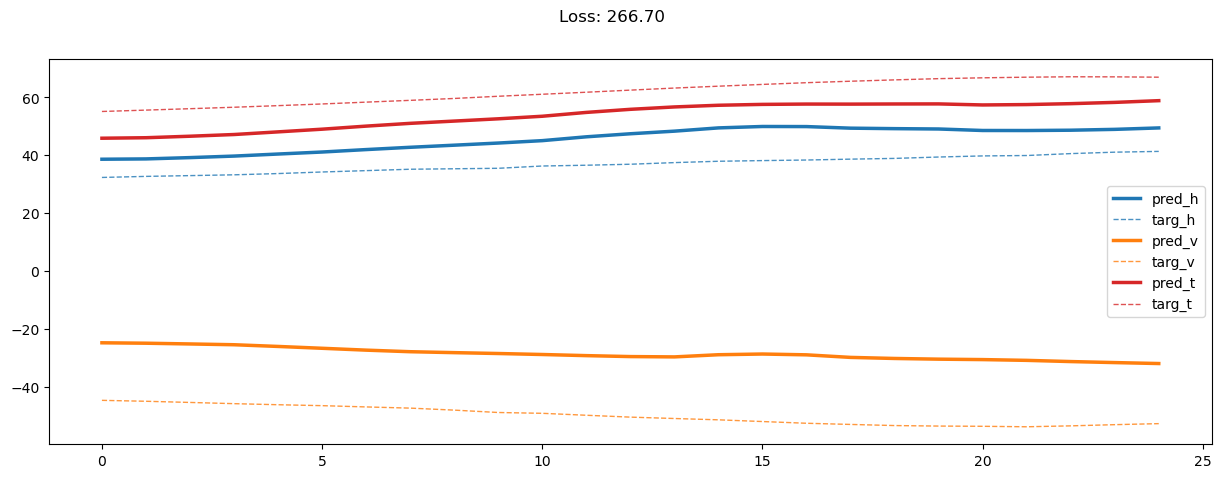

01200: train loss:  385.116, imu loss:  0.136, mag loss:  126.478, div loss:  253.963, slim:  4.122, tlim:  4.678
       valid loss:  332.450, imu loss:  0.103, mag loss:  181.015, div loss:  146.695, slim:  3.799, tlim:  4.916
01220: train loss:  380.436, imu loss:  0.136, mag loss:  125.153, div loss:  250.670, slim:  4.017, tlim:  4.630
       valid loss:  332.178, imu loss:  0.103, mag loss:  180.686, div loss:  146.727, slim:  3.775, tlim:  4.958
01240: train loss:  387.038, imu loss:  0.136, mag loss:  127.370, div loss:  255.009, slim:  4.117, tlim:  4.658
       valid loss:  323.864, imu loss:  0.103, mag loss:  175.247, div loss:  143.800, slim:  3.999, tlim:  4.952
01260: train loss:  379.575, imu loss:  0.137, mag loss:  124.908, div loss:  250.088, slim:  4.024, tlim:  4.581
       valid loss:  331.512, imu loss:  0.103, mag loss:  179.968, div loss:  146.833, slim:  3.737, tlim:  4.898
01280: train loss:  385.569, imu loss:  0.137, mag loss:  126.511, div loss:  254.434, s

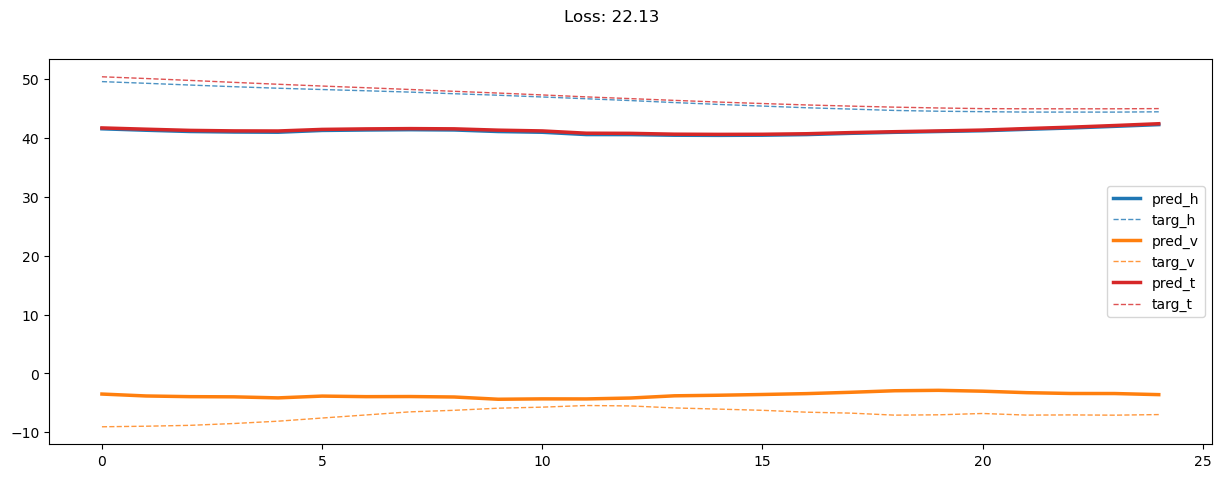

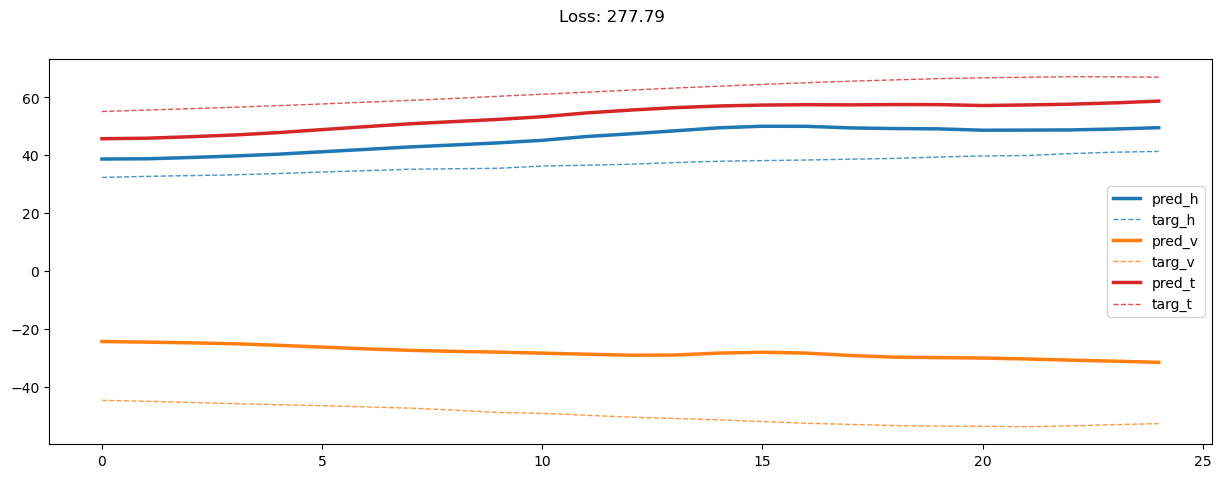

01400: train loss:  381.454, imu loss:  0.136, mag loss:  125.593, div loss:  251.146, slim:  4.194, tlim:  4.707
       valid loss:  331.428, imu loss:  0.103, mag loss:  180.010, div loss:  146.680, slim:  3.781, tlim:  4.919
01420: train loss:  384.163, imu loss:  0.136, mag loss:  126.173, div loss:  253.404, slim:  3.993, tlim:  4.603
       valid loss:  328.470, imu loss:  0.103, mag loss:  177.485, div loss:  146.261, slim:  3.785, tlim:  4.899
01440: train loss:  375.792, imu loss:  0.136, mag loss:  124.090, div loss:  247.060, slim:  4.099, tlim:  4.642
       valid loss:  332.084, imu loss:  0.103, mag loss:  179.900, div loss:  147.419, slim:  3.800, tlim:  4.949
01460: train loss:  381.588, imu loss:  0.136, mag loss:  124.740, div loss:  252.246, slim:  4.037, tlim:  4.609
       valid loss:  337.977, imu loss:  0.103, mag loss:  184.571, div loss:  148.625, slim:  3.867, tlim:  4.947
01480: train loss:  378.220, imu loss:  0.136, mag loss:  124.554, div loss:  249.023, s

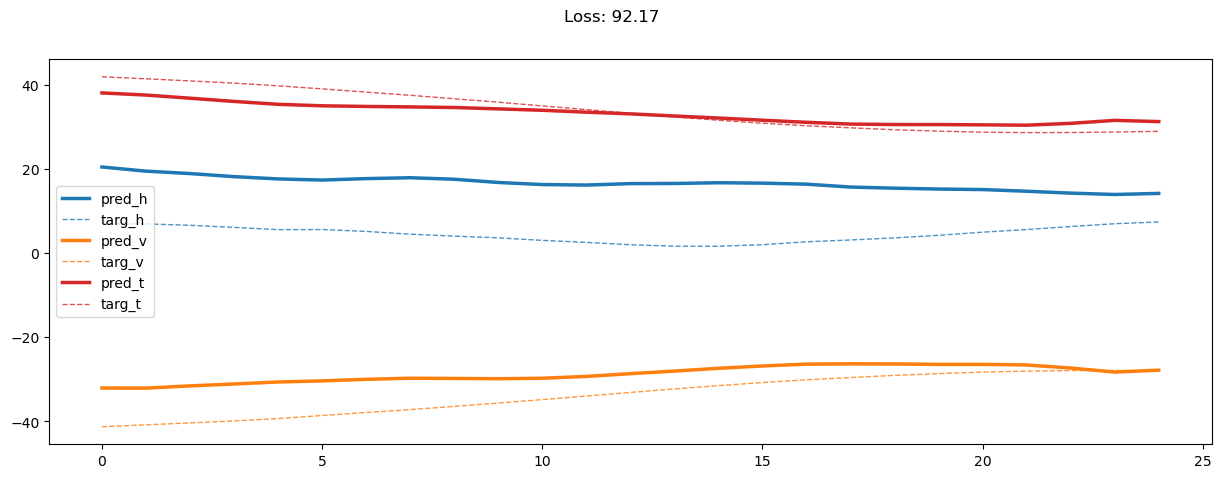

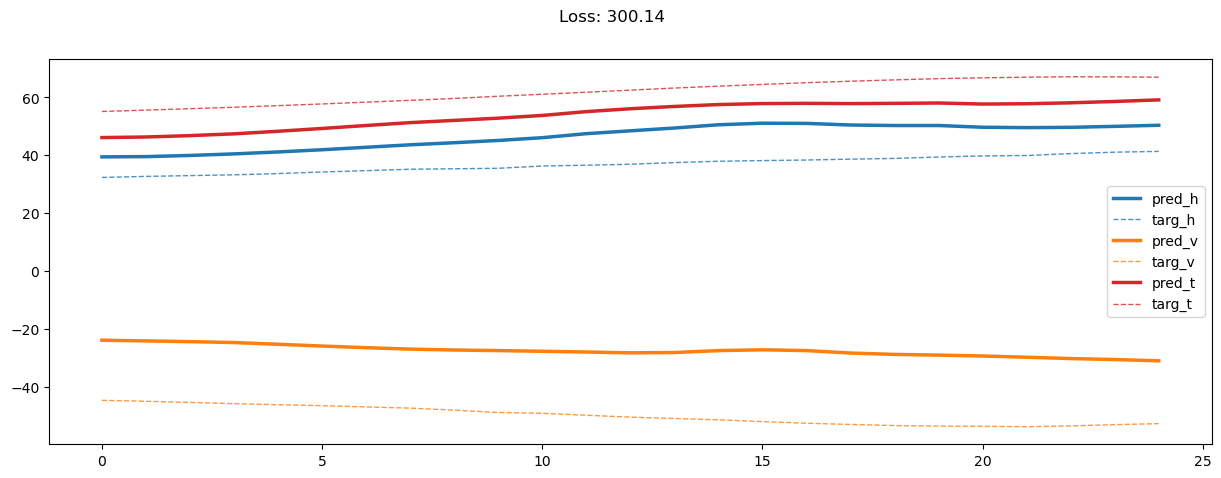

01600: train loss:  377.789, imu loss:  0.136, mag loss:  123.960, div loss:  249.114, slim:  4.208, tlim:  4.702
       valid loss:  332.640, imu loss:  0.103, mag loss:  180.227, div loss:  147.768, slim:  3.653, tlim:  4.838
01620: train loss:  369.903, imu loss:  0.136, mag loss:  123.659, div loss:  241.600, slim:  4.078, tlim:  4.652
       valid loss:  334.343, imu loss:  0.103, mag loss:  181.603, div loss:  148.027, slim:  3.786, tlim:  4.885
01640: train loss:  375.794, imu loss:  0.137, mag loss:  123.725, div loss:  247.517, slim:  3.987, tlim:  4.558
       valid loss:  334.706, imu loss:  0.103, mag loss:  181.783, div loss:  148.210, slim:  3.738, tlim:  4.901
01660: train loss:  379.962, imu loss:  0.136, mag loss:  124.404, div loss:  250.952, slim:  4.075, tlim:  4.601
       valid loss:  338.251, imu loss:  0.103, mag loss:  184.059, div loss:  149.466, slim:  3.780, tlim:  4.903
01680: train loss:  371.053, imu loss:  0.136, mag loss:  122.490, div loss:  243.905, s

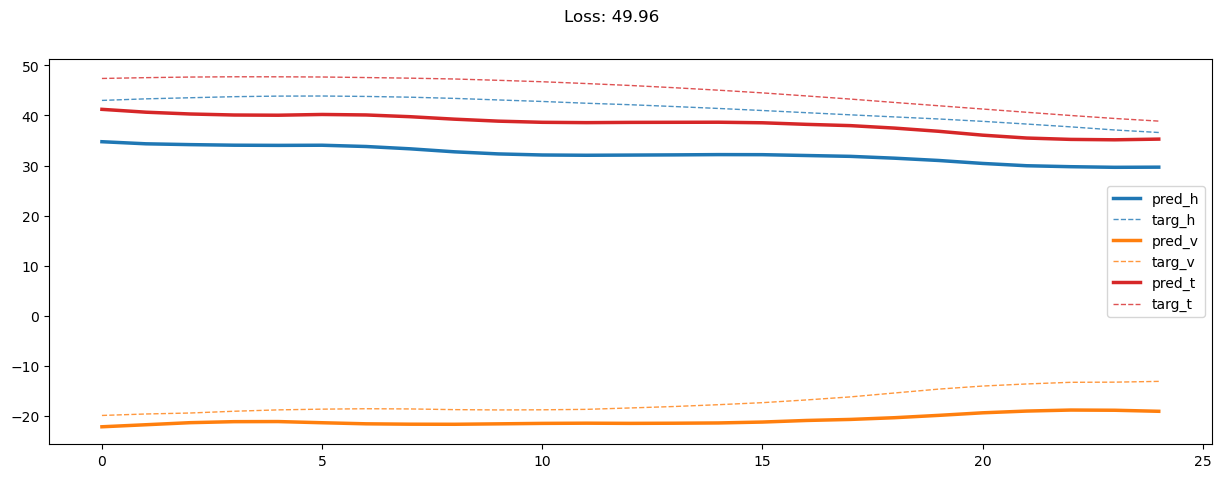

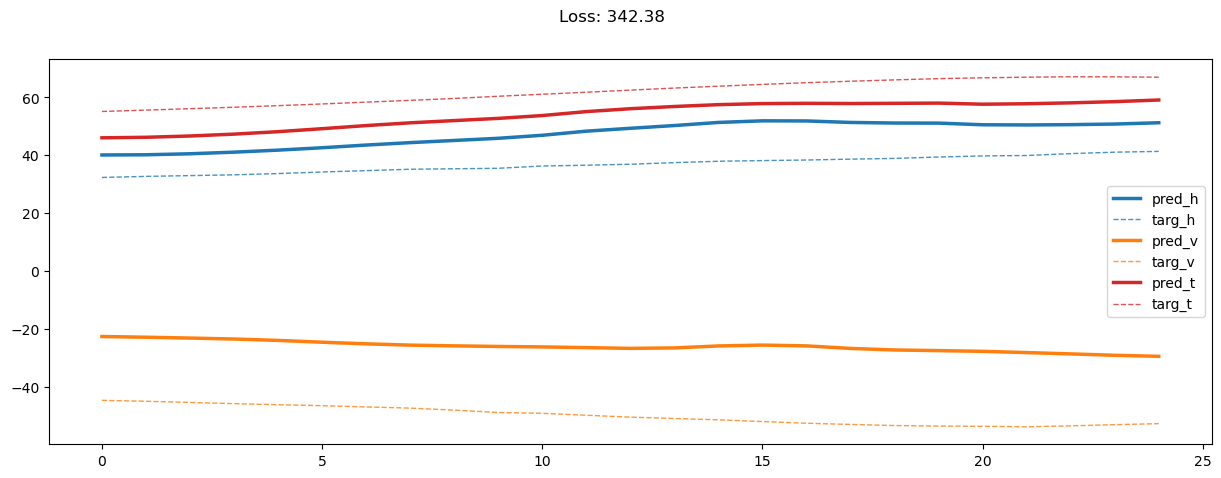

01800: train loss:  374.438, imu loss:  0.137, mag loss:  123.785, div loss:  246.061, slim:  4.026, tlim:  4.597
       valid loss:  334.260, imu loss:  0.103, mag loss:  181.174, div loss:  148.324, slim:  3.827, tlim:  4.936
01820: train loss:  369.931, imu loss:  0.136, mag loss:  122.927, div loss:  242.391, slim:  4.030, tlim:  4.626
       valid loss:  337.919, imu loss:  0.103, mag loss:  182.273, div loss:  150.838, slim:  3.868, tlim:  4.983
01840: train loss:  372.609, imu loss:  0.136, mag loss:  122.281, div loss:  245.693, slim:  4.081, tlim:  4.638
       valid loss:  331.815, imu loss:  0.103, mag loss:  178.490, div loss:  148.579, slim:  3.798, tlim:  4.925
01860: train loss:  370.829, imu loss:  0.136, mag loss:  122.118, div loss:  244.043, slim:  4.089, tlim:  4.680
       valid loss:  332.144, imu loss:  0.103, mag loss:  179.786, div loss:  147.644, slim:  3.735, tlim:  4.901
01880: train loss:  370.118, imu loss:  0.137, mag loss:  122.370, div loss:  243.154, s

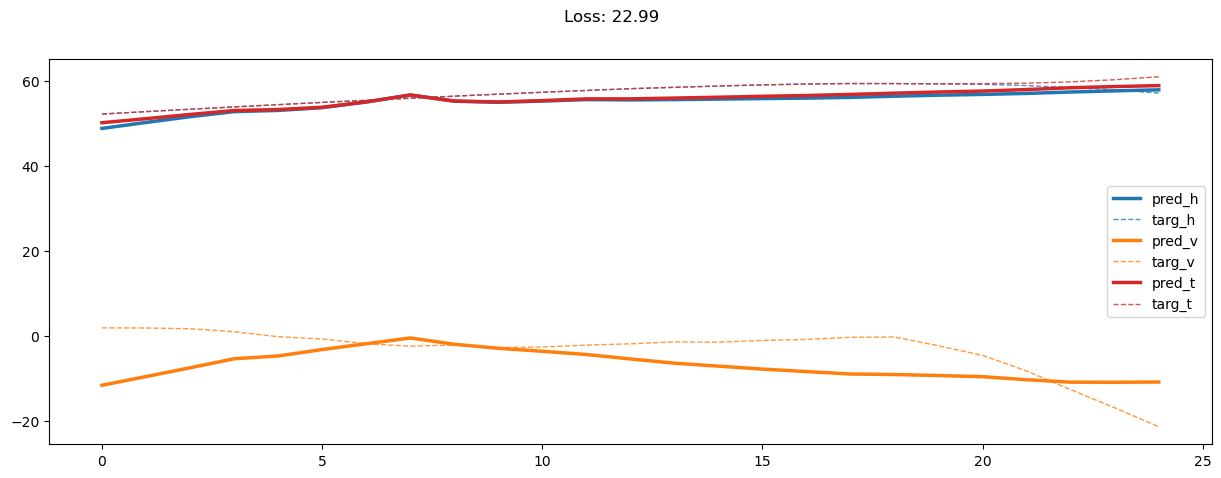

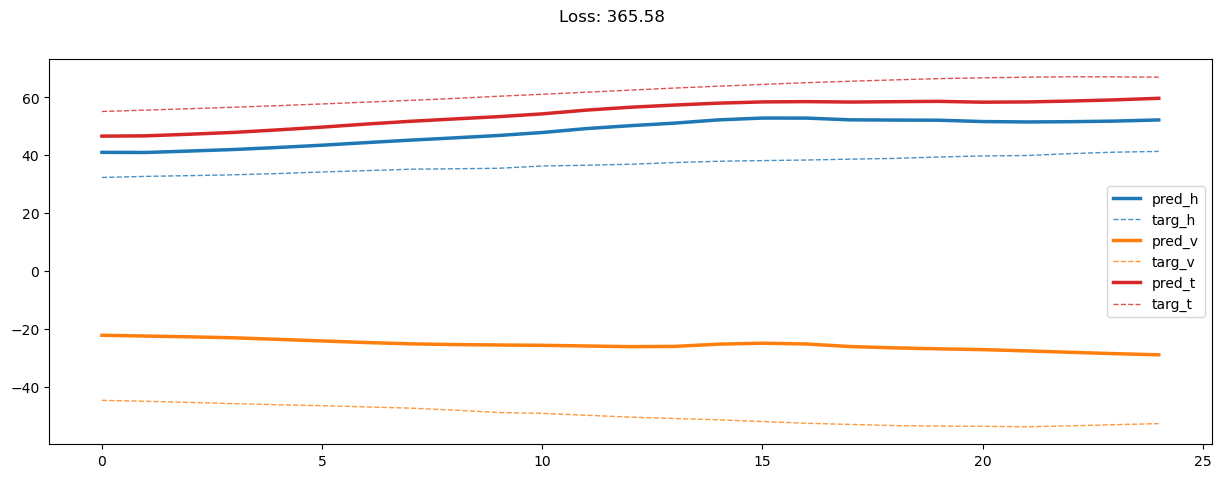

02000: train loss:  368.652, imu loss:  0.136, mag loss:  122.078, div loss:  241.962, slim:  4.073, tlim:  4.610
       valid loss:  338.927, imu loss:  0.103, mag loss:  182.364, div loss:  151.856, slim:  3.707, tlim:  4.901
02020: train loss:  370.413, imu loss:  0.136, mag loss:  122.652, div loss:  243.128, slim:  4.093, tlim:  4.632
       valid loss:  342.255, imu loss:  0.103, mag loss:  185.277, div loss:  152.277, slim:  3.682, tlim:  4.903
02040: train loss:  366.949, imu loss:  0.136, mag loss:  120.799, div loss:  241.575, slim:  4.029, tlim:  4.575
       valid loss:  340.658, imu loss:  0.103, mag loss:  184.760, div loss:  151.117, slim:  3.812, tlim:  4.966
02060: train loss:  367.917, imu loss:  0.136, mag loss:  121.241, div loss:  242.030, slim:  4.130, tlim:  4.638
       valid loss:  338.065, imu loss:  0.103, mag loss:  182.642, div loss:  150.648, slim:  3.819, tlim:  4.956
02080: train loss:  361.225, imu loss:  0.135, mag loss:  119.966, div loss:  236.638, s

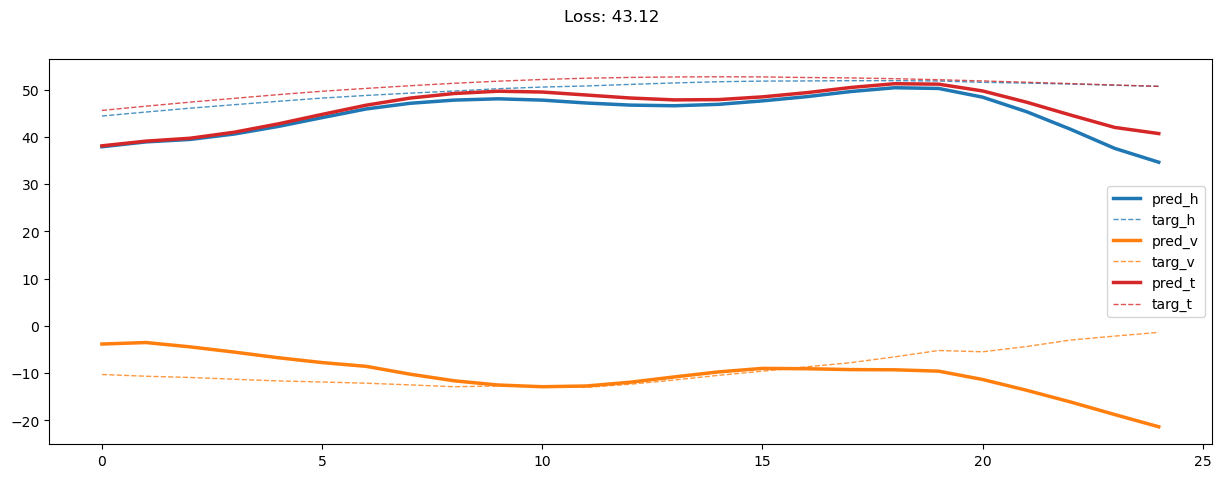

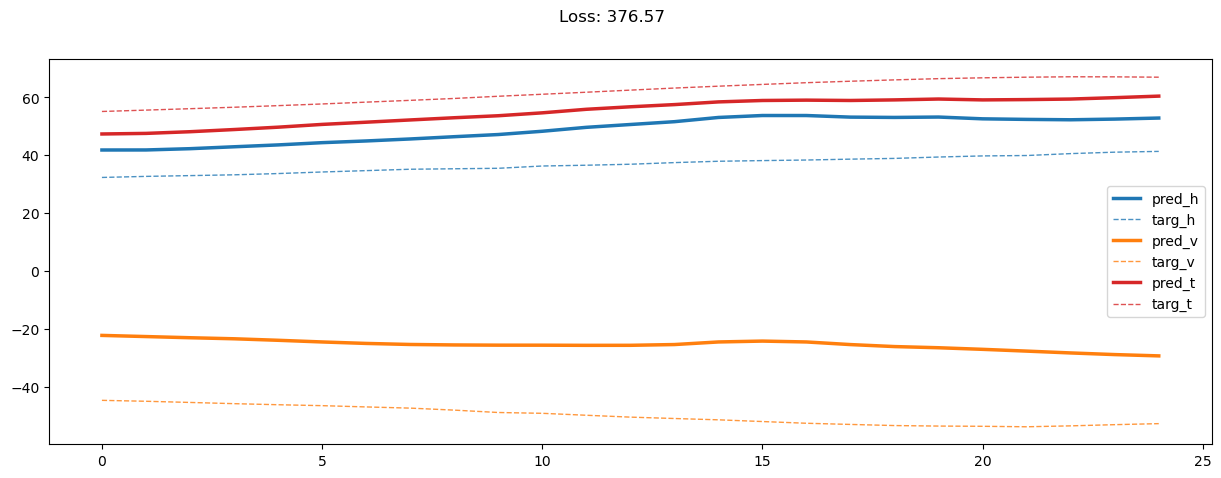

02200: train loss:  363.005, imu loss:  0.136, mag loss:  118.410, div loss:  239.964, slim:  4.075, tlim:  4.635
       valid loss:  347.461, imu loss:  0.103, mag loss:  187.808, div loss:  154.945, slim:  3.640, tlim:  4.926
02220: train loss:  363.152, imu loss:  0.137, mag loss:  119.427, div loss:  239.139, slim:  4.022, tlim:  4.593
       valid loss:  340.178, imu loss:  0.104, mag loss:  182.740, div loss:  152.701, slim:  3.747, tlim:  4.930
02240: train loss:  361.866, imu loss:  0.136, mag loss:  119.850, div loss:  237.355, slim:  4.111, tlim:  4.663
       valid loss:  347.442, imu loss:  0.104, mag loss:  187.724, div loss:  155.009, slim:  3.591, tlim:  4.944
02260: train loss:  362.965, imu loss:  0.137, mag loss:  119.044, div loss:  239.296, slim:  4.087, tlim:  4.622
       valid loss:  343.635, imu loss:  0.103, mag loss:  186.772, div loss:  152.148, slim:  3.676, tlim:  4.922
02280: train loss:  362.783, imu loss:  0.136, mag loss:  119.175, div loss:  239.020, s

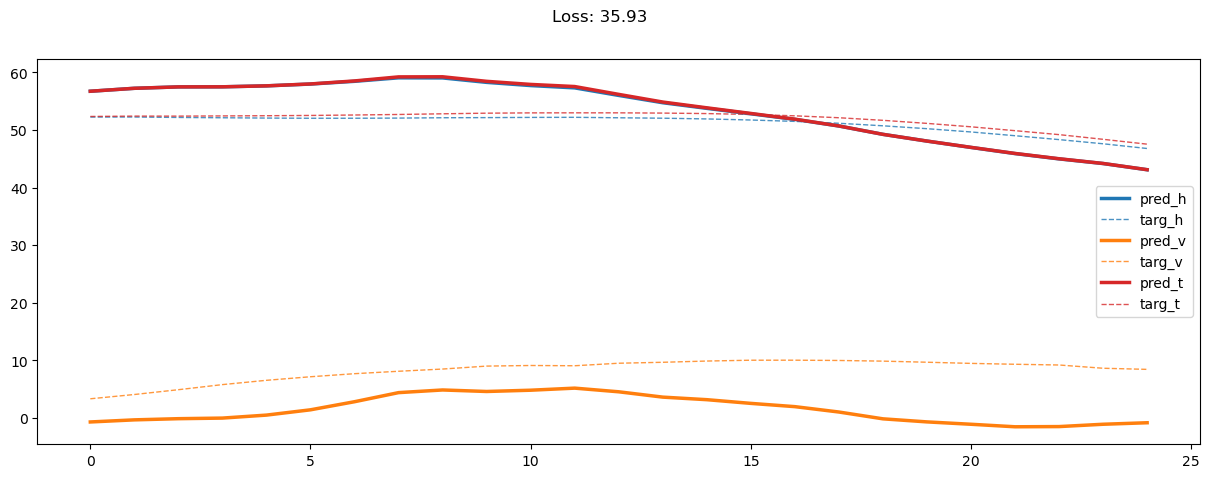

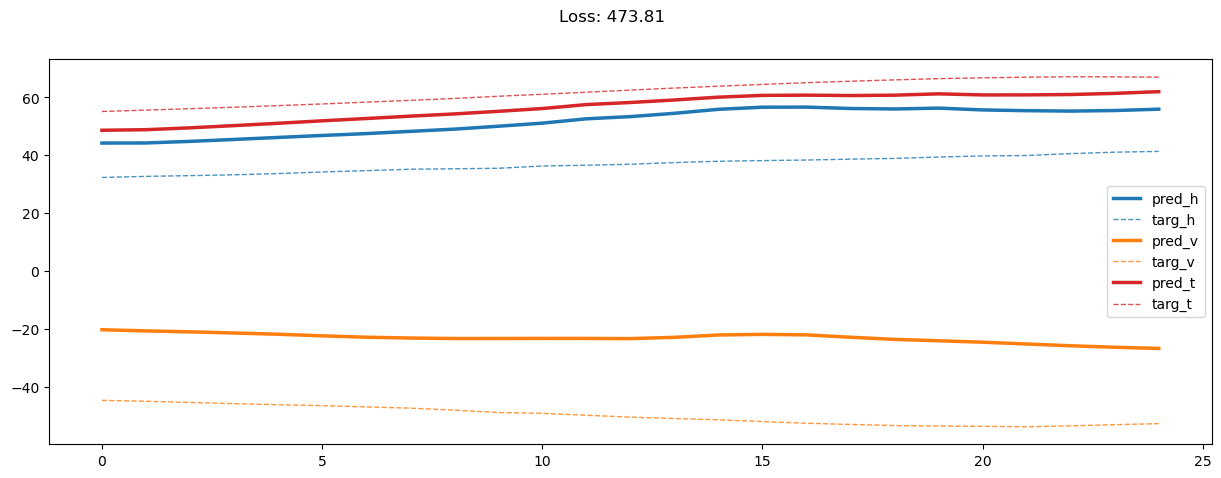

02400: train loss:  356.880, imu loss:  0.137, mag loss:  118.352, div loss:  233.936, slim:  4.042, tlim:  4.594
       valid loss:  340.459, imu loss:  0.104, mag loss:  182.388, div loss:  153.348, slim:  3.703, tlim:  4.925
02420: train loss:  364.476, imu loss:  0.137, mag loss:  120.086, div loss:  239.776, slim:  4.060, tlim:  4.617
       valid loss:  342.223, imu loss:  0.104, mag loss:  184.822, div loss:  152.693, slim:  3.704, tlim:  4.904
02440: train loss:  360.993, imu loss:  0.136, mag loss:  118.767, div loss:  237.701, slim:  3.960, tlim:  4.531
       valid loss:  344.649, imu loss:  0.104, mag loss:  185.219, div loss:  154.693, slim:  3.758, tlim:  4.925
02460: train loss:  362.040, imu loss:  0.136, mag loss:  119.683, div loss:  237.803, slim:  3.993, tlim:  4.560
       valid loss:  347.932, imu loss:  0.104, mag loss:  187.685, div loss:  155.413, slim:  3.904, tlim:  5.007
02480: train loss:  364.825, imu loss:  0.136, mag loss:  119.767, div loss:  240.443, s

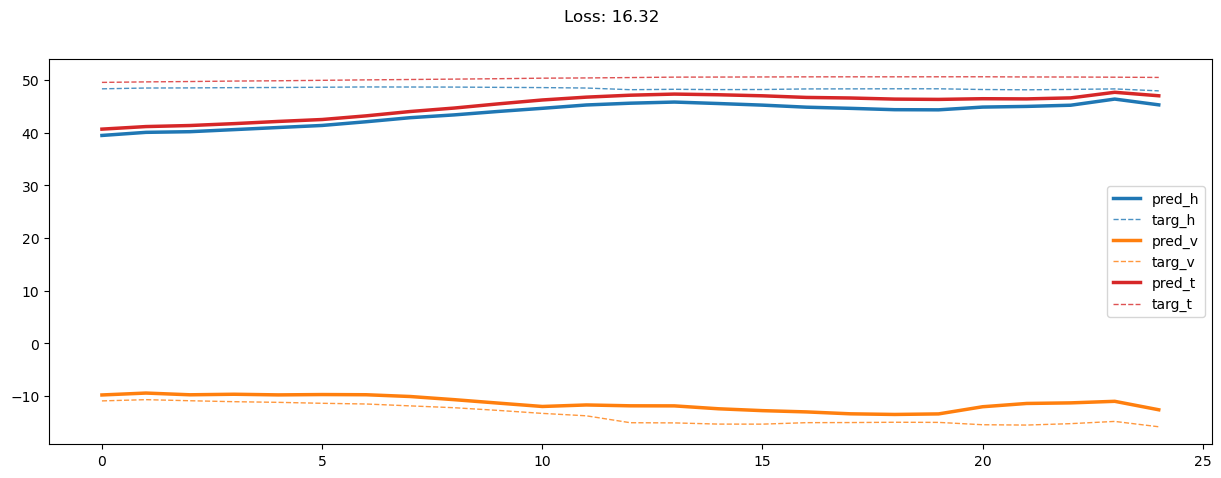

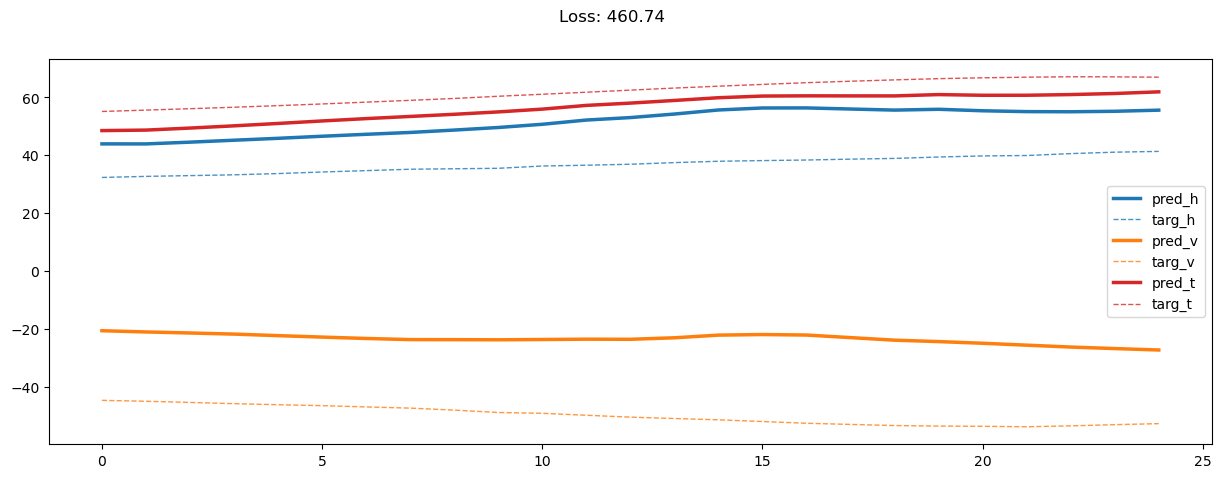

02600: train loss:  360.564, imu loss:  0.137, mag loss:  119.015, div loss:  236.978, slim:  4.036, tlim:  4.567
       valid loss:  340.084, imu loss:  0.104, mag loss:  181.876, div loss:  153.371, slim:  4.001, tlim:  4.977
02620: train loss:  358.265, imu loss:  0.137, mag loss:  117.710, div loss:  235.966, slim:  4.003, tlim:  4.602
       valid loss:  346.187, imu loss:  0.104, mag loss:  185.851, div loss:  155.626, slim:  3.679, tlim:  4.916
02640: train loss:  357.323, imu loss:  0.136, mag loss:  116.686, div loss:  236.032, slim:  4.058, tlim:  4.607
       valid loss:  342.303, imu loss:  0.104, mag loss:  182.488, div loss:  155.107, slim:  3.731, tlim:  4.895
02660: train loss:  359.437, imu loss:  0.137, mag loss:  118.994, div loss:  235.828, slim:  4.061, tlim:  4.617
       valid loss:  341.822, imu loss:  0.104, mag loss:  181.374, div loss:  155.672, slim:  3.813, tlim:  4.959
02680: train loss:  356.196, imu loss:  0.135, mag loss:  117.464, div loss:  234.138, s

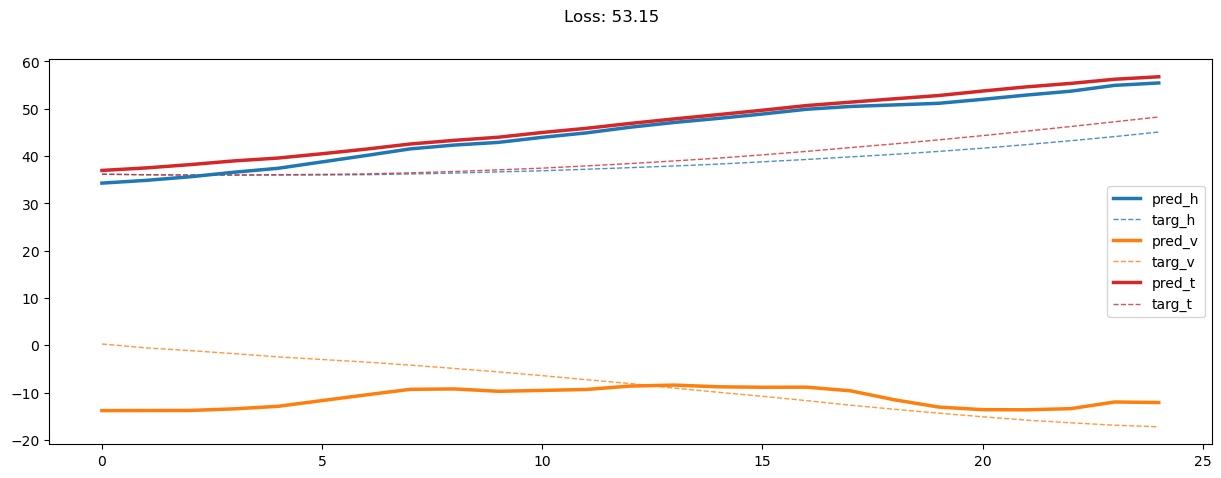

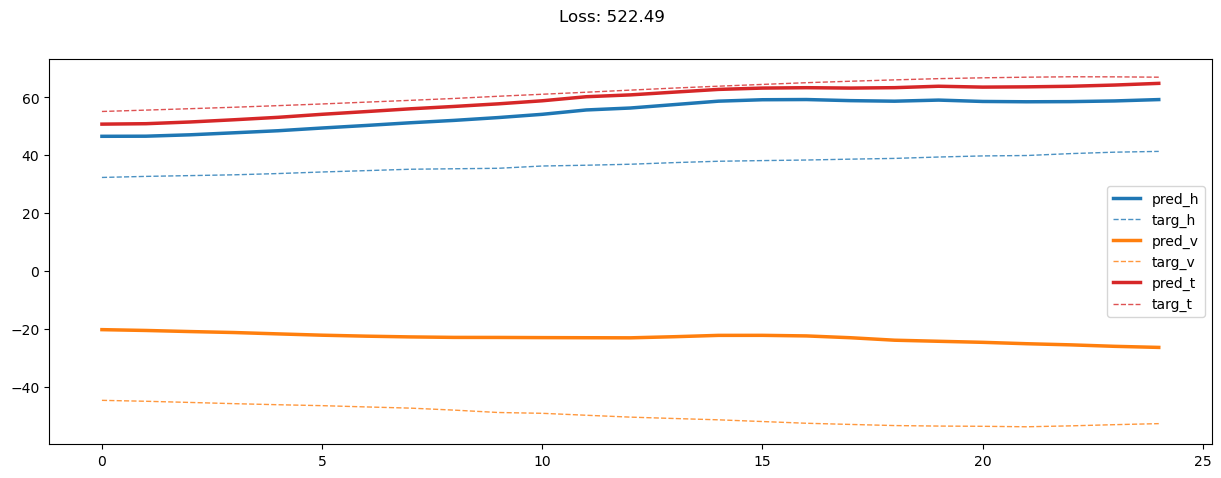

02800: train loss:  352.823, imu loss:  0.136, mag loss:  117.520, div loss:  230.715, slim:  4.047, tlim:  4.587
       valid loss:  349.640, imu loss:  0.104, mag loss:  186.593, div loss:  158.320, slim:  3.728, tlim:  4.922
02820: train loss:  354.882, imu loss:  0.137, mag loss:  116.457, div loss:  233.824, slim:  4.059, tlim:  4.599
       valid loss:  351.275, imu loss:  0.104, mag loss:  187.979, div loss:  158.595, slim:  3.697, tlim:  4.896
02840: train loss:  359.454, imu loss:  0.136, mag loss:  118.119, div loss:  236.853, slim:  3.918, tlim:  4.488
       valid loss:  347.006, imu loss:  0.104, mag loss:  183.924, div loss:  158.337, slim:  3.755, tlim:  4.936
02860: train loss:  351.246, imu loss:  0.136, mag loss:  115.844, div loss:  230.857, slim:  3.975, tlim:  4.555
       valid loss:  350.721, imu loss:  0.104, mag loss:  187.686, div loss:  158.354, slim:  3.704, tlim:  4.869
02880: train loss:  350.852, imu loss:  0.136, mag loss:  116.942, div loss:  229.383, s

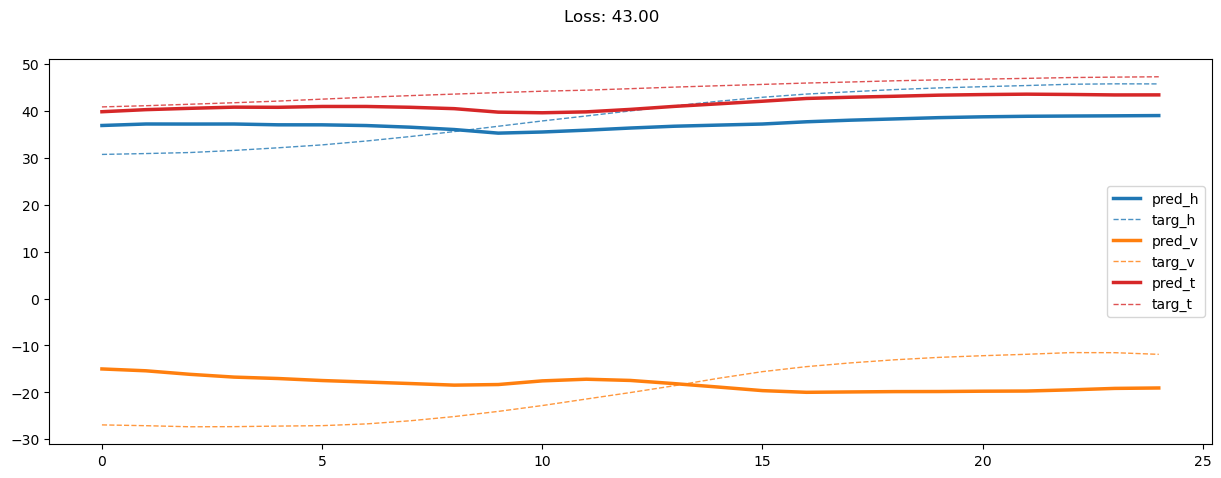

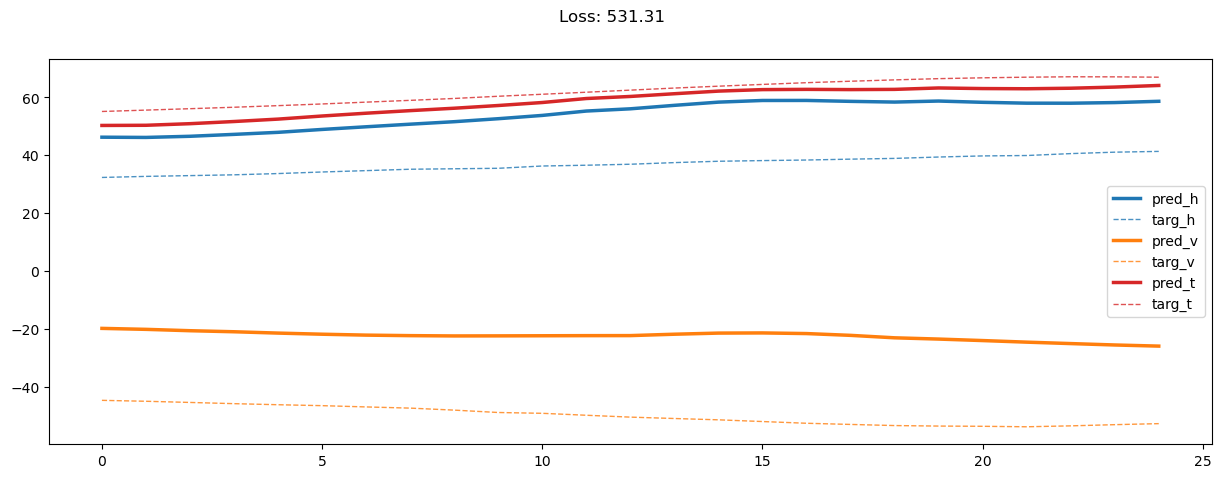

03000: train loss:  346.632, imu loss:  0.137, mag loss:  115.168, div loss:  226.854, slim:  4.068, tlim:  4.608
       valid loss:  360.903, imu loss:  0.104, mag loss:  194.320, div loss:  161.887, slim:  3.561, tlim:  4.935
03020: train loss:  349.351, imu loss:  0.136, mag loss:  115.573, div loss:  229.190, slim:  4.057, tlim:  4.585
       valid loss:  353.960, imu loss:  0.104, mag loss:  188.954, div loss:  160.249, slim:  3.754, tlim:  4.953
03040: train loss:  362.676, imu loss:  0.137, mag loss:  118.045, div loss:  240.062, slim:  4.023, tlim:  4.568
       valid loss:  348.950, imu loss:  0.104, mag loss:  185.225, div loss:  158.952, slim:  3.804, tlim:  4.958
03060: train loss:  348.472, imu loss:  0.136, mag loss:  115.527, div loss:  228.390, slim:  3.964, tlim:  4.571
       valid loss:  354.883, imu loss:  0.104, mag loss:  189.363, div loss:  160.798, slim:  3.721, tlim:  4.917
03080: train loss:  354.322, imu loss:  0.136, mag loss:  115.383, div loss:  234.325, s

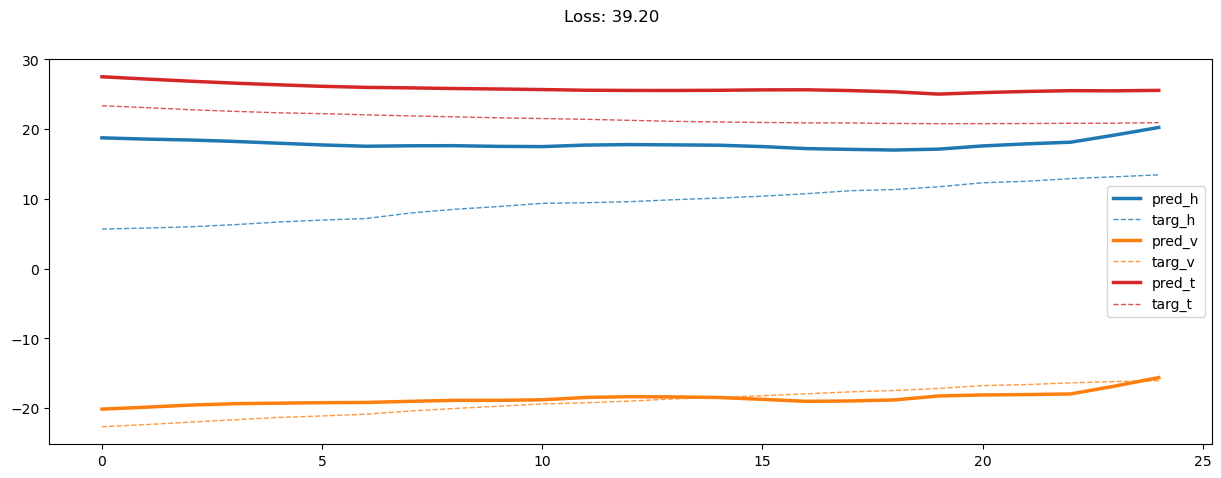

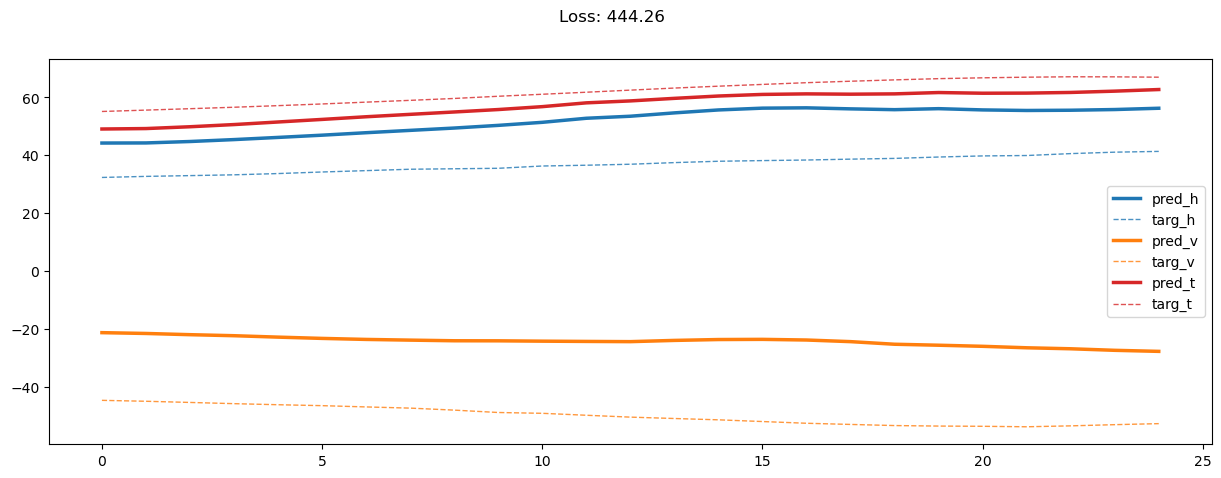

03200: train loss:  345.477, imu loss:  0.136, mag loss:  113.357, div loss:  227.592, slim:  3.986, tlim:  4.527
       valid loss:  351.775, imu loss:  0.104, mag loss:  187.142, div loss:  159.816, slim:  3.872, tlim:  4.995
03220: train loss:  345.606, imu loss:  0.137, mag loss:  114.208, div loss:  226.875, slim:  3.985, tlim:  4.520
       valid loss:  357.247, imu loss:  0.104, mag loss:  190.761, div loss:  161.730, slim:  3.786, tlim:  4.942
03240: train loss:  348.911, imu loss:  0.136, mag loss:  115.577, div loss:  228.789, slim:  3.979, tlim:  4.552
       valid loss:  349.857, imu loss:  0.104, mag loss:  187.358, div loss:  157.758, slim:  3.714, tlim:  4.945
03260: train loss:  348.838, imu loss:  0.136, mag loss:  114.840, div loss:  229.443, slim:  4.025, tlim:  4.550
       valid loss:  350.942, imu loss:  0.104, mag loss:  185.988, div loss:  160.236, slim:  3.755, tlim:  4.902
03280: train loss:  343.234, imu loss:  0.137, mag loss:  113.948, div loss:  224.693, s

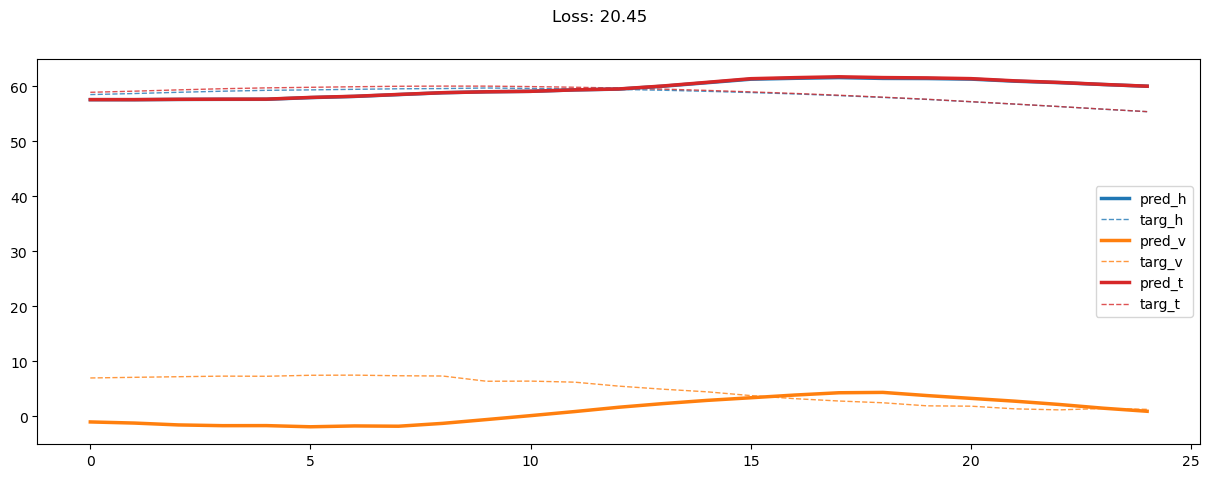

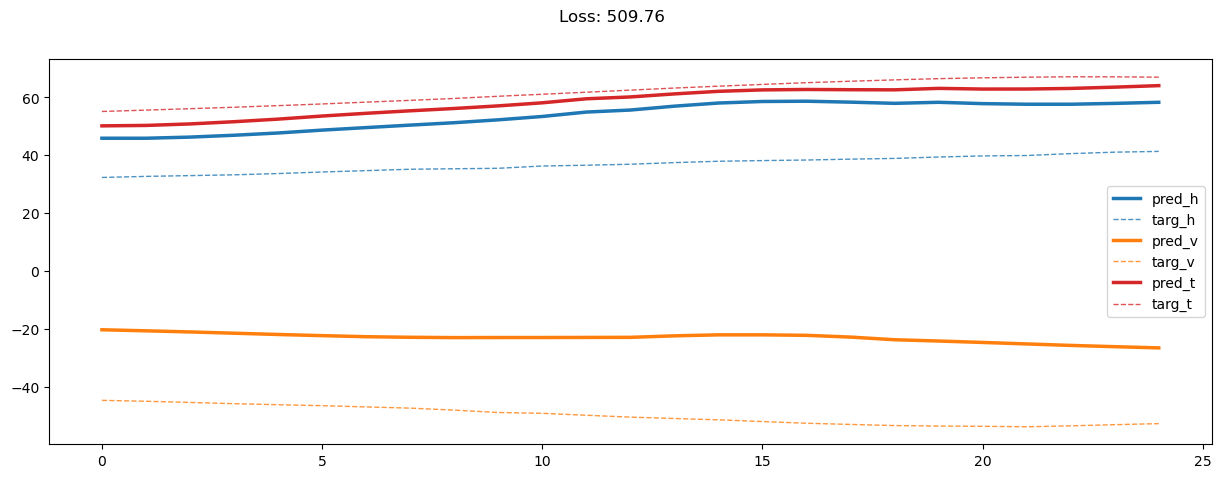

03400: train loss:  346.224, imu loss:  0.136, mag loss:  113.211, div loss:  228.474, slim:  3.969, tlim:  4.548
       valid loss:  351.797, imu loss:  0.104, mag loss:  186.838, div loss:  160.234, slim:  3.730, tlim:  4.918
03420: train loss:  337.566, imu loss:  0.136, mag loss:  111.890, div loss:  221.180, slim:  3.987, tlim:  4.485
       valid loss:  351.251, imu loss:  0.104, mag loss:  186.752, div loss:  159.745, slim:  3.777, tlim:  4.941
03440: train loss:  342.080, imu loss:  0.136, mag loss:  112.723, div loss:  224.833, slim:  3.965, tlim:  4.528
       valid loss:  354.566, imu loss:  0.104, mag loss:  189.176, div loss:  160.642, slim:  3.785, tlim:  4.930
03460: train loss:  347.613, imu loss:  0.136, mag loss:  113.458, div loss:  229.573, slim:  4.045, tlim:  4.580
       valid loss:  354.126, imu loss:  0.104, mag loss:  188.484, div loss:  160.874, slim:  3.786, tlim:  4.957
03480: train loss:  347.380, imu loss:  0.136, mag loss:  113.350, div loss:  229.535, s

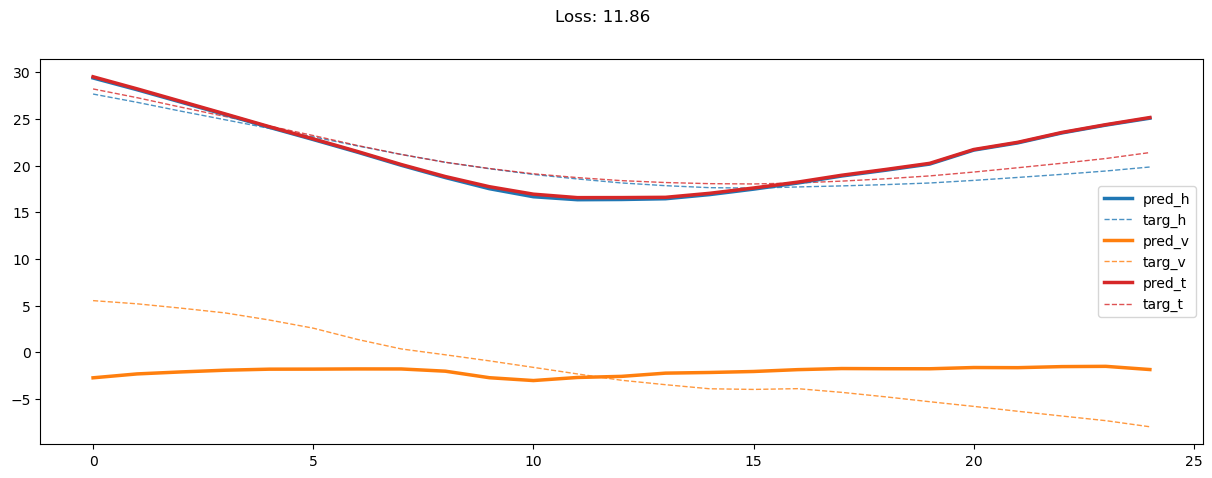

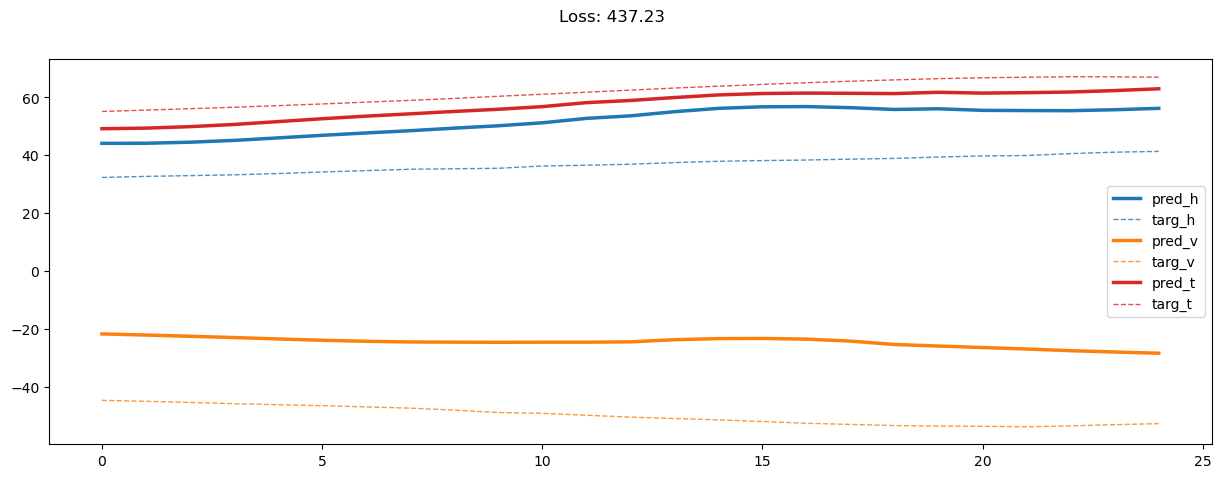

03600: train loss:  346.411, imu loss:  0.136, mag loss:  113.549, div loss:  228.337, slim:  3.977, tlim:  4.527
       valid loss:  355.275, imu loss:  0.104, mag loss:  187.696, div loss:  162.876, slim:  3.758, tlim:  4.880
03620: train loss:  343.641, imu loss:  0.137, mag loss:  113.210, div loss:  225.882, slim:  4.002, tlim:  4.549
       valid loss:  353.297, imu loss:  0.104, mag loss:  186.499, div loss:  162.047, slim:  3.801, tlim:  4.928
03640: train loss:  345.451, imu loss:  0.137, mag loss:  114.236, div loss:  226.727, slim:  3.953, tlim:  4.484
       valid loss:  352.495, imu loss:  0.104, mag loss:  185.606, div loss:  162.148, slim:  3.866, tlim:  4.895
03660: train loss:  342.310, imu loss:  0.136, mag loss:  112.896, div loss:  224.897, slim:  3.980, tlim:  4.514
       valid loss:  354.015, imu loss:  0.104, mag loss:  187.524, div loss:  161.715, slim:  3.826, tlim:  4.954
03680: train loss:  344.971, imu loss:  0.136, mag loss:  113.237, div loss:  227.176, s

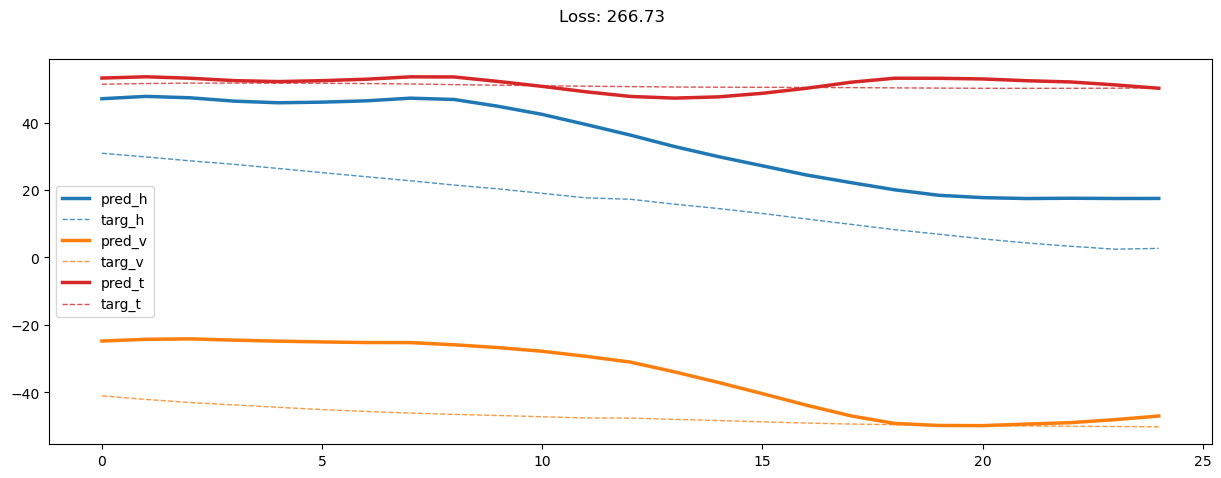

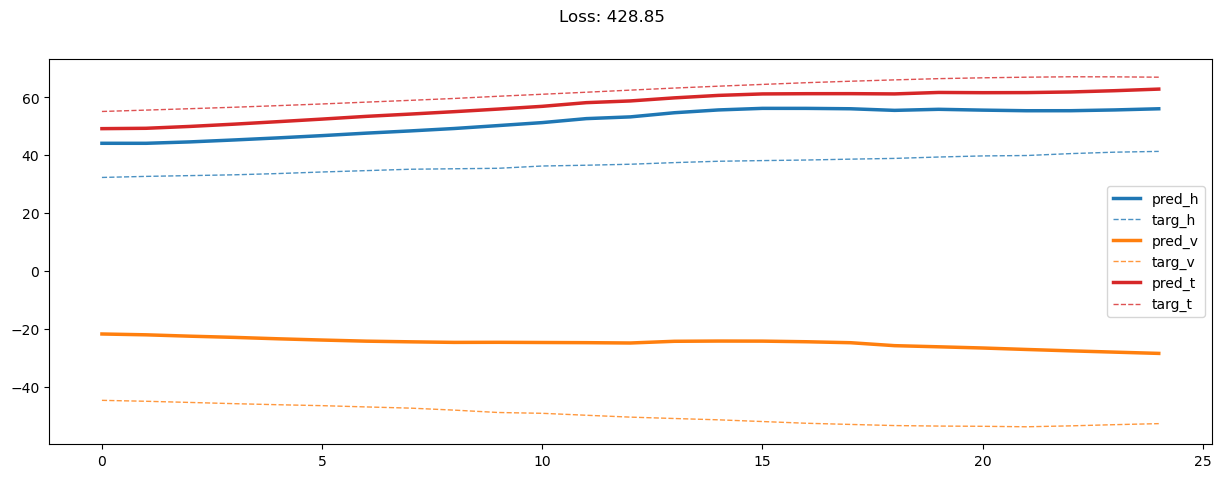

03800: train loss:  334.670, imu loss:  0.137, mag loss:  110.649, div loss:  219.475, slim:  3.996, tlim:  4.547
       valid loss:  354.915, imu loss:  0.104, mag loss:  187.007, div loss:  163.192, slim:  3.783, tlim:  4.889
03820: train loss:  336.881, imu loss:  0.137, mag loss:  110.964, div loss:  221.414, slim:  3.930, tlim:  4.511
       valid loss:  360.391, imu loss:  0.104, mag loss:  191.037, div loss:  164.660, slim:  3.741, tlim:  4.874
03840: train loss:  336.021, imu loss:  0.136, mag loss:  111.051, div loss:  220.483, slim:  3.955, tlim:  4.482
       valid loss:  354.777, imu loss:  0.104, mag loss:  188.226, div loss:  161.860, slim:  3.749, tlim:  4.866
03860: train loss:  335.258, imu loss:  0.137, mag loss:  110.464, div loss:  220.250, slim:  4.005, tlim:  4.541
       valid loss:  355.048, imu loss:  0.104, mag loss:  186.116, div loss:  164.241, slim:  3.772, tlim:  4.860
03880: train loss:  342.495, imu loss:  0.137, mag loss:  112.144, div loss:  225.785, s

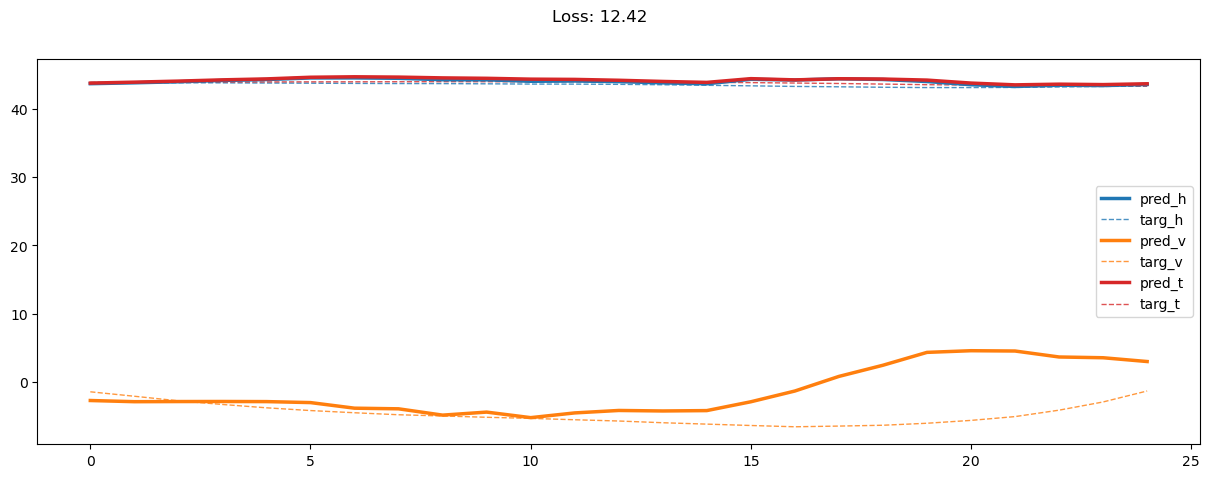

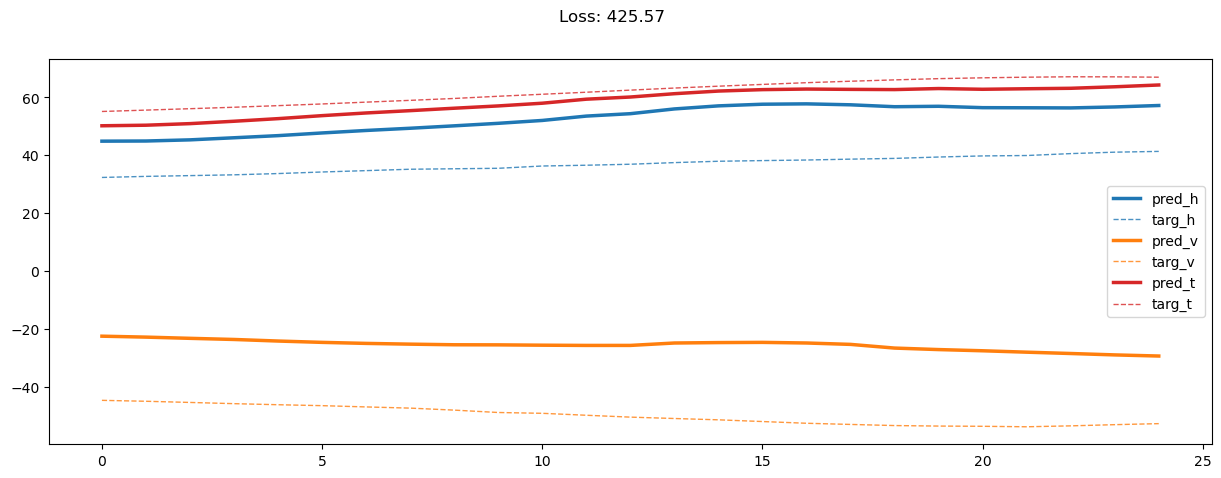

04000: train loss:  329.410, imu loss:  0.137, mag loss:  108.350, div loss:  216.528, slim:  4.027, tlim:  4.518
       valid loss:  360.119, imu loss:  0.104, mag loss:  189.029, div loss:  166.376, slim:  3.769, tlim:  4.892
04020: train loss:  334.056, imu loss:  0.136, mag loss:  109.706, div loss:  219.836, slim:  3.965, tlim:  4.515
       valid loss:  355.500, imu loss:  0.104, mag loss:  186.568, div loss:  164.195, slim:  3.796, tlim:  4.912
04040: train loss:  337.768, imu loss:  0.137, mag loss:  111.704, div loss:  221.528, slim:  4.001, tlim:  4.533
       valid loss:  360.038, imu loss:  0.104, mag loss:  190.950, div loss:  164.320, slim:  3.848, tlim:  4.937
04060: train loss:  331.331, imu loss:  0.136, mag loss:  109.321, div loss:  217.474, slim:  4.018, tlim:  4.527
       valid loss:  358.691, imu loss:  0.104, mag loss:  186.644, div loss:  167.367, slim:  3.761, tlim:  4.848
04080: train loss:  335.945, imu loss:  0.136, mag loss:  110.272, div loss:  221.140, s

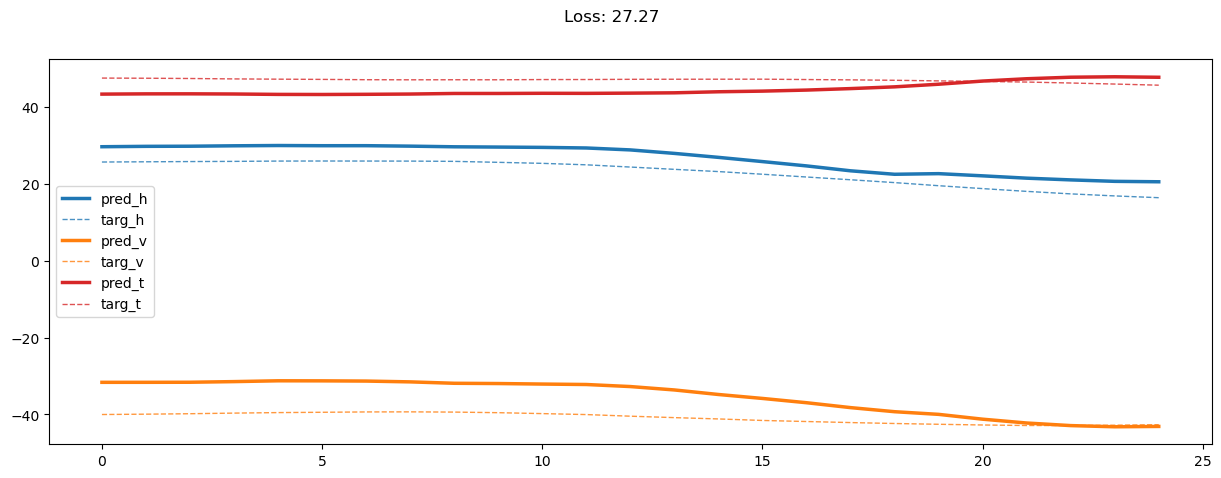

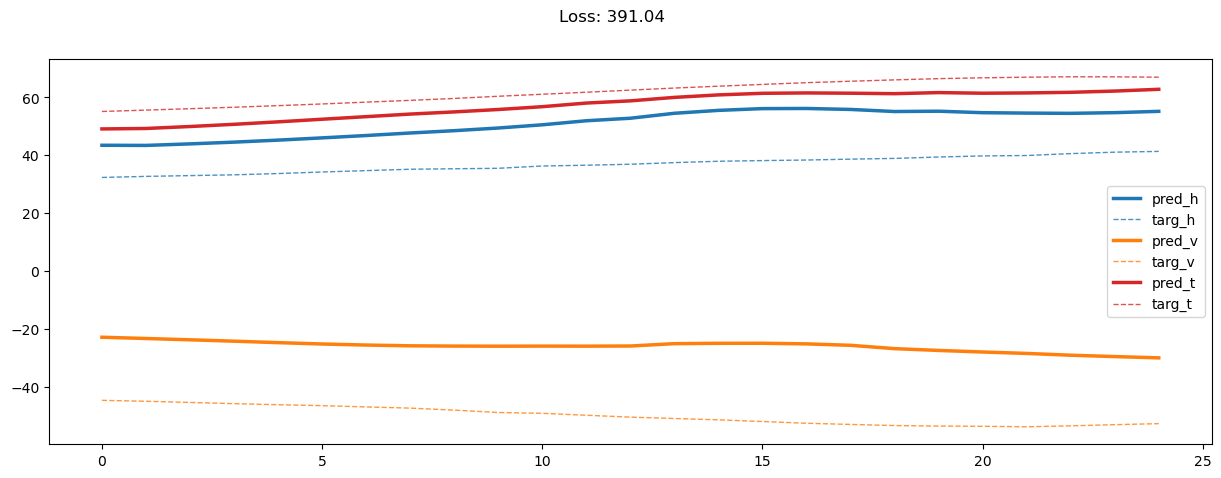

04200: train loss:  331.413, imu loss:  0.136, mag loss:  108.550, div loss:  218.298, slim:  4.045, tlim:  4.558
       valid loss:  365.020, imu loss:  0.104, mag loss:  189.866, div loss:  170.451, slim:  3.764, tlim:  4.879
04220: train loss:  335.585, imu loss:  0.136, mag loss:  109.316, div loss:  221.784, slim:  3.934, tlim:  4.486
       valid loss:  360.303, imu loss:  0.104, mag loss:  188.381, div loss:  167.200, slim:  3.798, tlim:  4.893
04240: train loss:  333.233, imu loss:  0.136, mag loss:  108.791, div loss:  219.905, slim:  3.980, tlim:  4.542
       valid loss:  362.245, imu loss:  0.104, mag loss:  189.162, div loss:  168.381, slim:  3.793, tlim:  4.866
04260: train loss:  331.370, imu loss:  0.136, mag loss:  109.086, div loss:  217.709, slim:  4.044, tlim:  4.569
       valid loss:  363.303, imu loss:  0.104, mag loss:  188.936, div loss:  169.692, slim:  3.740, tlim:  4.849
04280: train loss:  330.178, imu loss:  0.136, mag loss:  108.390, div loss:  217.294, s

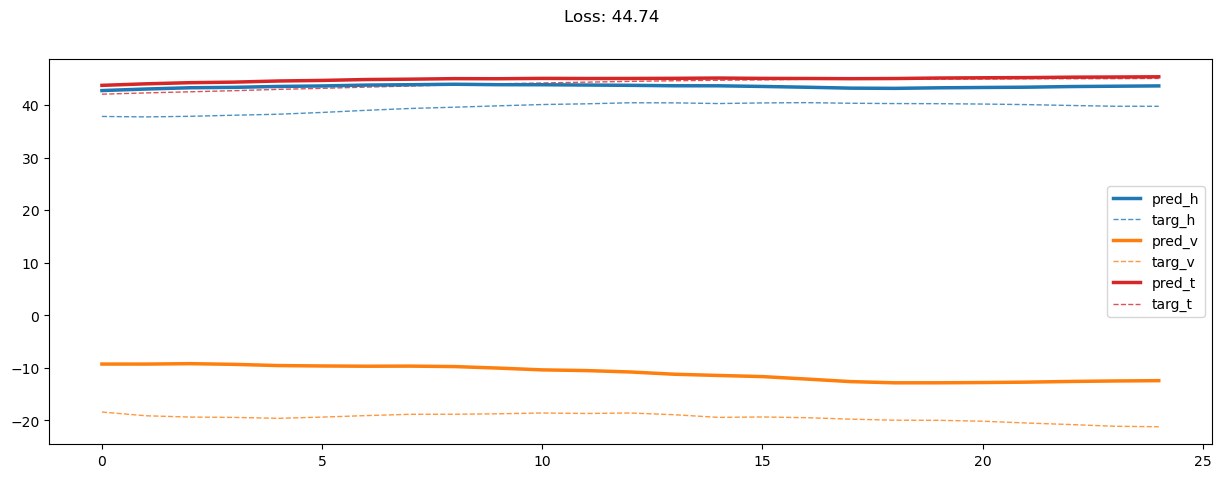

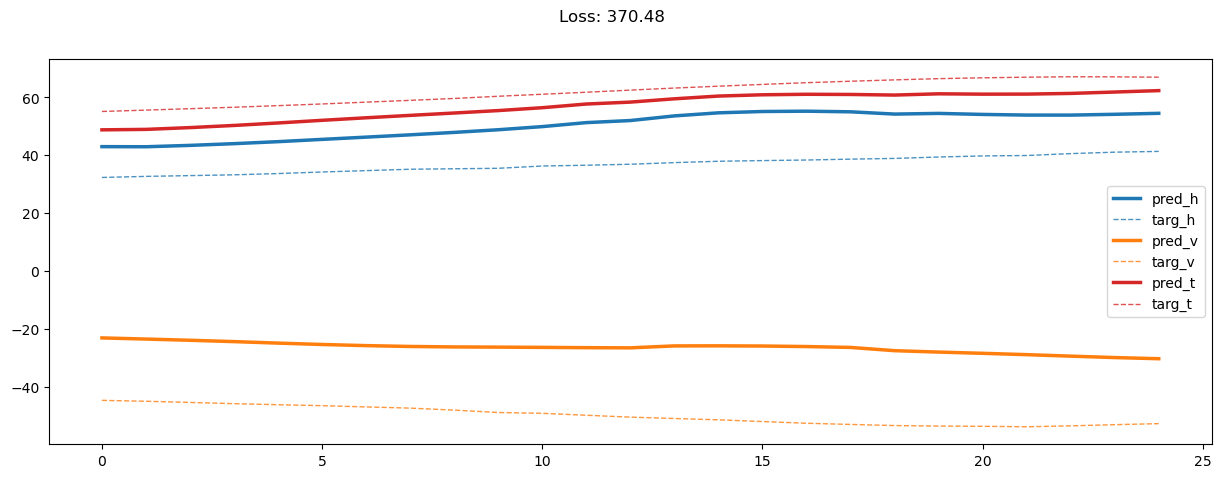

04400: train loss:  329.248, imu loss:  0.136, mag loss:  107.429, div loss:  217.218, slim:  4.112, tlim:  4.582
       valid loss:  365.551, imu loss:  0.104, mag loss:  190.704, div loss:  170.203, slim:  3.678, tlim:  4.828
04420: train loss:  330.923, imu loss:  0.137, mag loss:  108.494, div loss:  217.886, slim:  4.022, tlim:  4.535
       valid loss:  364.759, imu loss:  0.104, mag loss:  188.026, div loss:  172.045, slim:  3.738, tlim:  4.868
04440: train loss:  330.945, imu loss:  0.137, mag loss:  109.069, div loss:  217.394, slim:  3.956, tlim:  4.475
       valid loss:  359.240, imu loss:  0.104, mag loss:  187.571, div loss:  167.021, slim:  3.695, tlim:  4.828
04460: train loss:  329.571, imu loss:  0.137, mag loss:  108.581, div loss:  216.522, slim:  3.926, tlim:  4.466
       valid loss:  359.238, imu loss:  0.104, mag loss:  187.182, div loss:  167.365, slim:  3.795, tlim:  4.851
04480: train loss:  325.432, imu loss:  0.136, mag loss:  108.757, div loss:  212.122, s

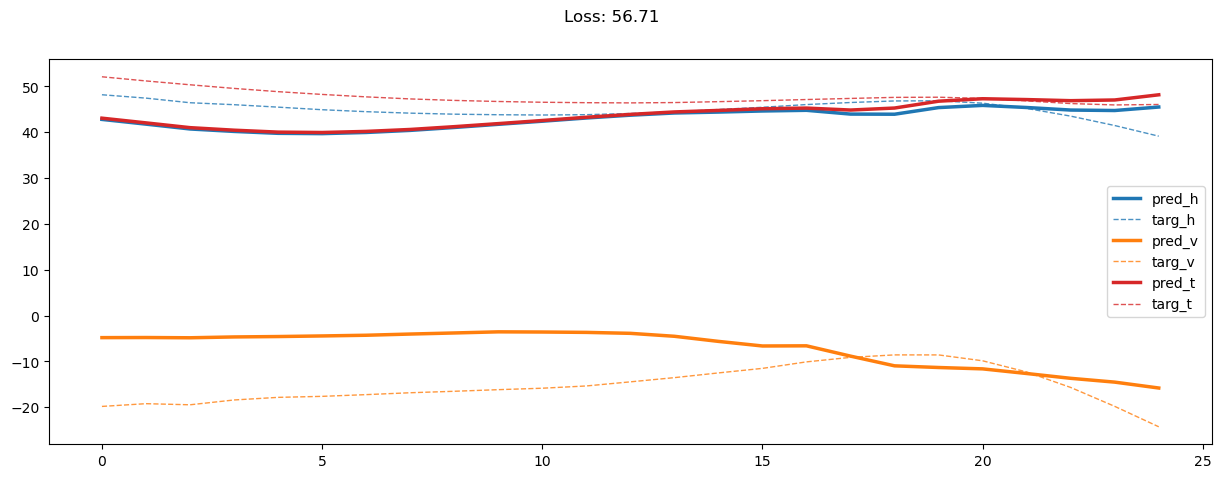

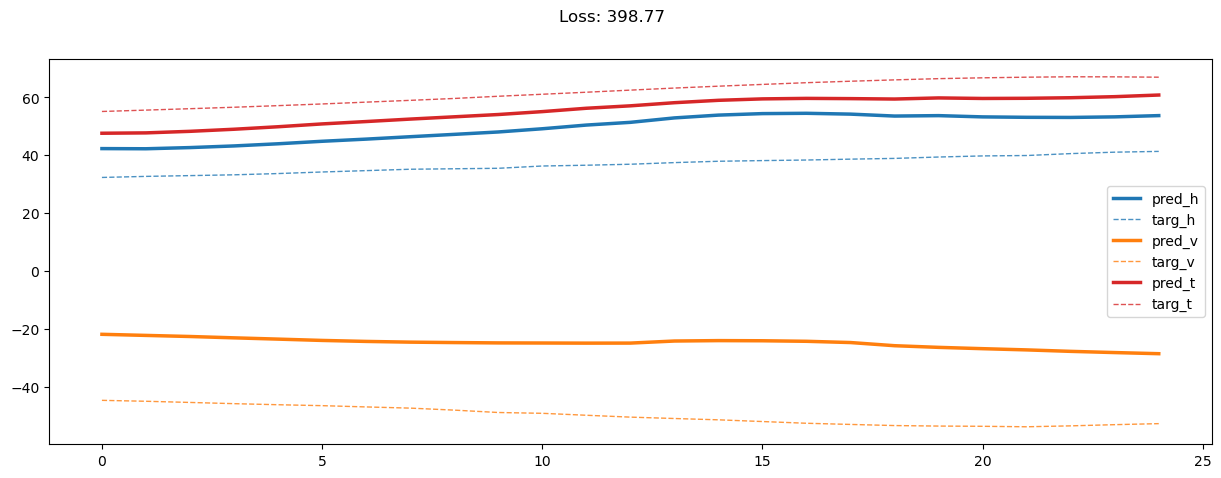

04600: train loss:  328.969, imu loss:  0.137, mag loss:  107.666, div loss:  216.767, slim:  4.014, tlim:  4.527
       valid loss:  364.091, imu loss:  0.104, mag loss:  188.451, div loss:  170.895, slim:  3.885, tlim:  4.894
04620: train loss:  322.130, imu loss:  0.136, mag loss:  107.065, div loss:  210.575, slim:  3.959, tlim:  4.486
       valid loss:  359.134, imu loss:  0.103, mag loss:  185.558, div loss:  168.863, slim:  3.825, tlim:  4.871
04640: train loss:  324.929, imu loss:  0.137, mag loss:  106.833, div loss:  213.572, slim:  4.045, tlim:  4.502
       valid loss:  359.033, imu loss:  0.104, mag loss:  186.597, div loss:  167.776, slim:  3.750, tlim:  4.825
04660: train loss:  323.373, imu loss:  0.136, mag loss:  107.049, div loss:  211.846, slim:  3.961, tlim:  4.469
       valid loss:  365.770, imu loss:  0.104, mag loss:  188.639, div loss:  172.448, slim:  3.790, tlim:  4.843
04680: train loss:  327.080, imu loss:  0.136, mag loss:  106.610, div loss:  215.904, s

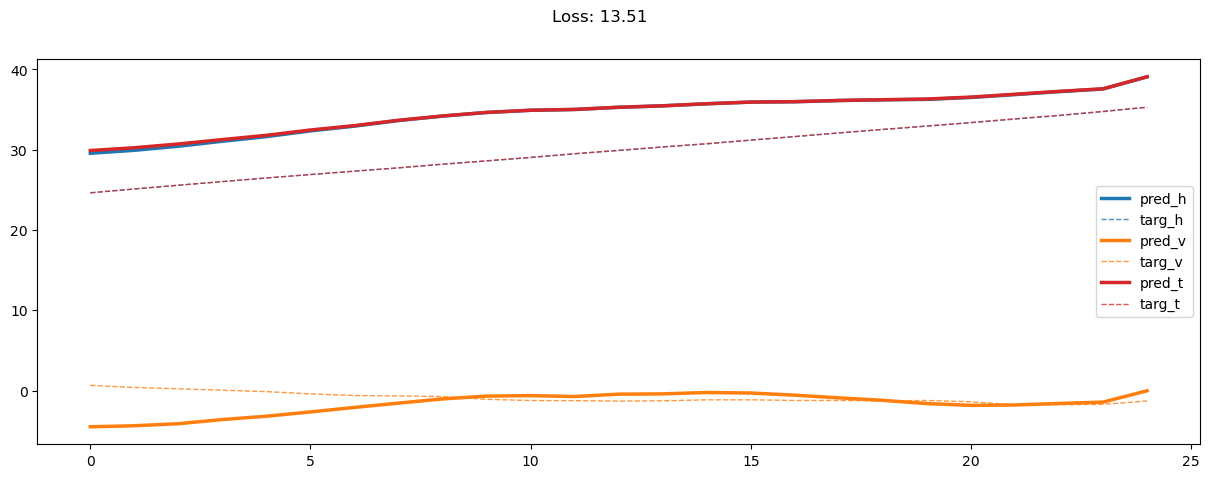

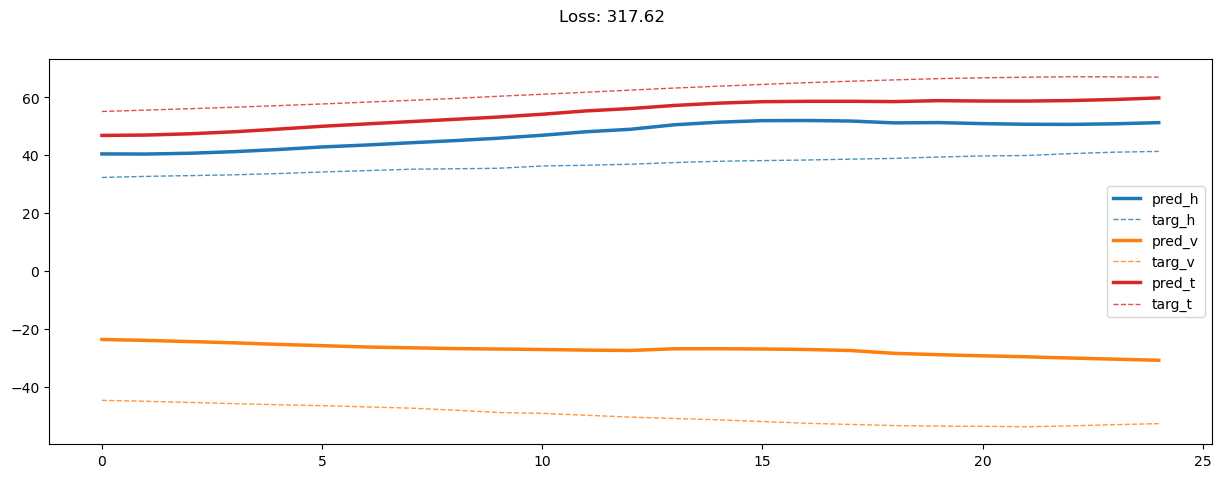

04800: train loss:  322.264, imu loss:  0.136, mag loss:  106.516, div loss:  211.302, slim:  3.935, tlim:  4.434
       valid loss:  368.348, imu loss:  0.104, mag loss:  189.779, div loss:  173.829, slim:  3.870, tlim:  4.892
04820: train loss:  324.065, imu loss:  0.137, mag loss:  105.981, div loss:  213.532, slim:  4.014, tlim:  4.550
       valid loss:  365.730, imu loss:  0.104, mag loss:  190.055, div loss:  170.972, slim:  3.796, tlim:  4.867
04840: train loss:  323.521, imu loss:  0.136, mag loss:  106.818, div loss:  212.156, slim:  4.040, tlim:  4.535
       valid loss:  366.354, imu loss:  0.104, mag loss:  190.873, div loss:  170.841, slim:  3.714, tlim:  4.809
04860: train loss:  319.887, imu loss:  0.136, mag loss:  105.226, div loss:  210.195, slim:  3.917, tlim:  4.468
       valid loss:  362.926, imu loss:  0.104, mag loss:  188.137, div loss:  170.053, slim:  3.887, tlim:  4.881
04880: train loss:  328.736, imu loss:  0.136, mag loss:  108.257, div loss:  215.956, s

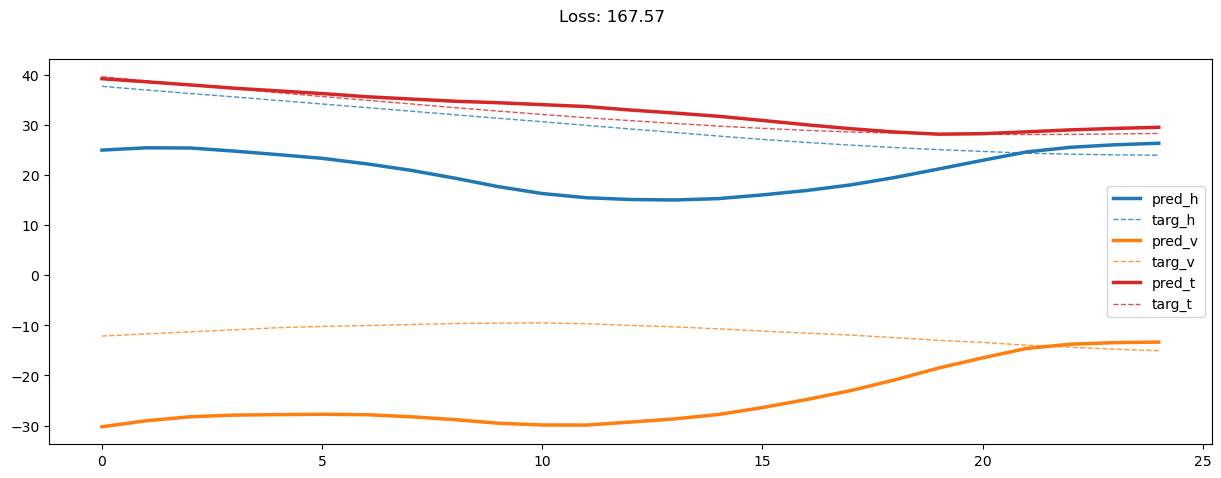

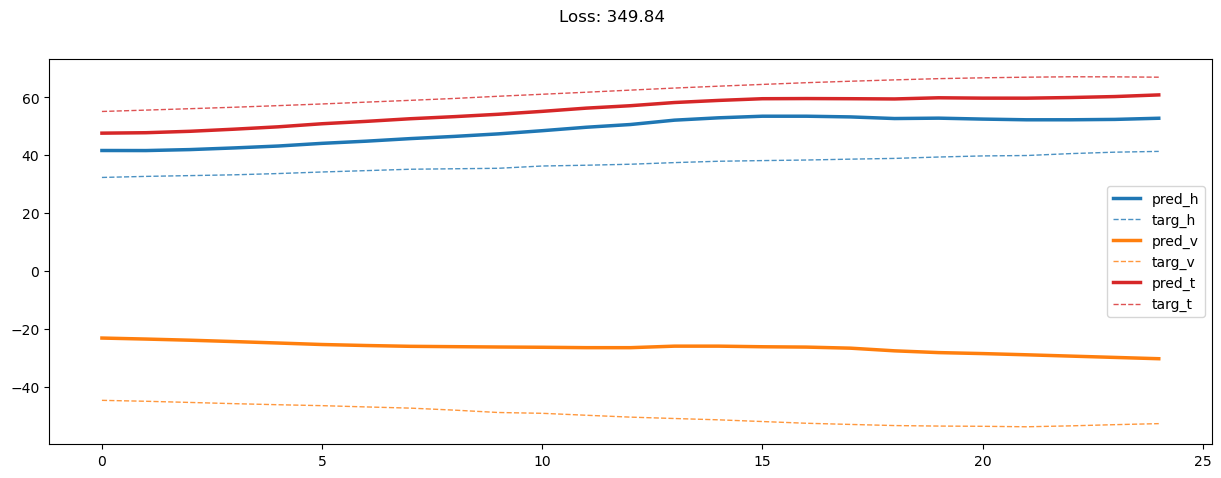

05000: train loss:  322.860, imu loss:  0.136, mag loss:  106.136, div loss:  212.208, slim:  3.988, tlim:  4.509
       valid loss:  369.351, imu loss:  0.103, mag loss:  190.472, div loss:  174.209, slim:  3.706, tlim:  4.854
05020: train loss:  324.436, imu loss:  0.136, mag loss:  106.648, div loss:  213.267, slim:  4.029, tlim:  4.503
       valid loss:  370.506, imu loss:  0.104, mag loss:  190.926, div loss:  174.857, slim:  3.866, tlim:  4.871
05040: train loss:  320.152, imu loss:  0.136, mag loss:  105.757, div loss:  209.946, slim:  3.919, tlim:  4.443
       valid loss:  361.181, imu loss:  0.103, mag loss:  186.843, div loss:  169.628, slim:  3.839, tlim:  4.863
05060: train loss:  317.212, imu loss:  0.137, mag loss:  104.055, div loss:  208.653, slim:  4.015, tlim:  4.484
       valid loss:  368.457, imu loss:  0.103, mag loss:  189.779, div loss:  174.025, slim:  3.788, tlim:  4.803
05080: train loss:  321.047, imu loss:  0.136, mag loss:  106.149, div loss:  210.390, s

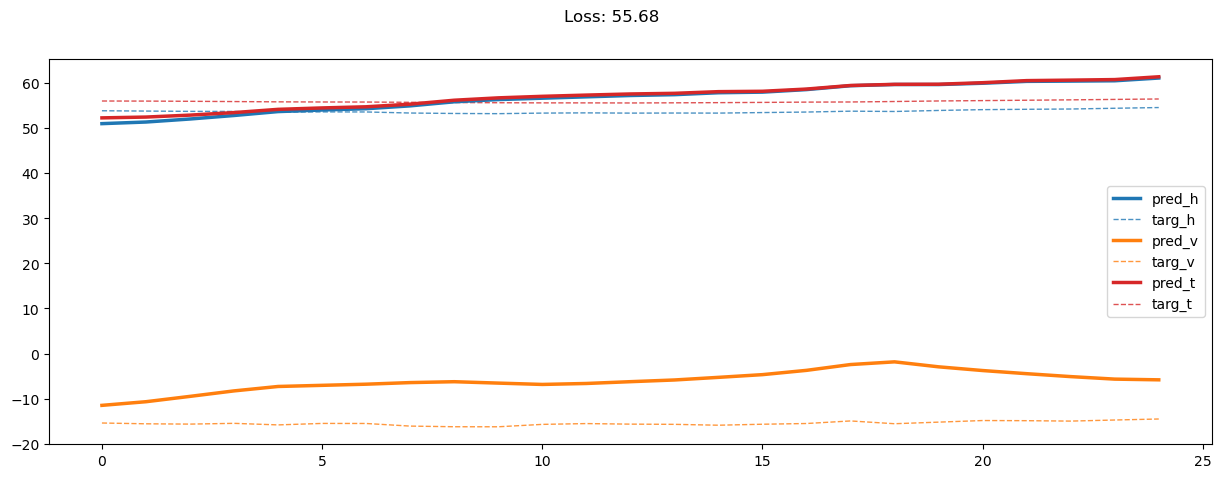

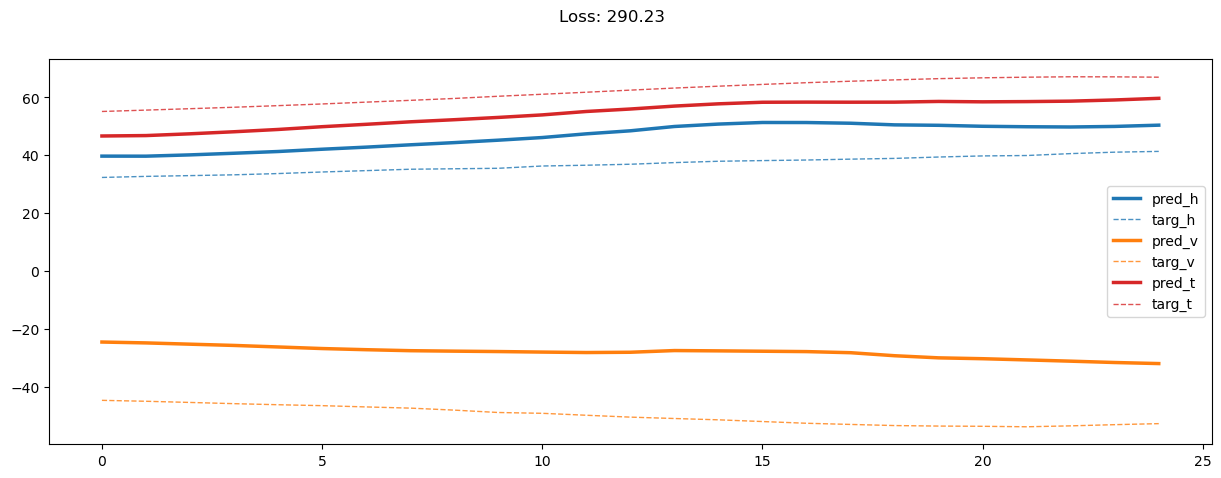

05200: train loss:  316.019, imu loss:  0.137, mag loss:  103.943, div loss:  207.611, slim:  3.943, tlim:  4.457
       valid loss:  363.410, imu loss:  0.104, mag loss:  186.604, div loss:  172.081, slim:  3.923, tlim:  4.855
05220: train loss:  318.253, imu loss:  0.136, mag loss:  104.327, div loss:  209.423, slim:  4.005, tlim:  4.487
       valid loss:  365.272, imu loss:  0.104, mag loss:  187.168, div loss:  173.385, slim:  3.852, tlim:  4.869
05240: train loss:  315.335, imu loss:  0.136, mag loss:  103.804, div loss:  207.074, slim:  3.936, tlim:  4.449
       valid loss:  371.925, imu loss:  0.103, mag loss:  190.953, div loss:  176.280, slim:  3.799, tlim:  4.851
05260: train loss:  313.364, imu loss:  0.136, mag loss:  103.337, div loss:  205.576, slim:  3.920, tlim:  4.448
       valid loss:  371.709, imu loss:  0.103, mag loss:  191.413, div loss:  175.598, slim:  3.827, tlim:  4.851
05280: train loss:  319.601, imu loss:  0.136, mag loss:  104.696, div loss:  210.404, s

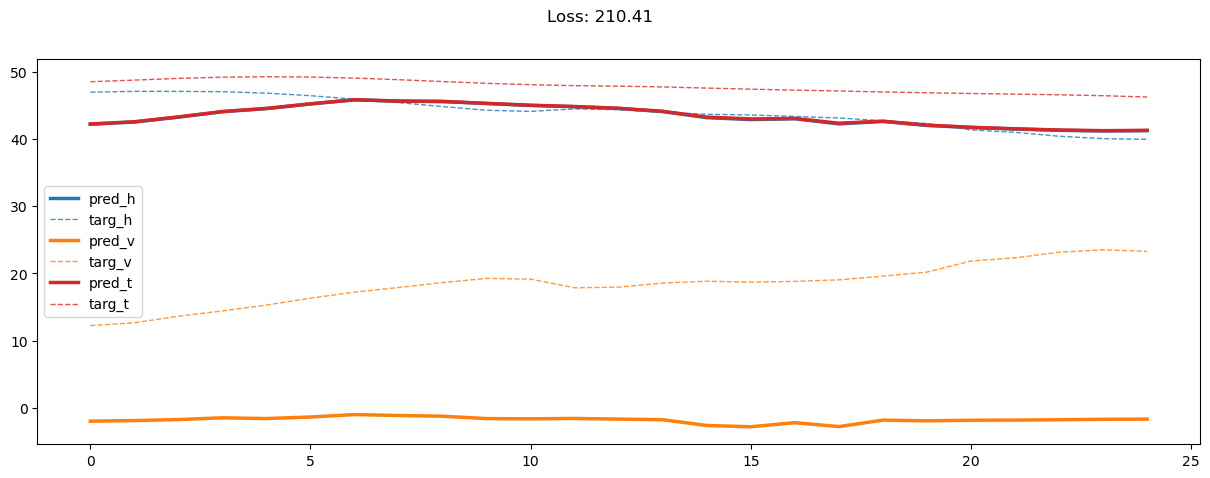

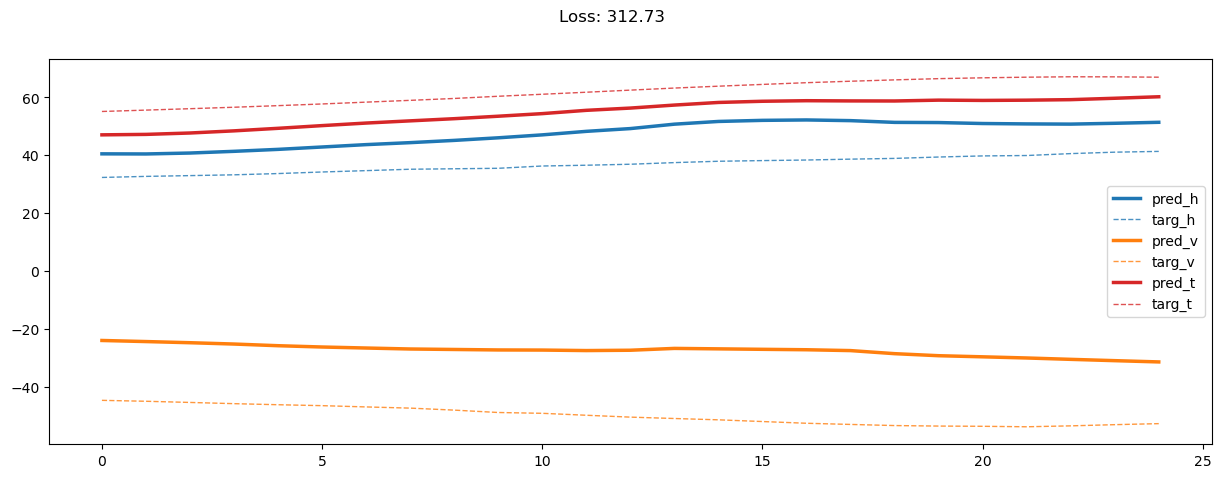

05400: train loss:  312.814, imu loss:  0.136, mag loss:  103.748, div loss:  204.587, slim:  3.978, tlim:  4.465
       valid loss:  366.076, imu loss:  0.103, mag loss:  187.308, div loss:  174.046, slim:  3.901, tlim:  4.858
05420: train loss:  313.661, imu loss:  0.137, mag loss:  103.457, div loss:  205.716, slim:  3.962, tlim:  4.480
       valid loss:  371.440, imu loss:  0.103, mag loss:  191.266, div loss:  175.504, slim:  3.763, tlim:  4.834
05440: train loss:  317.263, imu loss:  0.136, mag loss:  103.955, div loss:  208.826, slim:  3.957, tlim:  4.475
       valid loss:  371.494, imu loss:  0.103, mag loss:  191.498, div loss:  175.374, slim:  3.697, tlim:  4.793
05460: train loss:  310.630, imu loss:  0.136, mag loss:  102.054, div loss:  204.083, slim:  4.005, tlim:  4.475
       valid loss:  369.794, imu loss:  0.103, mag loss:  189.335, div loss:  175.796, slim:  3.852, tlim:  4.795
05480: train loss:  314.938, imu loss:  0.136, mag loss:  104.014, div loss:  206.412, s

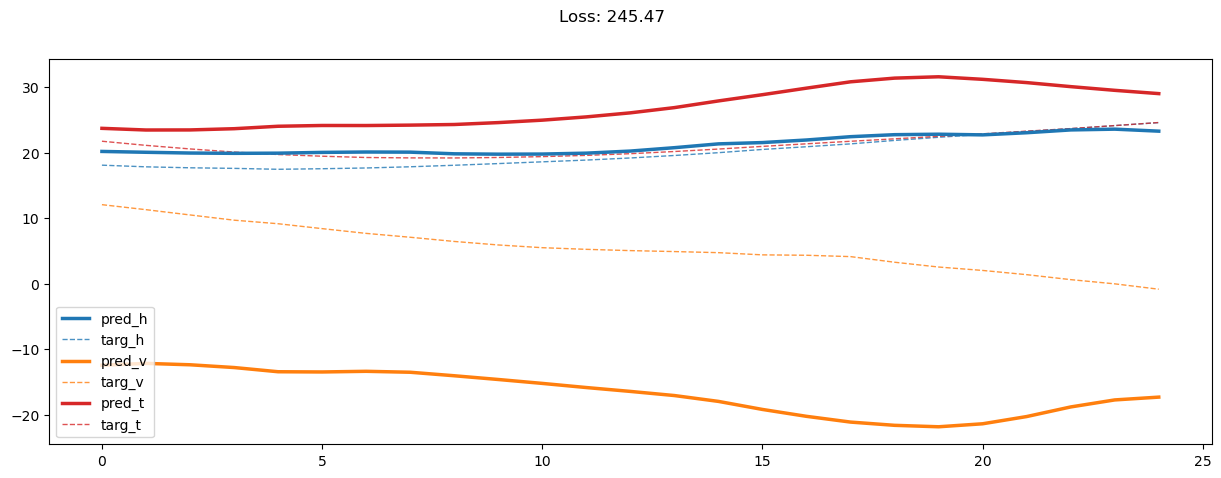

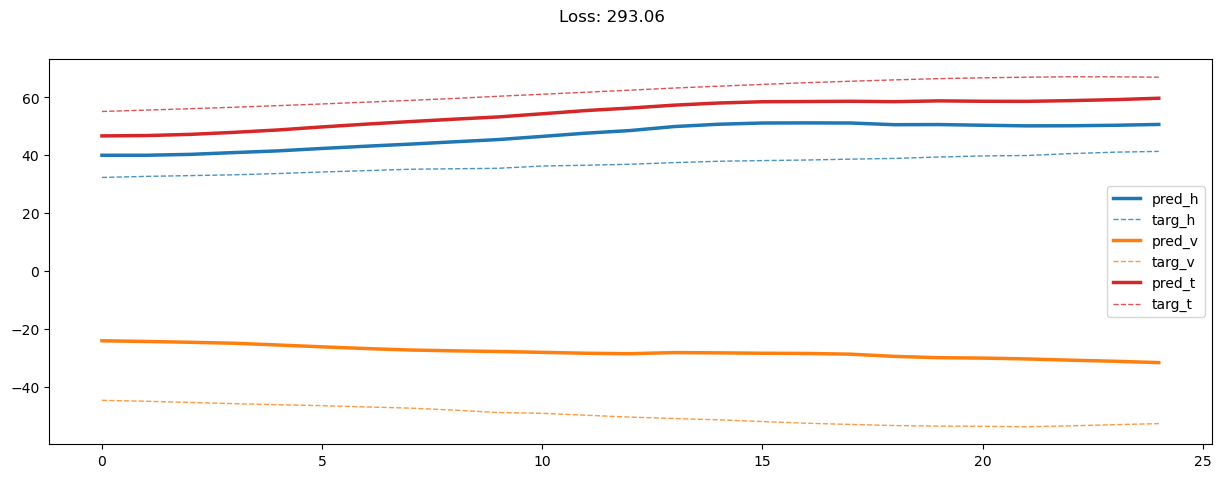

05600: train loss:  315.001, imu loss:  0.136, mag loss:  102.861, div loss:  207.693, slim:  3.926, tlim:  4.440
       valid loss:  366.772, imu loss:  0.103, mag loss:  186.385, div loss:  175.709, slim:  3.846, tlim:  4.818
05620: train loss:  309.535, imu loss:  0.136, mag loss:  101.899, div loss:  203.180, slim:  3.911, tlim:  4.456
       valid loss:  373.760, imu loss:  0.103, mag loss:  190.468, div loss:  178.589, slim:  3.906, tlim:  4.831
05640: train loss:  309.513, imu loss:  0.138, mag loss:  101.723, div loss:  203.314, slim:  3.970, tlim:  4.462
       valid loss:  372.992, imu loss:  0.103, mag loss:  188.313, div loss:  180.047, slim:  3.746, tlim:  4.789
05660: train loss:  310.145, imu loss:  0.136, mag loss:  102.900, div loss:  202.736, slim:  4.008, tlim:  4.493
       valid loss:  374.574, imu loss:  0.103, mag loss:  190.166, div loss:  179.705, slim:  3.824, tlim:  4.858
05680: train loss:  311.640, imu loss:  0.136, mag loss:  102.733, div loss:  204.425, s

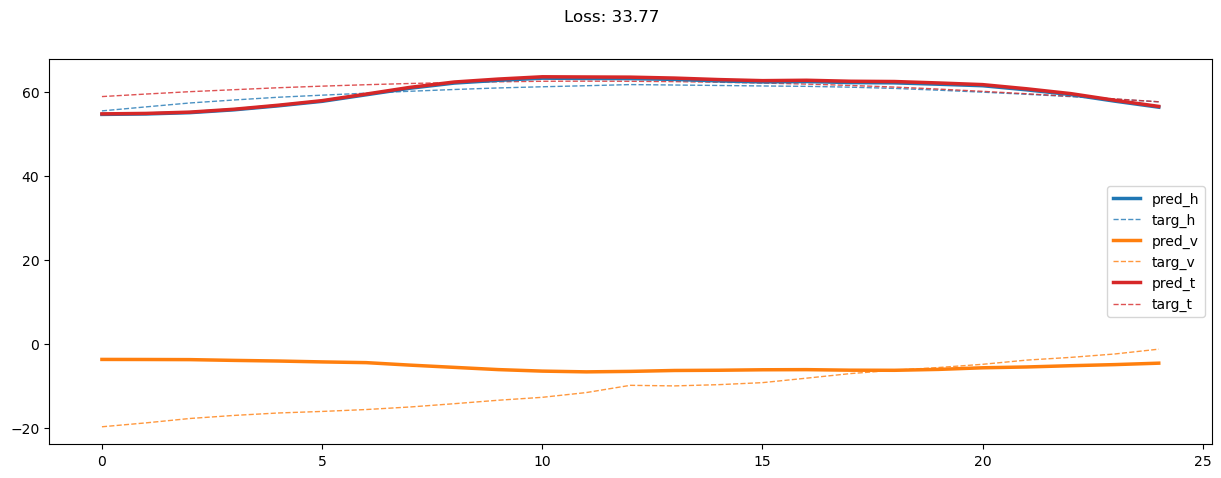

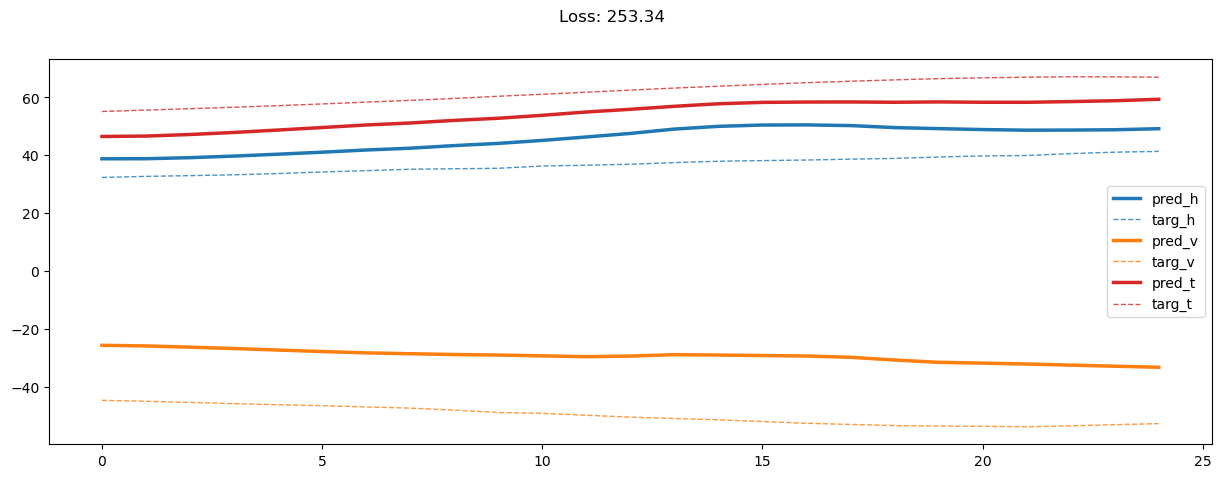

05800: train loss:  309.757, imu loss:  0.136, mag loss:  101.686, div loss:  203.571, slim:  3.983, tlim:  4.490
       valid loss:  373.562, imu loss:  0.103, mag loss:  191.198, div loss:  177.679, slim:  3.864, tlim:  4.821
05820: train loss:  309.199, imu loss:  0.136, mag loss:  102.423, div loss:  202.295, slim:  3.961, tlim:  4.472
       valid loss:  377.783, imu loss:  0.103, mag loss:  193.482, div loss:  179.684, slim:  3.756, tlim:  4.765
05840: train loss:  307.657, imu loss:  0.136, mag loss:  100.930, div loss:  202.281, slim:  3.940, tlim:  4.432
       valid loss:  371.093, imu loss:  0.103, mag loss:  189.579, div loss:  176.816, slim:  3.824, tlim:  4.852
05860: train loss:  308.682, imu loss:  0.137, mag loss:  100.648, div loss:  203.521, slim:  4.032, tlim:  4.491
       valid loss:  374.250, imu loss:  0.103, mag loss:  190.012, div loss:  179.613, slim:  3.692, tlim:  4.799
05880: train loss:  307.332, imu loss:  0.136, mag loss:  100.819, div loss:  202.071, s

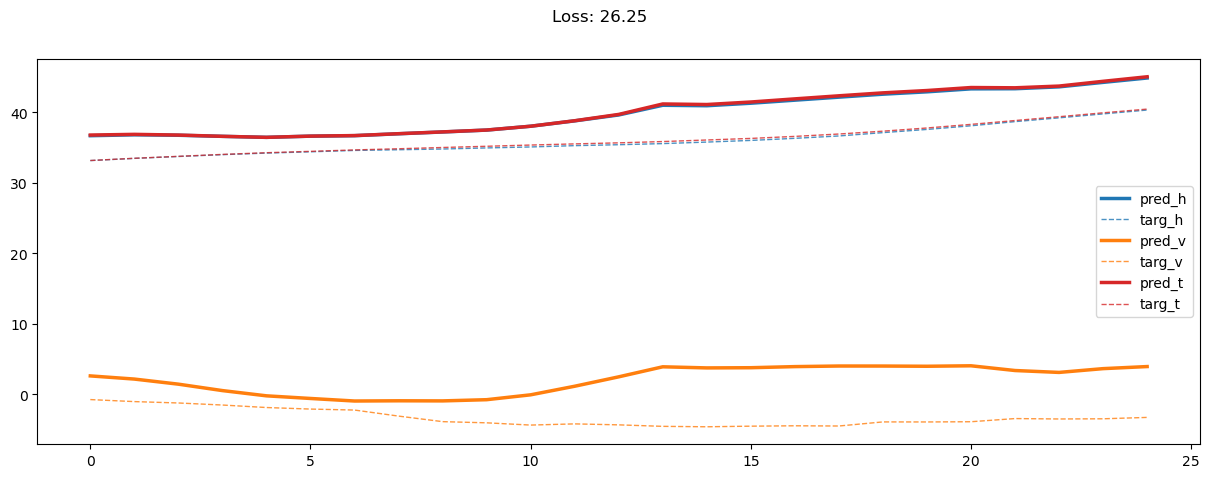

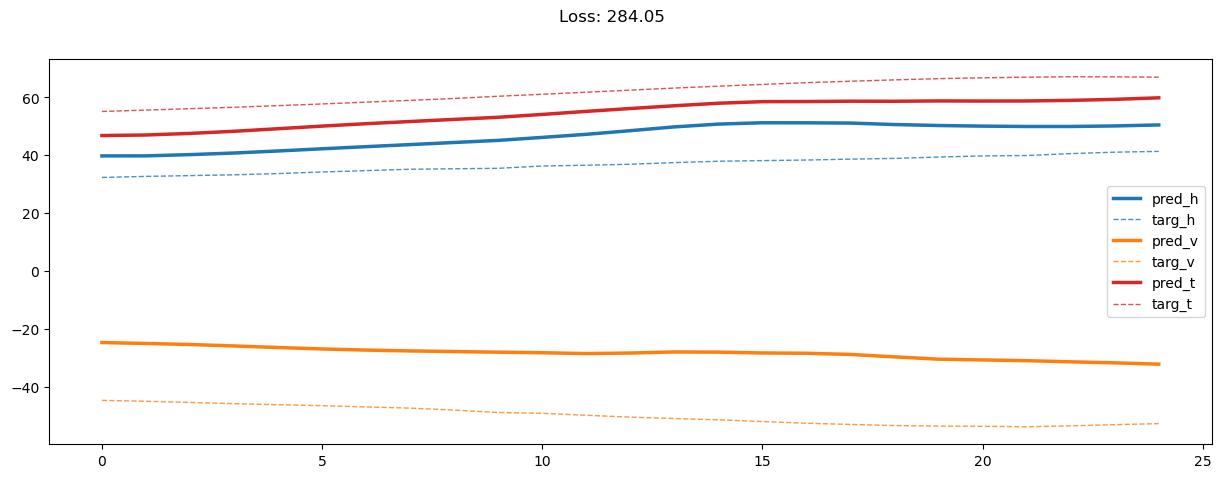

06000: train loss:  301.088, imu loss:  0.137, mag loss:  98.792, div loss:  197.857, slim:  3.964, tlim:  4.414
       valid loss:  379.177, imu loss:  0.103, mag loss:  191.630, div loss:  182.780, slim:  3.998, tlim:  4.885


In [57]:
draw = True

for epoch in range(6000):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}, slim: {tlim_loss[0]: 2.3f}, tlim: {tlim_loss[1]: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}, slim: {vlim_loss[0]: 2.3f}, tlim: {vlim_loss[1]: 2.3f}')

In [44]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 10:12]
            source_total_mag = source_data[:, :, 10]
            source_angle = source_data[:, :, 6]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :6]
            target_mag = target_data[:, :, 10:12]
            target_total_mag = target_data[:, :, 10]
            target_angle = source_data[:, :, 6]
            
            st_angle = torch.concat((source_angle[:, :, None], target_angle[:, :, None]), dim=-1)

            # generate mag
            source_pred_class, source_pred_one_hot = classifier.predict_label(source_imu)
            z_imu, predict_mag = model(source_imu, source_mag, source_pred_one_hot, st_angle)


            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 2) - target_mag.reshape(len(target_mag), -1, 2), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [47]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 2)
    targ_mag = result[1].reshape(-1, 2)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['h', 'v'], ['tab:blue', 'tab:orange']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(8973, 2) (8973,)
           loss name|   diff h   diff v      avg
   front_pocket loss:    89.99   123.86   106.93
         pocket loss:    80.28   146.98   113.63
          swing loss:   107.00   215.78   161.39
        average loss:    92.24   161.31   126.77


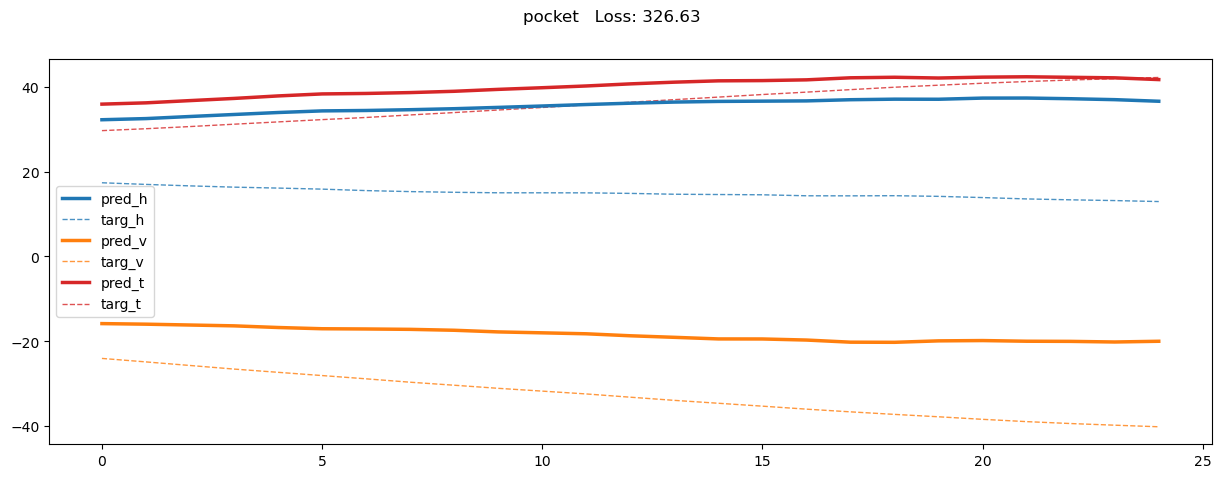

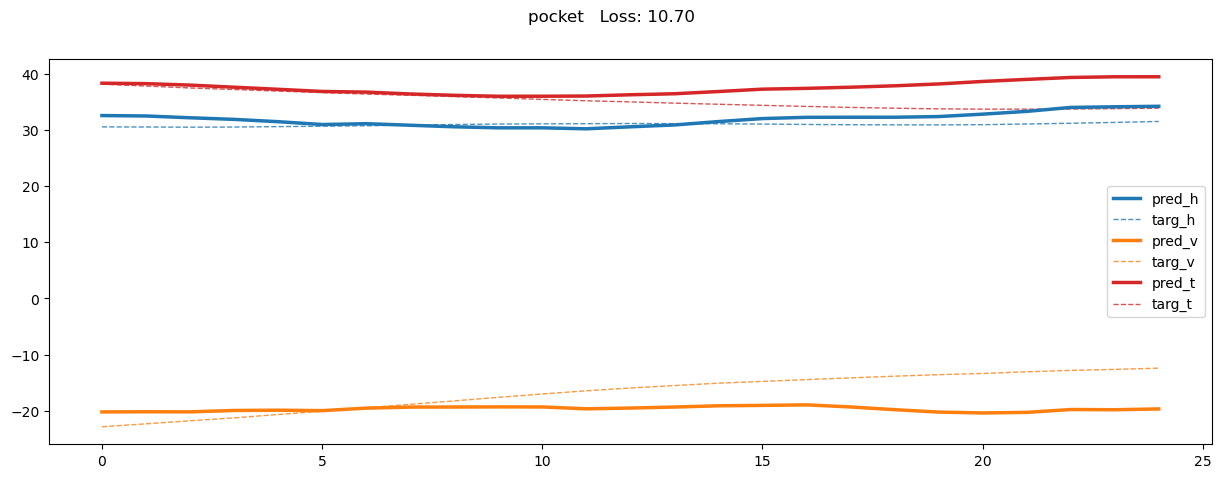

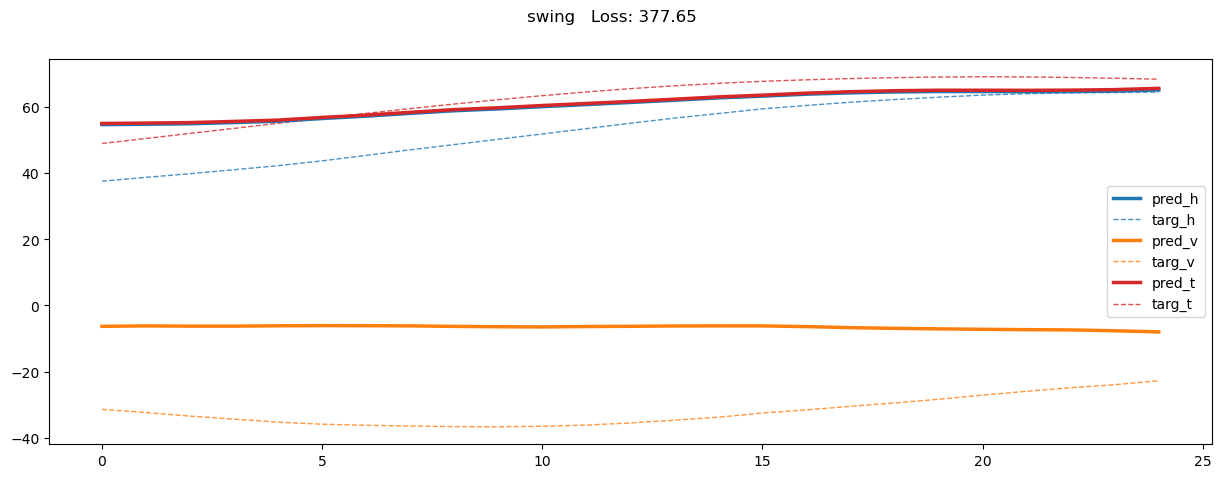

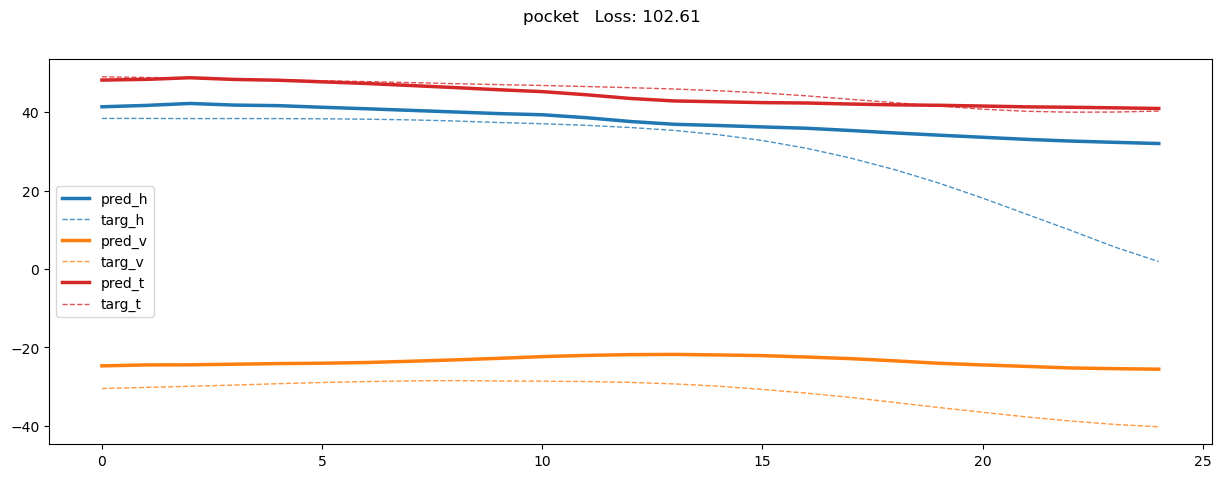

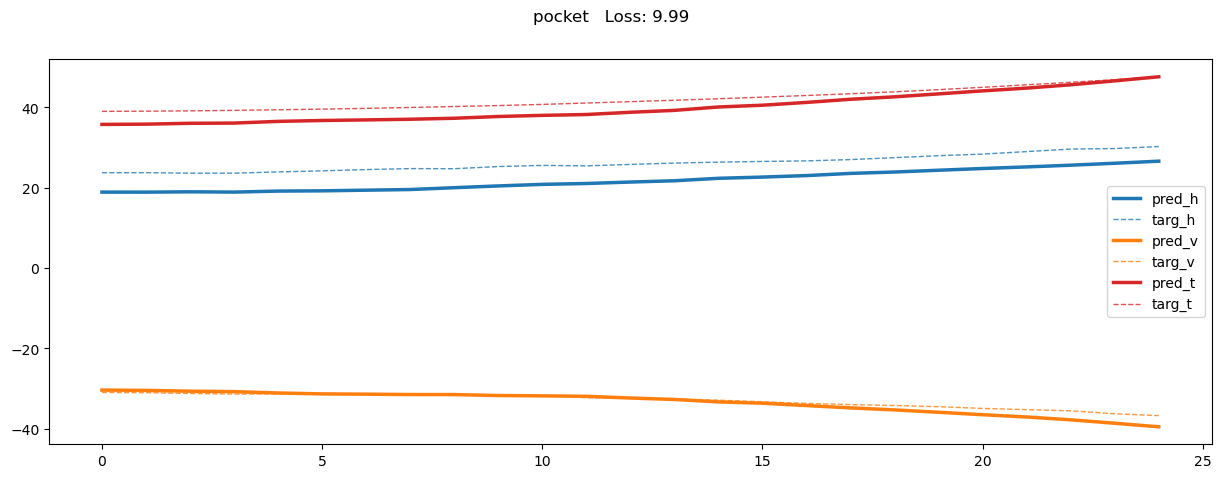

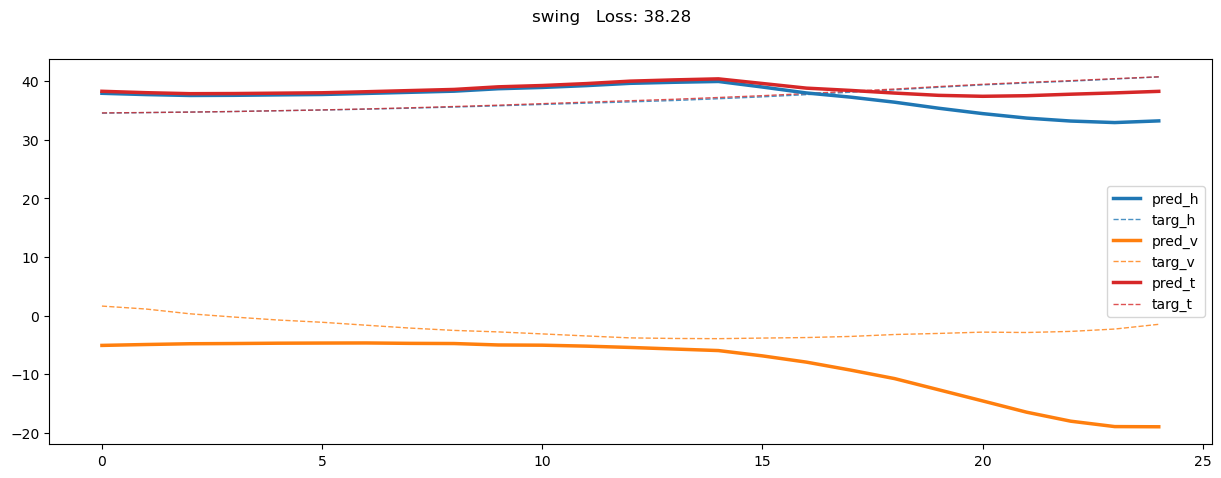

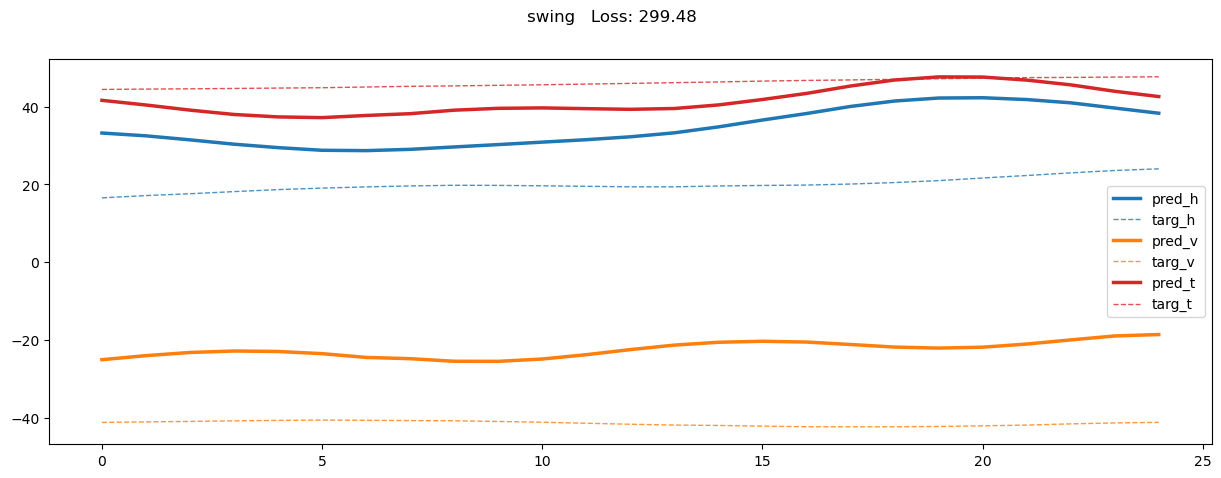

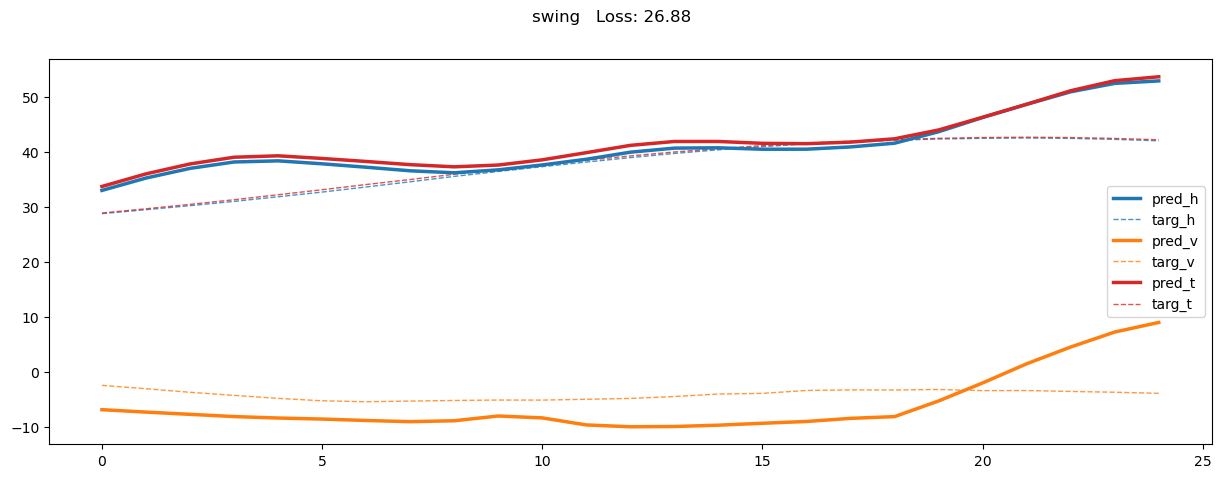

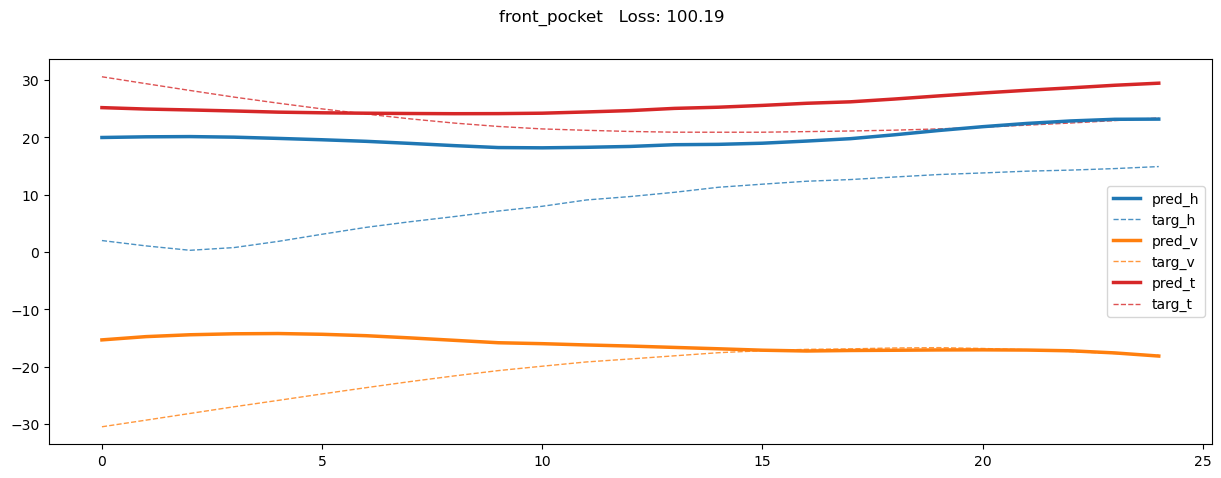

In [53]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff h":>8} {"diff v":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
dx, dy = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

for rs in results[::1000]:
    plot_result(rs)

(1273, 2) (1273,)
           loss name|   diff h   diff v      avg
   front_pocket loss:   108.43   156.55   132.49
         pocket loss:   114.26   223.82   169.04
          swing loss:   147.45   300.37   223.91
        average loss:   122.99   224.42   173.71


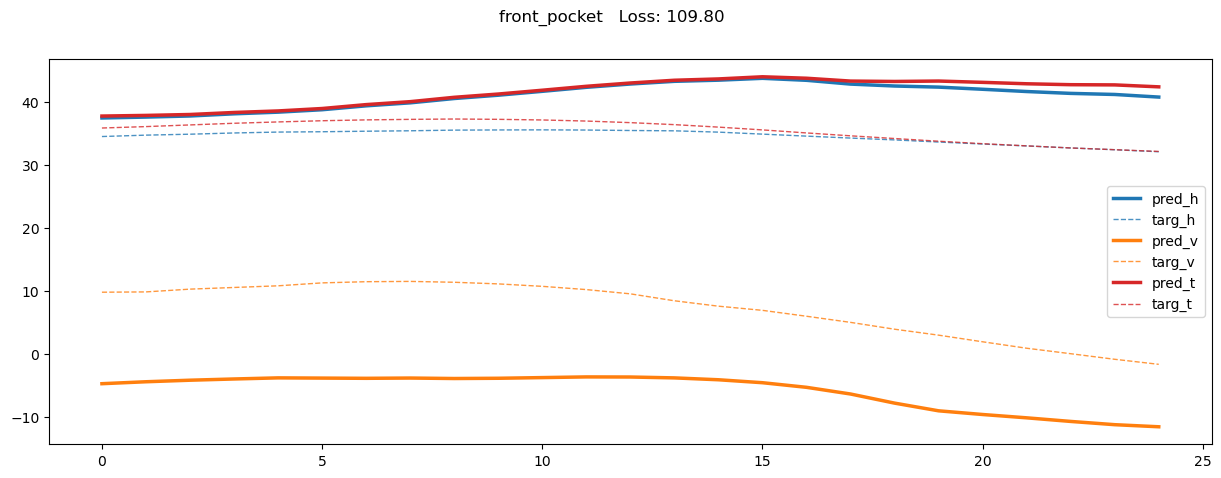

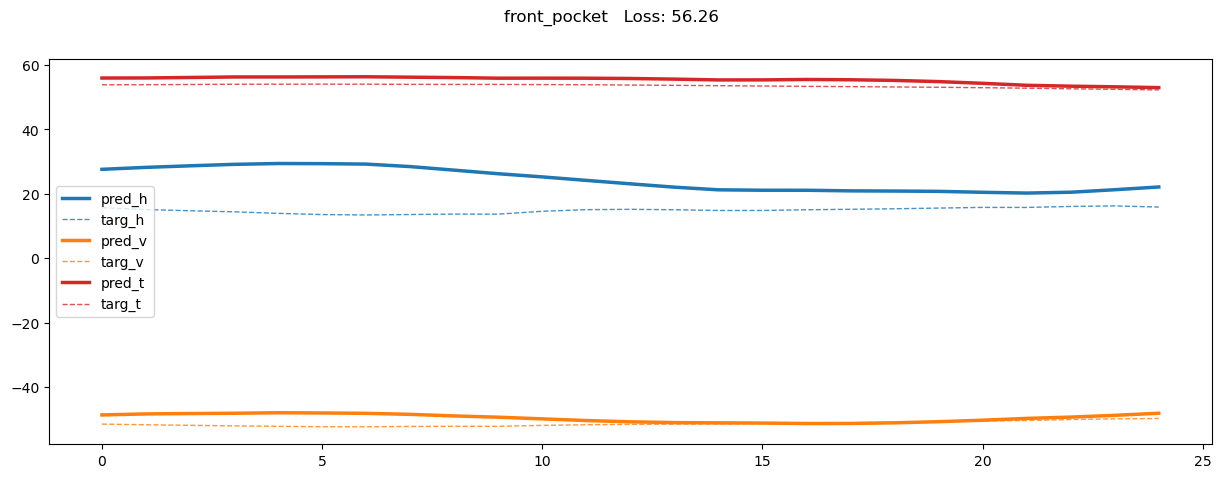

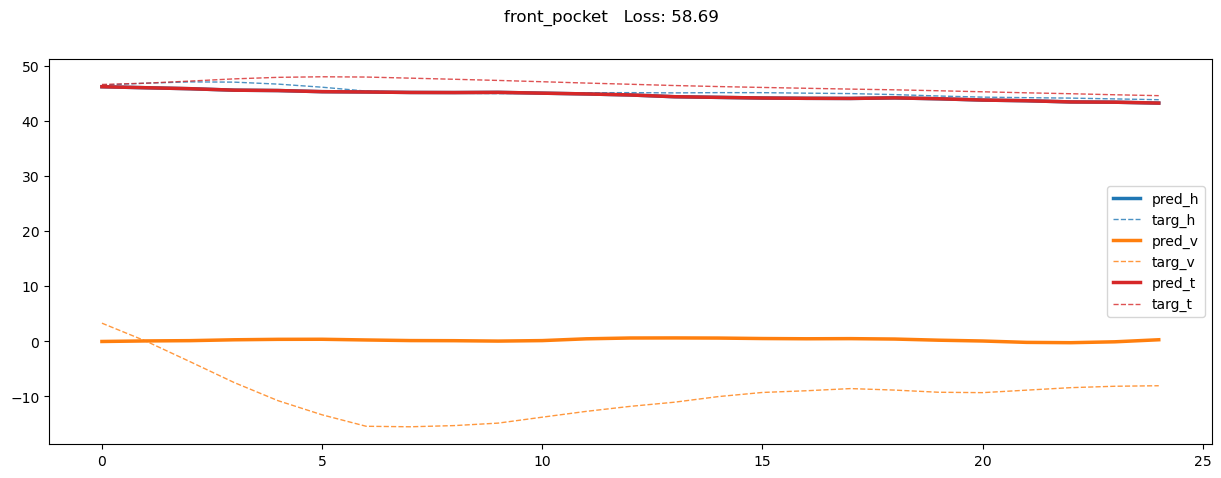

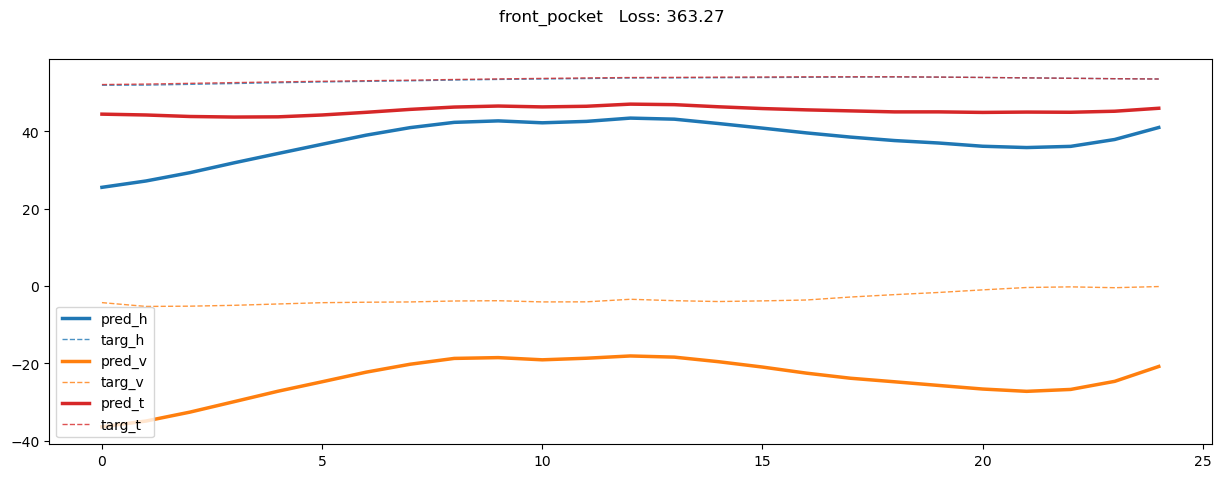

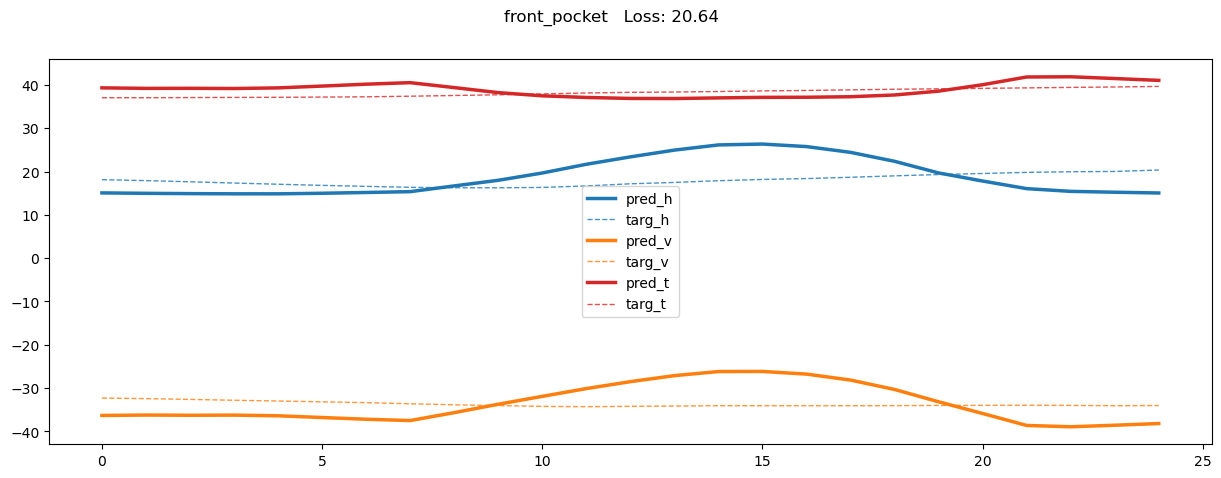

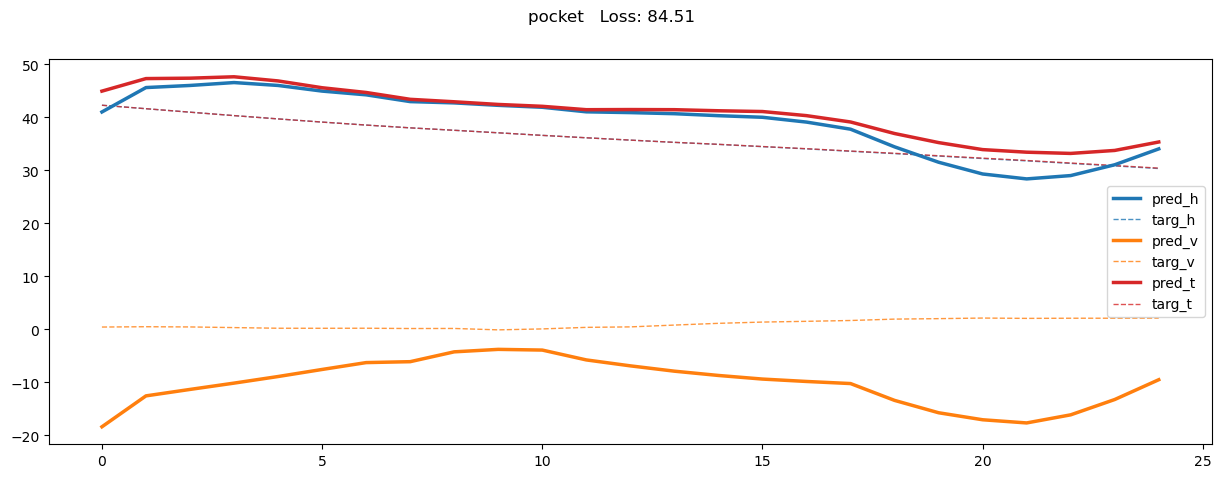

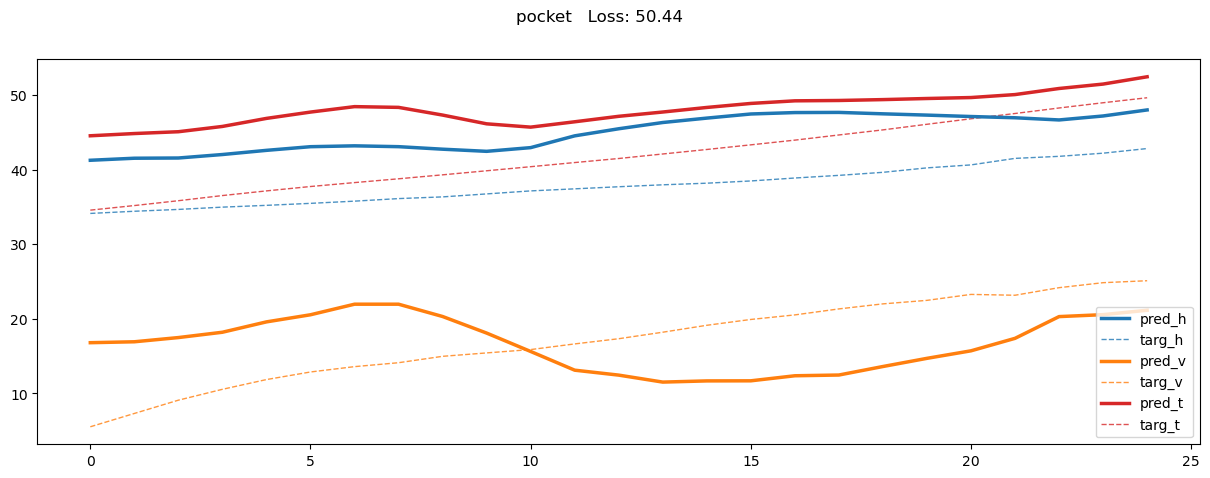

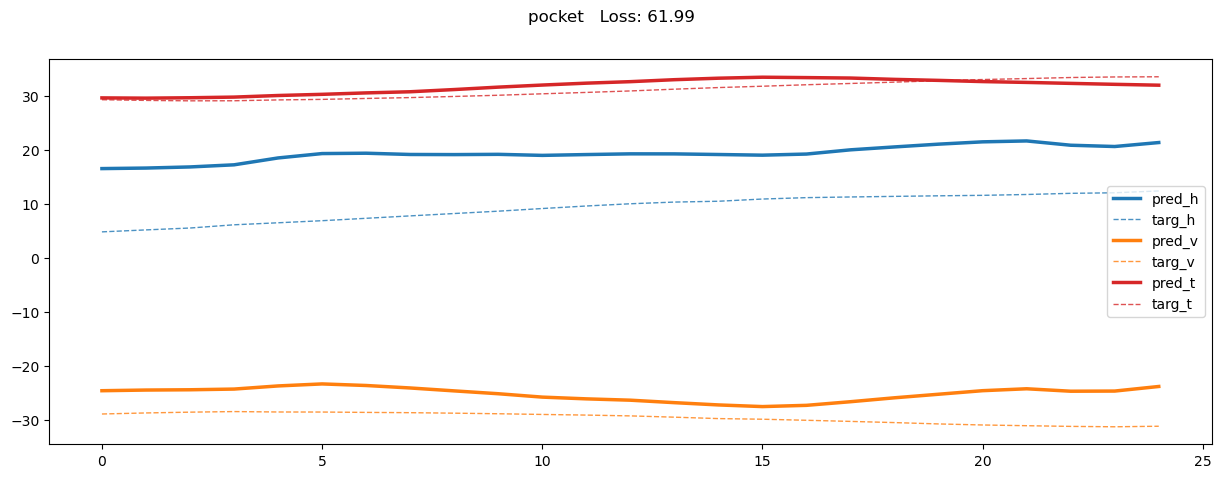

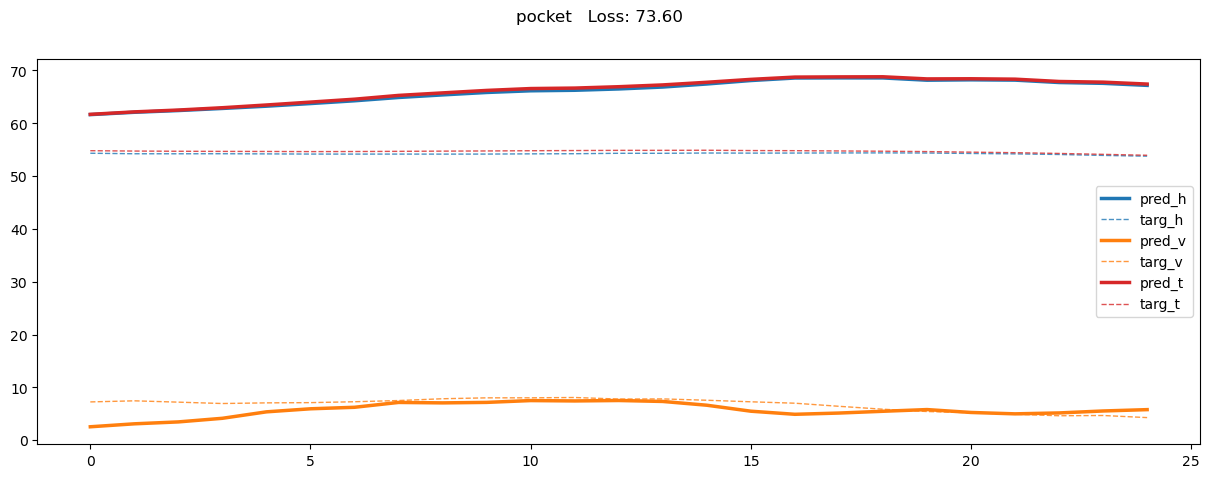

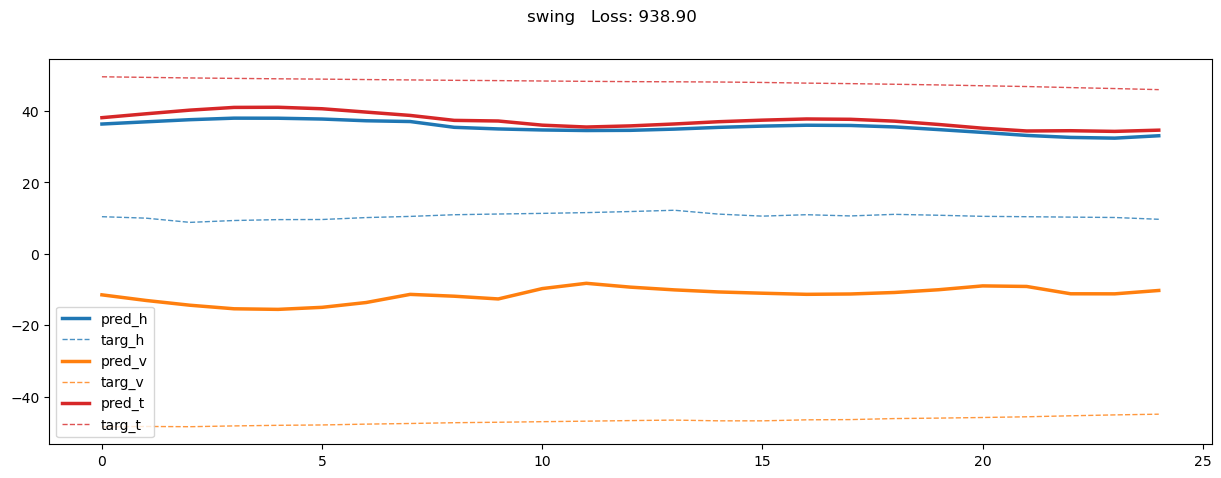

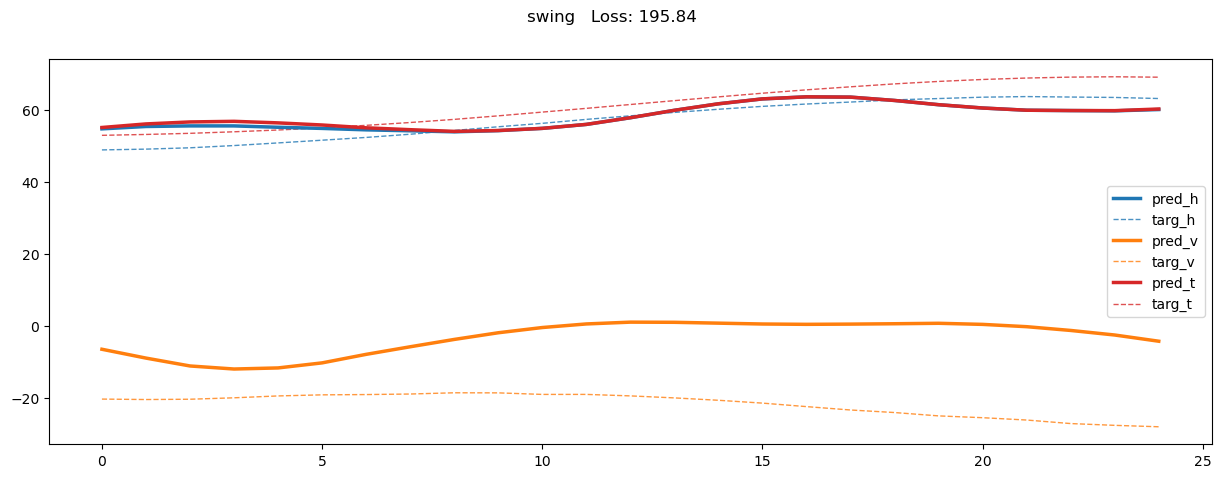

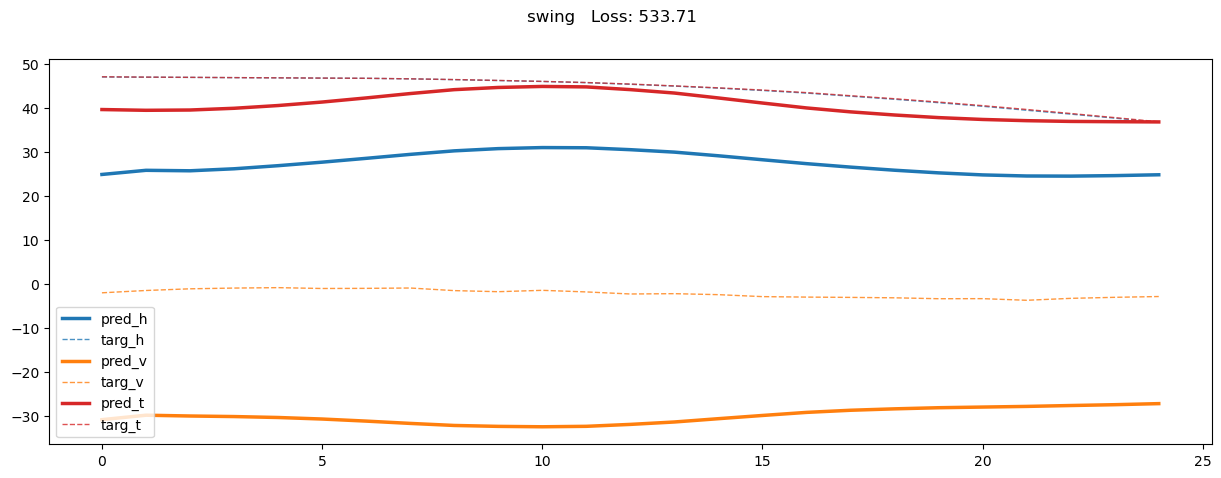

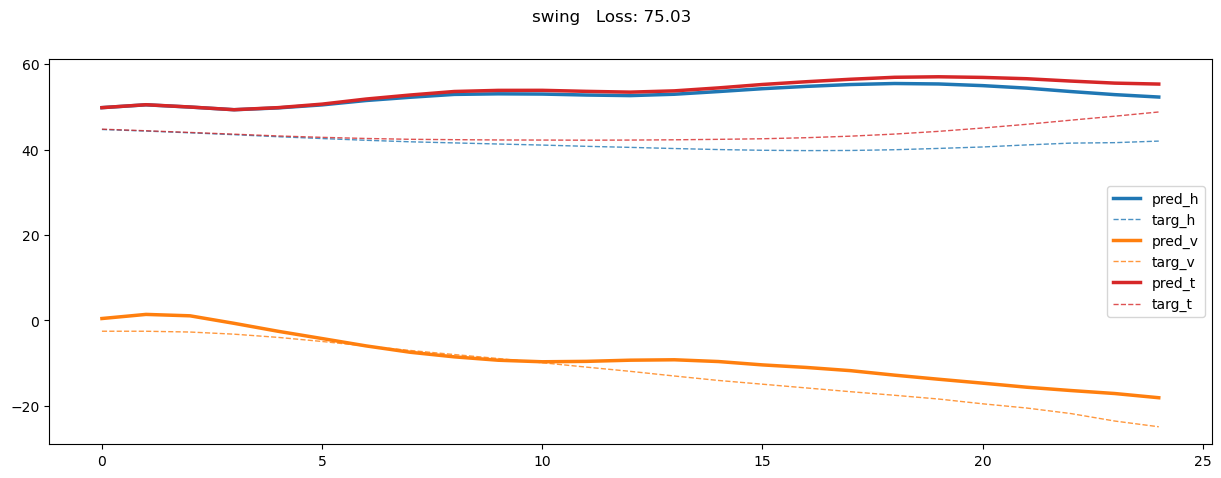

In [54]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff h":>8} {"diff v":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
dx, dy = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)

In [ ]:
def plot_eval_result(result, path):
    pred_mag = np.stack(results[:, 0], axis=0)[:, 0].reshape(-1, 3)
    targ_mag = np.stack(results[:, 1], axis=0)[:, 0].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(25, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{path}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
def load_data(folder_path):
    source_path = os.path.join(folder_path, 'source')
    target_path = os.path.join(folder_path, 'target')

    #########################
    ##### check devices #####
    #########################
    source_path, target_path = check_data_device(source_path, target_path)

    ####################################
    ##### load and preprocess data #####
    ####################################
    source_df = load_original_data(source_path)
    target_df = load_original_data(target_path)

    source_df, target_df = bound_range(source_df), bound_range(target_df)
    source_df, target_df = align_data(source_df, target_df)
    
    return select_data(source_df), select_data(target_df)

def split_data(df):
    ncols = seq_len
    nrows = len(df) - seq_len + 1
    
    index = np.zeros((nrows, ncols), dtype=int)
    index += np.arange(ncols)
    index += np.arange(nrows).T[:, None]
    
    return df.to_numpy()[index]    

def combine_to_dataloader(source, target):
    dataset = PairDataset(
                        source_data = torch.tensor(source, dtype=torch.float),
                        source_label = np.zeros(len(source)),
                        target_data = torch.tensor(target, dtype=torch.float),
                        target_label = np.zeros(len(target)),
                    )
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    return dataloader

def generate_dataloader(folder_path):
    source_df, target_df = load_data(folder_path)
    source_segs, target_segs = split_data(source_df), split_data(target_df)

    return combine_to_dataloader(source_segs, target_segs)

In [ ]:
for folder in ['./front_pocket/*', './pocket/*', './swing/*']:
    for path in glob.glob(folder):
        eval_loader = generate_dataloader(path)
        results, _, _ = output_eval(model, eval_loader)
        plot_eval_result(results, path)